# Import Libraries

In [1]:
# Data manipulation libraries
import pandas as pd
import numpy as np

# Data visualization libraries
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
from plotly.subplots import make_subplots
import plotly.graph_objs as go



In [40]:
from tensorflow.keras.layers import AlphaDropout
from tensorflow.keras import regularizers
from sklearn.metrics import classification_report, confusion_matrix
import keras.backend as K
from sklearn.metrics import f1_score
from keras.layers import BatchNormalization

 # Load and Check Data

In [9]:
df = pd.read_csv('train_dataset.csv')

In [3]:
df.head()

age  height(cm)  weight(kg)  waist(cm)  eyesight(left)  eyesight(right)  \
0   35         170          85       97.0             0.9              0.9   
1   20         175         110      110.0             0.7              0.9   
2   45         155          65       86.0             0.9              0.9   
3   45         165          80       94.0             0.8              0.7   
4   20         165          60       81.0             1.5              0.1   

   hearing(left)  hearing(right)  systolic  relaxation  ...   HDL    LDL  \
0              1               1       118          78  ...  70.0  142.0   
1              1               1       119          79  ...  71.0  114.0   
2              1               1       110          80  ...  57.0  112.0   
3              1               1       158          88  ...  46.0   91.0   
4              1               1       109          64  ...  47.0   92.0   

   hemoglobin  Urine protein  serum creatinine     AST     ALT    Gtp  \
0        19.8            1.0               1.0    61.0   115.0  125.0   
1        15.9            1.0               1.1    19.0    25.0   30.0   
2        13.7            3.0               0.6  1090.0  1400.0  276.0   
3        16.9            1.0               0.9    32.0    36.0   36.0   
4        14.9            1.0               1.2    26.0    28.0   15.0   

   dental caries  smoking  
0            1.0      1.0  
1            1.0      0.0  
2            0.0      0.0  
3            0.0      0.0  
4            0.0      0.0  

[5 rows x 23 columns]

In [ ]:
print('The dimension of the train dataset is:', df.shape)

The dimension of the train dataset is: (38984, 23)


**Drop the 'id' column from both train and test**

In [ ]:
df.columns

Index(['age', 'height(cm)', 'weight(kg)', 'waist(cm)', 'eyesight(left)',
       'eyesight(right)', 'hearing(left)', 'hearing(right)', 'systolic',
       'relaxation', 'fasting blood sugar', 'Cholesterol', 'triglyceride',
       'HDL', 'LDL', 'hemoglobin', 'Urine protein', 'serum creatinine', 'AST',
       'ALT', 'Gtp', 'dental caries', 'smoking'],
      dtype='object')

In [ ]:
df.describe().T\
    .style.bar(subset=['mean'], color=px.colors.qualitative.G10[2])\
    .background_gradient(subset=['std'], cmap='Blues')\
    .background_gradient(subset=['50%'], cmap='BuGn')

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 38984 entries, 0 to 38983
Data columns (total 23 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   age                  38984 non-null  int64  
 1   height(cm)           38984 non-null  int64  
 2   weight(kg)           38984 non-null  int64  
 3   waist(cm)            38984 non-null  float64
 4   eyesight(left)       38984 non-null  float64
 5   eyesight(right)      38984 non-null  float64
 6   hearing(left)        38984 non-null  int64  
 7   hearing(right)       38984 non-null  int64  
 8   systolic             38984 non-null  int64  
 9   relaxation           38984 non-null  int64  
 10  fasting blood sugar  38984 non-null  int64  
 11  Cholesterol          38984 non-null  int64  
 12  triglyceride         38984 non-null  int64  
 13  HDL                  38984 non-null  int64  
 14  LDL                  38984 non-null  int64  
 15  hemoglobin           38984 non-null 

In [4]:
df=df.drop_duplicates()

In [5]:
df.shape

(33467, 23)

## Check for missing data:

In [ ]:
print(df.isna().sum())

age                    0
height(cm)             0
weight(kg)             0
waist(cm)              0
eyesight(left)         0
eyesight(right)        0
hearing(left)          0
hearing(right)         0
systolic               0
relaxation             0
fasting blood sugar    0
Cholesterol            0
triglyceride           0
HDL                    0
LDL                    0
hemoglobin             0
Urine protein          0
serum creatinine       0
AST                    0
ALT                    0
Gtp                    0
dental caries          0
smoking                0
dtype: int64


> There are no missing values in the dataset. That is good.

In [ ]:
df.nunique().sort_values()

hearing(left)            2
hearing(right)           2
dental caries            2
smoking                  2
Urine protein            6
height(cm)              13
age                     14
eyesight(right)         17
eyesight(left)          19
weight(kg)              22
serum creatinine        34
relaxation              94
HDL                    122
systolic               125
hemoglobin             143
AST                    195
ALT                    230
fasting blood sugar    258
Cholesterol            279
LDL                    286
triglyceride           389
Gtp                    439
waist(cm)              545
dtype: int64

## check for outliers

In [ ]:
# Function to detect outliers in a column
def detect_outliers(df, column):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    outliers = df[(df[column] < lower_bound) | (df[column] > upper_bound)]
    return outliers


# Detect outliers in each numerical column and store results
outliers_info = {}

for col in df.select_dtypes(include="number").columns:
    outliers = detect_outliers(df, col)
    if not outliers.empty:
        outliers_info[col] = len(outliers)
        print(f"Column '{col}' has {len(outliers)} outliers.")

Column 'age' has 184 outliers.
Column 'height(cm)' has 155 outliers.
Column 'weight(kg)' has 127 outliers.
Column 'waist(cm)' has 329 outliers.
Column 'eyesight(left)' has 810 outliers.
Column 'eyesight(right)' has 823 outliers.
Column 'hearing(left)' has 849 outliers.
Column 'hearing(right)' has 872 outliers.
Column 'systolic' has 414 outliers.
Column 'relaxation' has 427 outliers.
Column 'fasting blood sugar' has 1987 outliers.
Column 'Cholesterol' has 373 outliers.
Column 'triglyceride' has 1412 outliers.
Column 'HDL' has 595 outliers.
Column 'LDL' has 403 outliers.
Column 'hemoglobin' has 476 outliers.
Column 'Urine protein' has 1844 outliers.
Column 'serum creatinine' has 1905 outliers.
Column 'AST' has 1800 outliers.
Column 'ALT' has 2255 outliers.
Column 'Gtp' has 2901 outliers.
Column 'dental caries' has 7185 outliers.


In [ ]:
# # Function to drop outliers in specific columns
# def drop_outliers(df, columns):
#     for column in columns:
#         Q1 = df[column].quantile(0.25)
#         Q3 = df[column].quantile(0.75)
#         IQR = Q3 - Q1
#         lower_bound = Q1 - 1.5 * IQR
#         upper_bound = Q3 + 1.5 * IQR
#         df = df[(df[column] >= lower_bound) & (df[column] <= upper_bound)]
#     return df

# columns_to_remove_outliers = []

# # Drop the outliers
# #df_cleaned = drop_outliers(df, columns_to_remove_outliers)

# # Check the shape of the cleaned dataframe
# print(f"Shape of the dataframe before dropping outliers: {df.shape}")
# #print(f"Shape of the dataframe after dropping outliers: {df_cleaned.shape}")

# Exploratory Data Analysis

## Univariate Analysis

In [ ]:
num_cols = [col for col in df.columns if col !='smoking']

In [ ]:
# Loop through each numerical column
for col in df.columns:
    # Create a subplot with one row and three columns
    fig = make_subplots(rows=1, cols=3, column_widths=[0.6, 0.2, 0.2],
                        subplot_titles=[f'{col} Distribution ', 'Quantiles '])

    # Add the histogram for train dataset
    fig.add_trace(go.Histogram(x=df[col], name=f'Train {col}', opacity=0.7,
                               marker=dict(color="#0A4D68", line=dict(color='#DBE6EC', width=0.5))),
                  row=1, col=1)

    # Add the vertical boxplot for train dataset
    fig.add_trace(go.Box(y=df[col], name=f'Train {col}', orientation='v', boxpoints='outliers',
                         marker=dict(color='#9bf6ff')), row=1, col=2)


    # Update layout
    fig.update_layout(height=400, width=1000, showlegend=False,
                      paper_bgcolor='black', plot_bgcolor='black',
                      font=dict(color="white"),
                      barmode='overlay')

    # Show the figure
    fig.show()


## Bivariate Analysis

### Numerical vs Numerical:

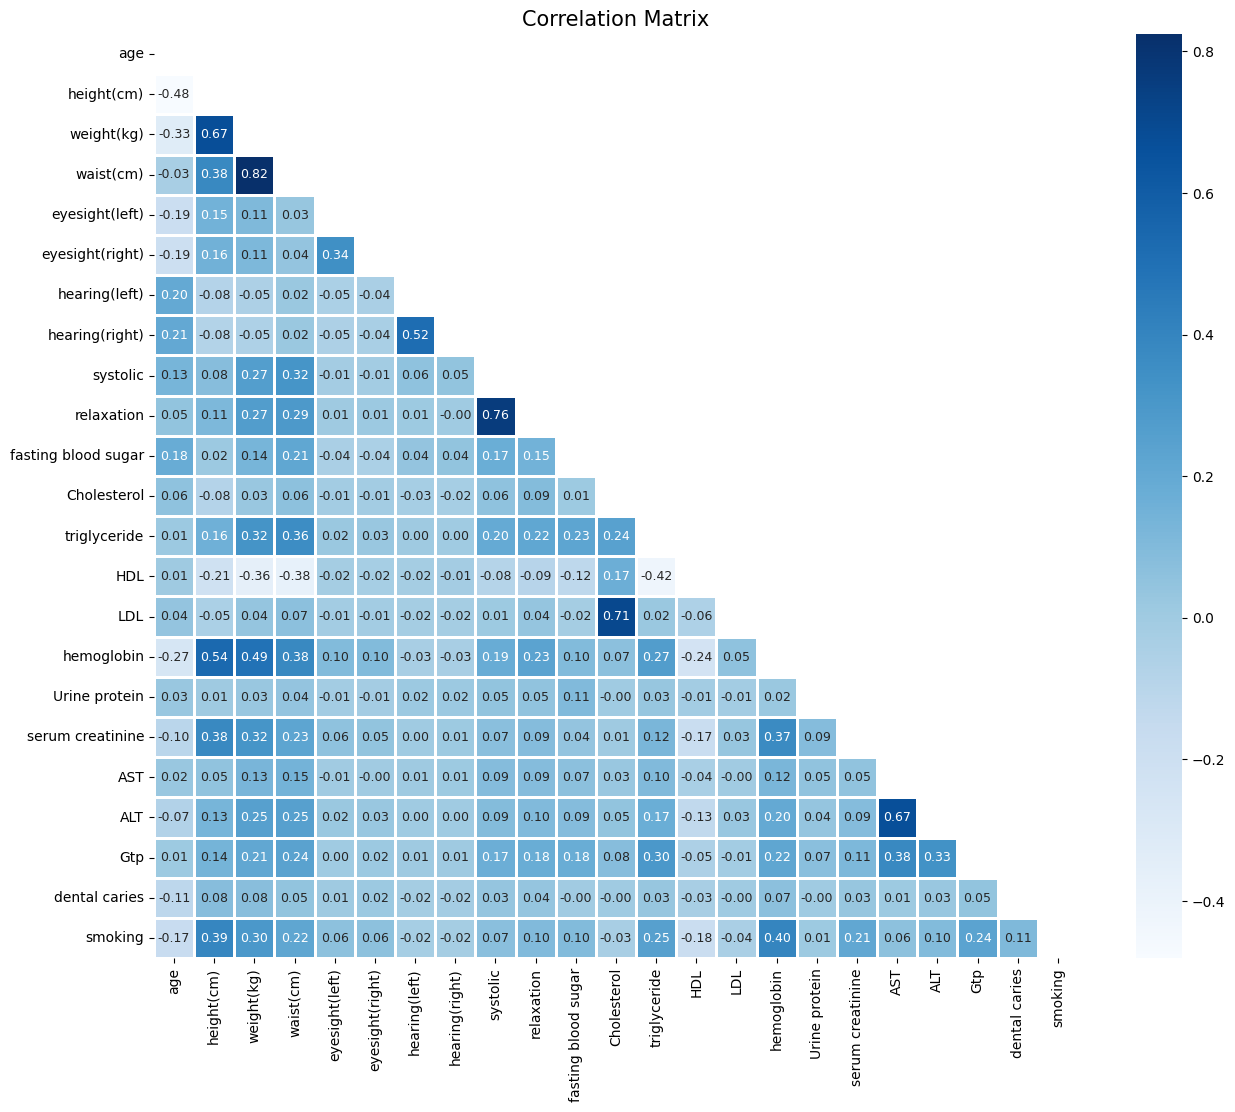

In [ ]:
corr_matrix = df[df.columns].corr()
mask = np.triu(np.ones_like(corr_matrix, dtype=bool))

plt.figure(figsize=(15, 12))
sns.heatmap(corr_matrix, mask=mask, annot=True, cmap='Blues', fmt='.2f', linewidths=1, square=True, annot_kws={"size": 9} )
plt.title('Correlation Matrix', fontsize=15)
plt.show()

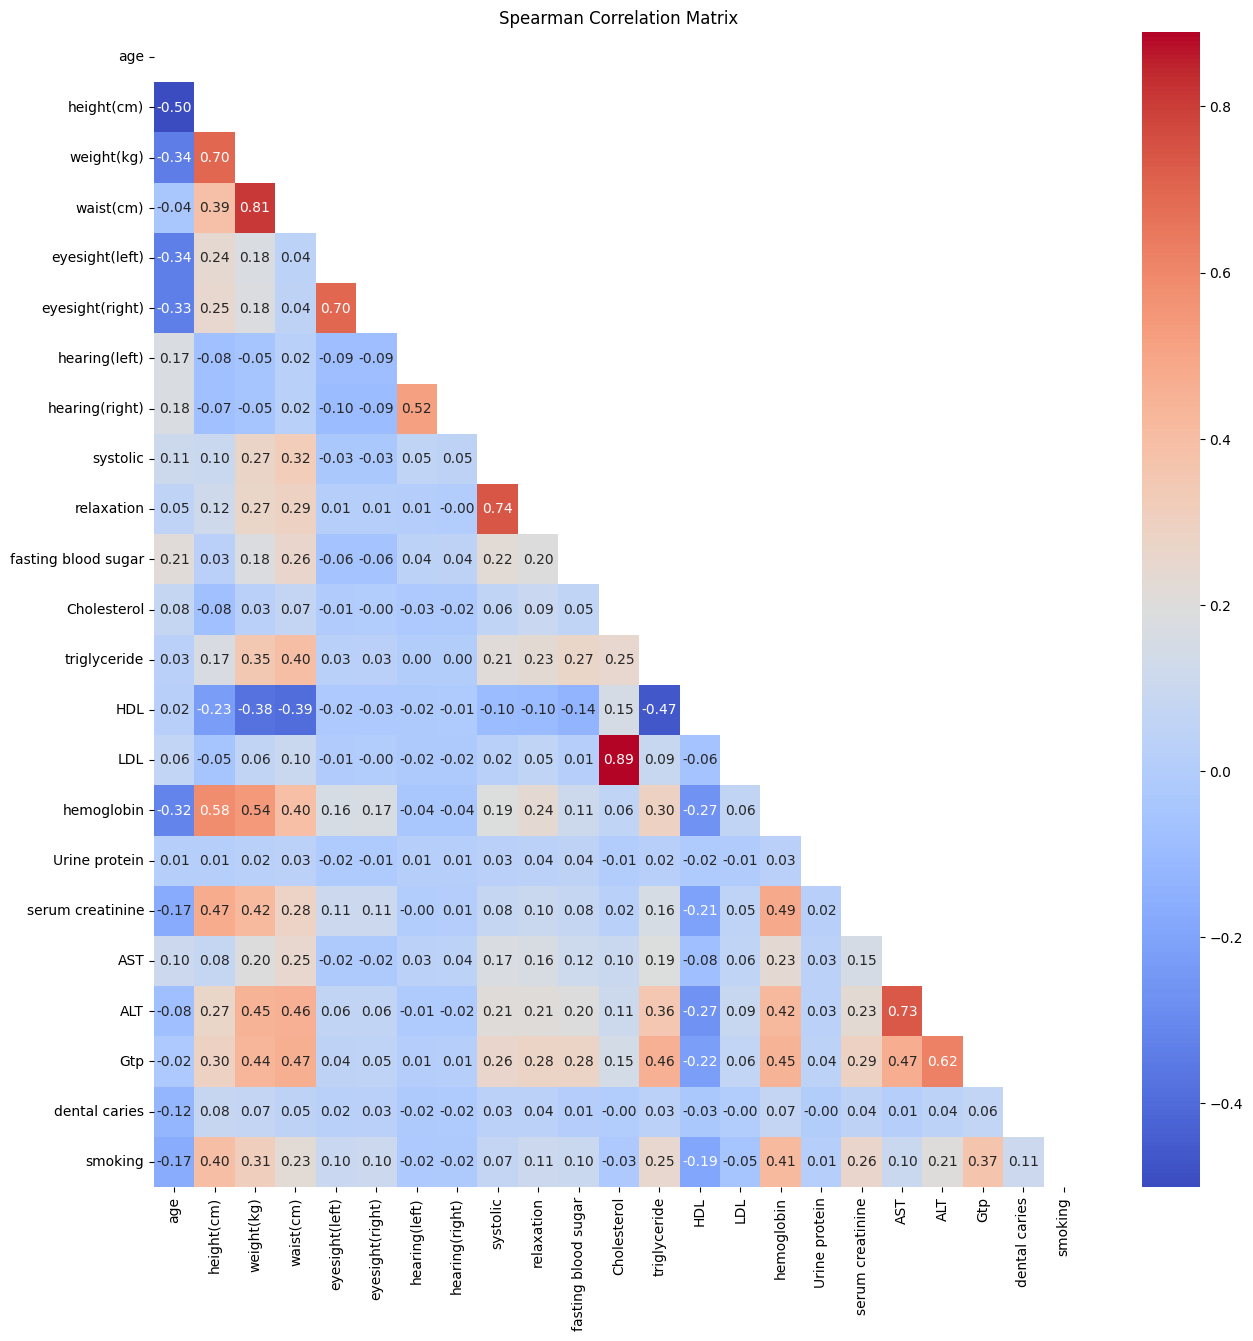

In [ ]:
# Calculate Spearman correlation matrix
spearman_corr = df[df.columns].corr(method='spearman')
mask = np.triu(np.ones_like(spearman_corr, dtype=bool))

# Visualize the Spearman correlation matrix
plt.figure(figsize=(15,15))
sns.heatmap(spearman_corr,mask=mask, annot=True, fmt=".2f", cmap="coolwarm", annot_kws={"size":10})
plt.title('Spearman Correlation Matrix')
plt.show()

## Feature Engineering

I will keep the data with out any feature engineering

## data spliting

In [10]:
from sklearn.model_selection import train_test_split

In [11]:
target='smoking'

In [12]:
X=df.drop(columns=[target])
y=df[target]

In [13]:
X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size=0.2, stratify=y , random_state=42)

In [14]:
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.1,stratify=y_train_val ,   random_state=42)

In [ ]:
X_train.shape

(24095, 22)

In [ ]:
X_test.shape

(6694, 22)

In [ ]:
X_val.shape

(2678, 22)

# Modeling

In [15]:
!pip install keras-tuner

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.1/129.1 kB 2.6 MB/s eta 0:00:00


In [16]:
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
import keras_tuner as kt

In [17]:
from sklearn.preprocessing import StandardScaler

In [18]:
scaler = StandardScaler()

X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

In [19]:
model = keras.models.Sequential([
            keras.layers.Dense(50, kernel_initializer='lecun_normal', activation='selu',input_shape=(22,)),
            keras.layers.Dense(50, kernel_initializer='lecun_normal', activation='selu'),
            keras.layers.Dense(50, kernel_initializer='lecun_normal', activation='selu'),
            keras.layers.Dense(1, activation='sigmoid')
      ])

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 50)                1150      
                                                                 
 dense_1 (Dense)             (None, 50)                2550      
                                                                 
 dense_2 (Dense)             (None, 50)                2550      
                                                                 
 dense_3 (Dense)             (None, 1)                 51        
                                                                 
Total params: 6301 (24.61 KB)
Trainable params: 6301 (24.61 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [20]:
import keras.backend as K
from sklearn.metrics import f1_score

In [21]:
# custom F1 score metric
def f1_score_metric(y_true, y_pred):
    def recall(y_true, y_pred):
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
        recall = true_positives / (possible_positives + K.epsilon())
        return recall

    def precision(y_true, y_pred):
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
        precision = true_positives / (predicted_positives + K.epsilon())
        return precision

    precision_val = precision(y_true, y_pred)
    recall_val = recall(y_true, y_pred)
    f1_val = 2 * ((precision_val * recall_val) / (precision_val + recall_val + K.epsilon()))
    return f1_val

In [ ]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy', f1_score_metric])

In [ ]:
X_val_scaled.shape

(2678, 22)

In [ ]:
history = model.fit(X_train_scaled, y_train, epochs=30, validation_data = (X_val_scaled, y_val), batch_size=32)

Epoch 1/30
753/753 [==============================] - 3s 2ms/step - loss: 0.5057 - accuracy: 0.7311 - f1_score_metric: 0.6131 - val_loss: 0.5040 - val_accuracy: 0.7248 - val_f1_score_metric: 0.6167
Epoch 2/30
753/753 [==============================] - 2s 2ms/step - loss: 0.4861 - accuracy: 0.7419 - f1_score_metric: 0.6323 - val_loss: 0.4982 - val_accuracy: 0.7293 - val_f1_score_metric: 0.6339
Epoch 3/30
753/753 [==============================] - 1s 2ms/step - loss: 0.4817 - accuracy: 0.7470 - f1_score_metric: 0.6397 - val_loss: 0.4981 - val_accuracy: 0.7274 - val_f1_score_metric: 0.6255
Epoch 4/30
753/753 [==============================] - 2s 2ms/step - loss: 0.4772 - accuracy: 0.7512 - f1_score_metric: 0.6496 - val_loss: 0.5083 - val_accuracy: 0.7300 - val_f1_score_metric: 0.5968
Epoch 5/30
753/753 [==============================] - 2s 2ms/step - loss: 0.4760 - accuracy: 0.7522 - f1_score_metric: 0.6513 - val_loss: 0.4996 - val_accuracy: 0.7248 - val_f1_score_metric: 0.5945
Epoch 6/30

In [25]:
from sklearn.metrics import classification_report, confusion_matrix

In [31]:
def evaluate_model(history, model, X_train, X_val, X_test, y_train, y_val, y_test):
    # Convert history to DataFrame
    history_df = pd.DataFrame(history.history)

    # Plot Loss
    plt.figure(figsize=(15, 8))
    plt.plot(history_df['loss'], label='Training Loss')
    plt.plot(history_df['val_loss'], label='Validation Loss')
    plt.title('Loss Over Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)
    plt.show()

    # Plot Accuracy
    plt.figure(figsize=(15, 8))
    plt.plot(history_df['accuracy'], label='Training Accuracy')
    plt.plot(history_df['val_accuracy'], label='Validation Accuracy')
    plt.title('Accuracy Over Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid(True)
    plt.show()

    # Plot F1 score
    plt.figure(figsize=(15, 8))
    plt.plot(history_df['f1_score_metric'], label='Training F1 Score')
    plt.plot(history_df['val_f1_score_metric'], label='Validation F1 Score')
    plt.title('F1 Score Over Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('F1 Score')
    plt.legend()
    plt.grid(True)
    plt.show()

    # Predict on train, validation, and test sets
    y_train_pred = (model.predict(X_train) > 0.5).astype(int)
    y_val_pred = (model.predict(X_val) > 0.5).astype(int)
    y_test_pred = (model.predict(X_test) > 0.5).astype(int)

    # Classification Report for Training Set
    print("Classification Report - Training Set")
    print(classification_report(y_train, y_train_pred))

    # Classification Report for Validation Set
    print("Classification Report - Validation Set")
    print(classification_report(y_val, y_val_pred))

    # Classification Report for Test Set
    print("Classification Report - Test Set")
    print(classification_report(y_test, y_test_pred))

    # Confusion Matrix for Training Set
    plt.figure(figsize=(10, 7))
    cm_train = confusion_matrix(y_train, y_train_pred)
    sns.heatmap(cm_train, annot=True, fmt='d', cmap='Blues')
    plt.title('Confusion Matrix - Training Set')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()

    # Confusion Matrix for Validation Set
    plt.figure(figsize=(10, 7))
    cm_val = confusion_matrix(y_val, y_val_pred)
    sns.heatmap(cm_val, annot=True, fmt='d', cmap='Blues')
    plt.title('Confusion Matrix - Validation Set')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()

    # Confusion Matrix for Test Set
    plt.figure(figsize=(10, 7))
    cm_test = confusion_matrix(y_test, y_test_pred)
    sns.heatmap(cm_test, annot=True, fmt='d', cmap='Blues')
    plt.title('Confusion Matrix - Test Set')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()

In [64]:
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, roc_auc_score

In [67]:
def evaluate_model_withROC(model, X_train, X_val, X_test, y_train, y_val, y_test):
    # ROC Curve and AUC for Train Set
    y_train_prob = model.predict(X_train)  # Get predicted probabilities
    fpr_train, tpr_train, _ = roc_curve(y_train, y_train_prob)
    auc_train = roc_auc_score(y_train, y_train_prob)

    # ROC Curve and AUC for Validation Set
    y_val_prob = model.predict(X_val)  # Get predicted probabilities
    fpr_val, tpr_val, _ = roc_curve(y_val, y_val_prob)
    auc_val = roc_auc_score(y_val, y_val_prob)

    # ROC Curve and AUC for Test Set
    y_test_prob = model.predict(X_test)  # Get predicted probabilities
    fpr_test, tpr_test, _ = roc_curve(y_test, y_test_prob)
    auc_test = roc_auc_score(y_test, y_test_prob)

    # Plotting ROC Curves
    plt.figure(figsize=(10, 8))
    plt.plot(fpr_train, tpr_train, color='blue', label='Train ROC curve (AUC = {:.2f})'.format(auc_train))
    plt.plot(fpr_val, tpr_val, color='orange', label='Validation ROC curve (AUC = {:.2f})'.format(auc_val))
    plt.plot(fpr_test, tpr_test, color='green', label='Test ROC curve (AUC = {:.2f})'.format(auc_test))
    plt.plot([0, 1], [0, 1], color='red', linestyle='--', label='Random Classifier')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curves')
    plt.legend()
    plt.grid(True)
    plt.show()

    # Print AUC scores
    print(f'Train AUC: {auc_train:.4f}')
    print(f'Validation AUC: {auc_val:.4f}')
    print(f'Test AUC: {auc_test:.4f}')

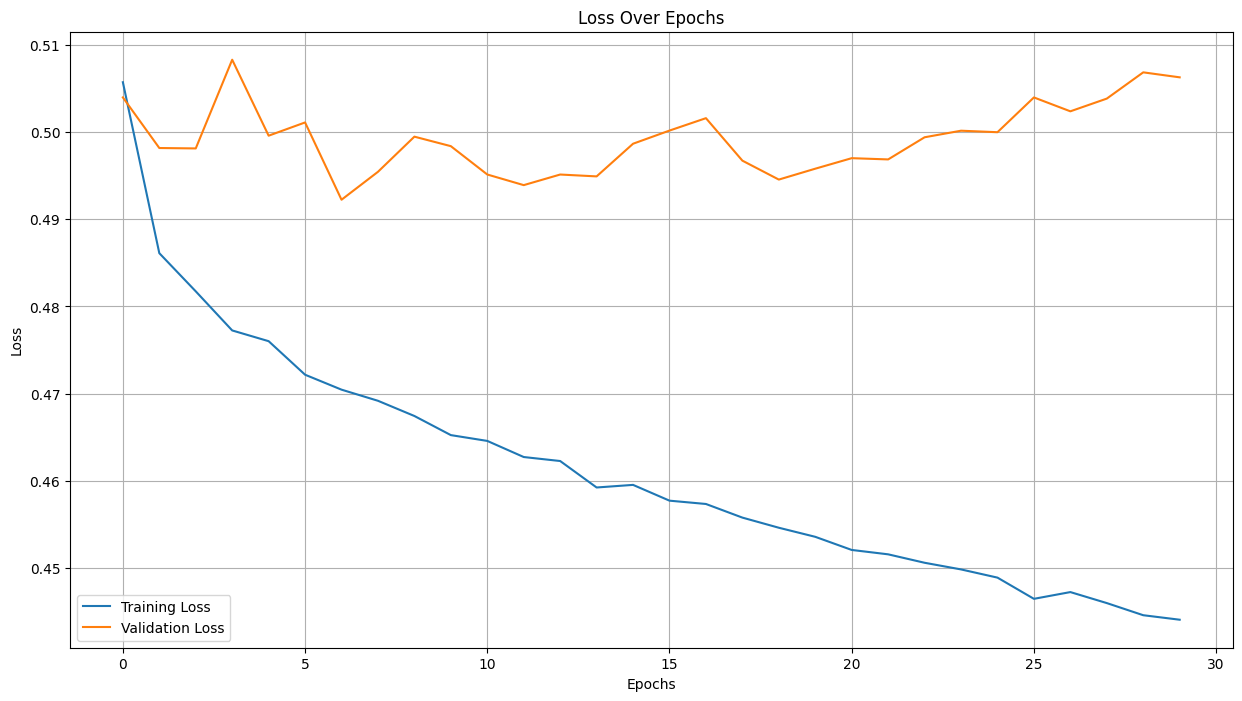

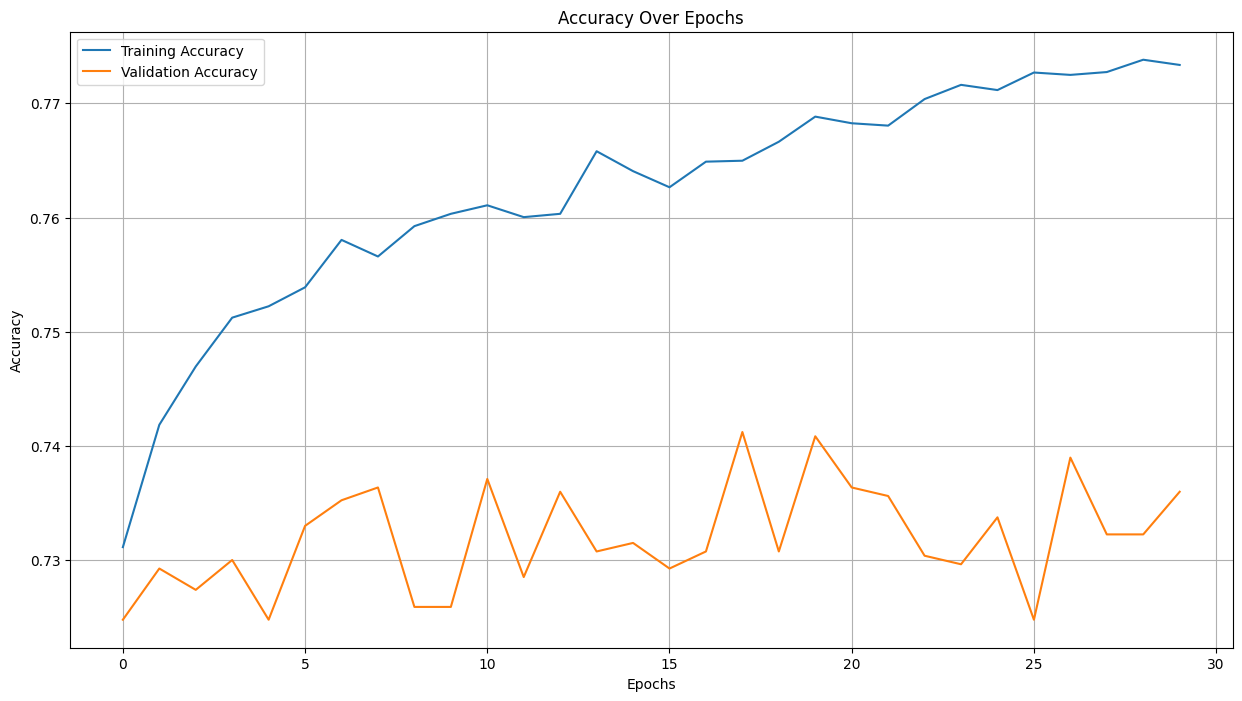

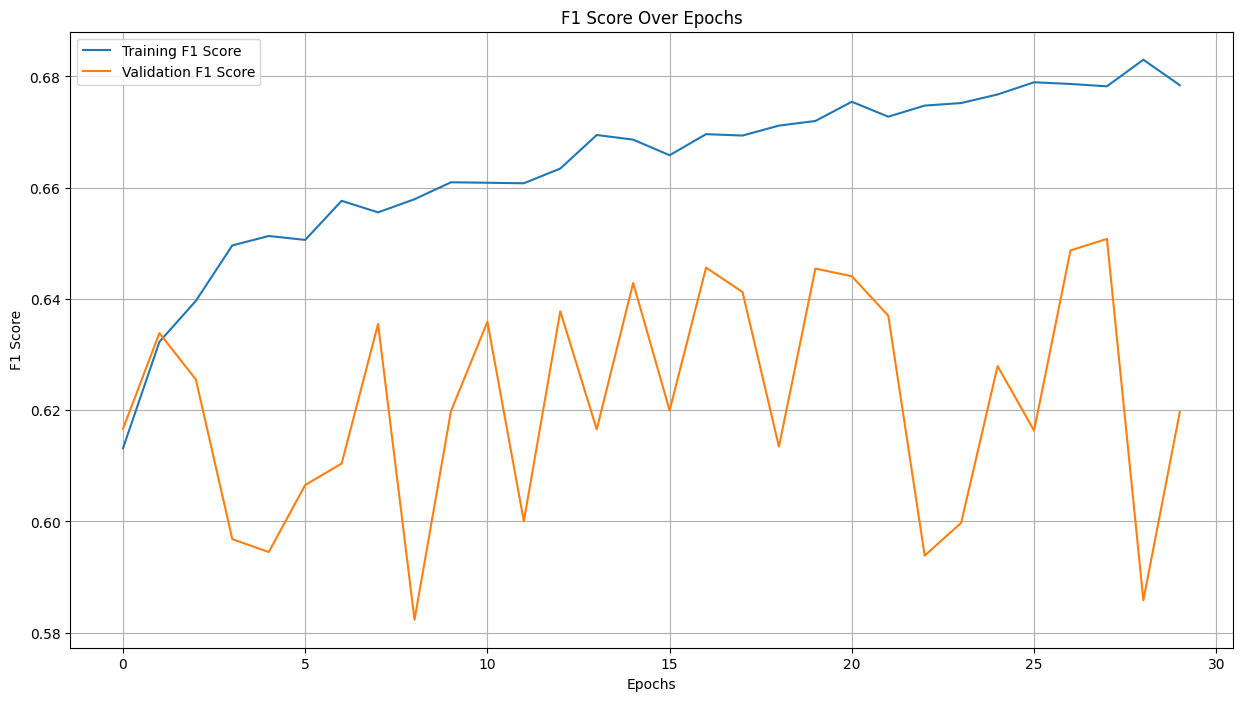

210/210 [==============================] - 0s 1ms/step
Classification Report - Training Set
              precision    recall  f1-score   support

           0       0.82      0.85      0.83     15270
           1       0.72      0.67      0.70      8825

    accuracy                           0.78     24095
   macro avg       0.77      0.76      0.76     24095
weighted avg       0.78      0.78      0.78     24095

Classification Report - Validation Set
              precision    recall  f1-score   support

           0       0.78      0.81      0.79      1697
           1       0.65      0.62      0.63       981

    accuracy                           0.74      2678
   macro avg       0.72      0.71      0.71      2678
weighted avg       0.73      0.74      0.73      2678

Classification Report - Test Set
              precision    recall  f1-score   support

           0       0.79      0.81      0.80      4242
           1       0.65      0.62      0.63      2452

    accuracy      

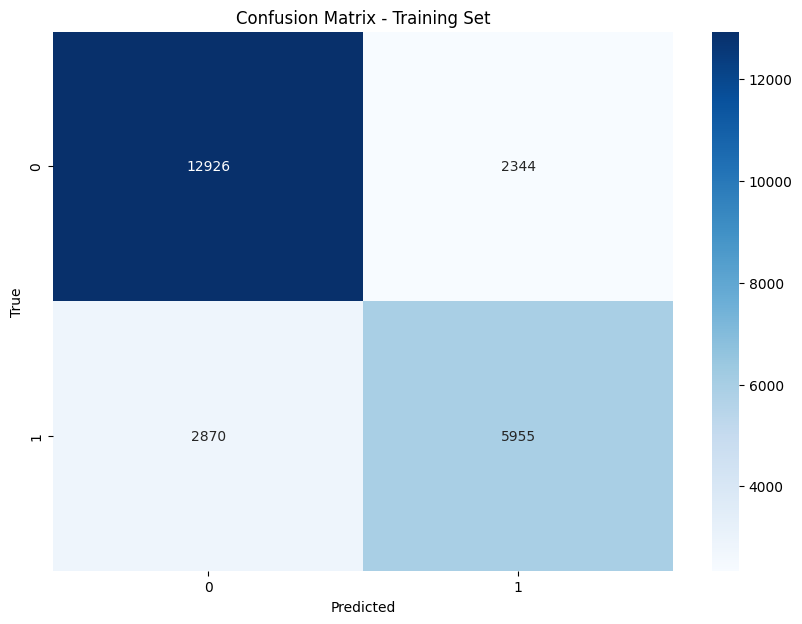

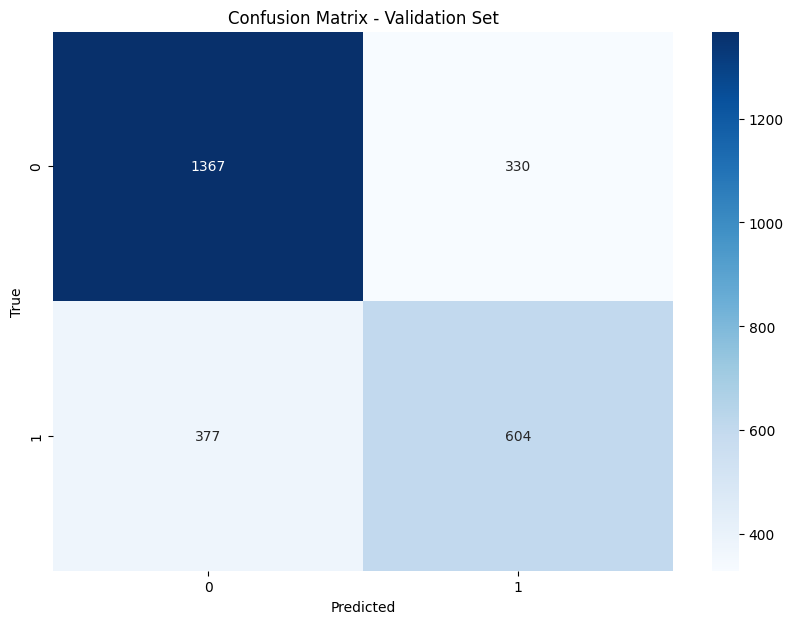

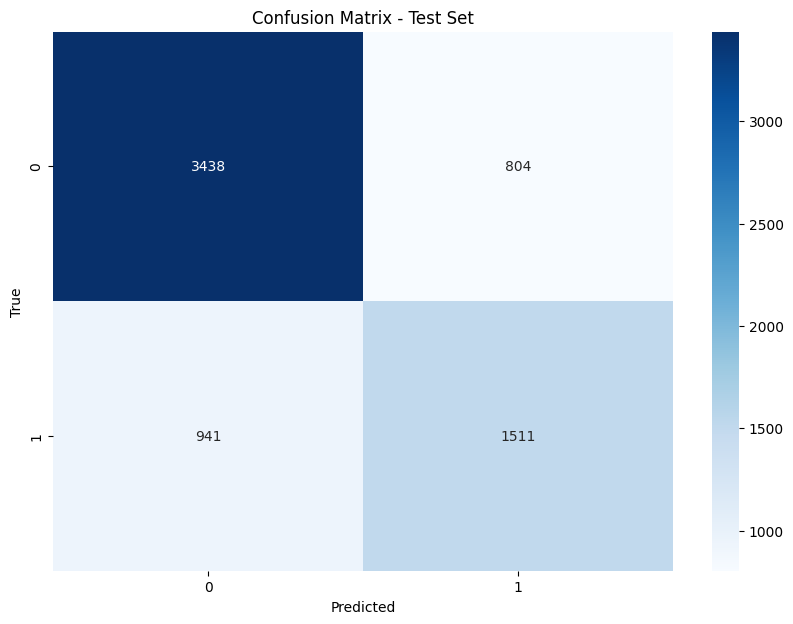

In [ ]:
evaluate_model(history, model, X_train_scaled, X_val_scaled, X_test_scaled, y_train, y_val, y_test)

train for more 70 epochs

In [ ]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy', f1_score_metric])

In [ ]:
history = model.fit(X_train_scaled, y_train, epochs=100, validation_data = (X_val_scaled, y_val), batch_size=32)

Epoch 1/100
753/753 [==============================] - 3s 2ms/step - loss: 0.5057 - accuracy: 0.7288 - f1_score_metric: 0.6141 - val_loss: 0.5030 - val_accuracy: 0.7233 - val_f1_score_metric: 0.5908
Epoch 2/100
753/753 [==============================] - 2s 2ms/step - loss: 0.4879 - accuracy: 0.7432 - f1_score_metric: 0.6348 - val_loss: 0.5102 - val_accuracy: 0.7181 - val_f1_score_metric: 0.5291
Epoch 3/100
753/753 [==============================] - 2s 2ms/step - loss: 0.4833 - accuracy: 0.7452 - f1_score_metric: 0.6396 - val_loss: 0.5019 - val_accuracy: 0.7240 - val_f1_score_metric: 0.5465
Epoch 4/100
753/753 [==============================] - 2s 2ms/step - loss: 0.4794 - accuracy: 0.7486 - f1_score_metric: 0.6445 - val_loss: 0.5091 - val_accuracy: 0.7192 - val_f1_score_metric: 0.6167
Epoch 5/100
753/753 [==============================] - 2s 2ms/step - loss: 0.4764 - accuracy: 0.7516 - f1_score_metric: 0.6485 - val_loss: 0.5021 - val_accuracy: 0.7323 - val_f1_score_metric: 0.6228
Epoch

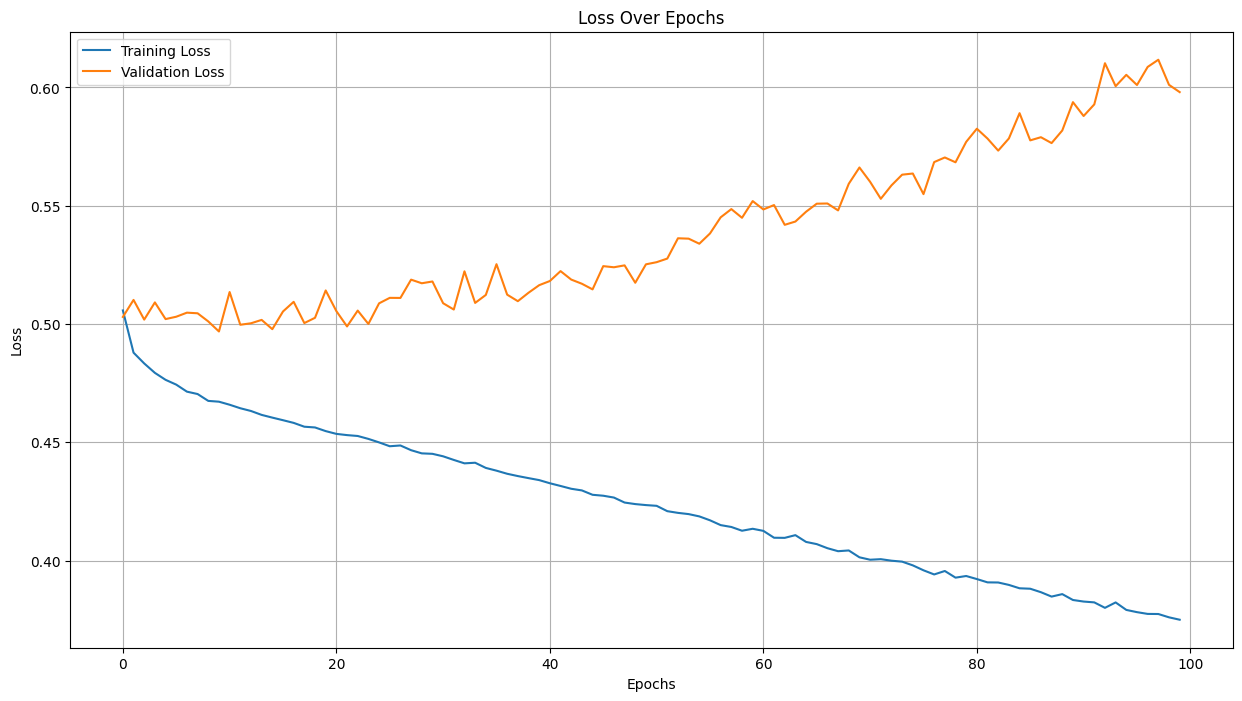

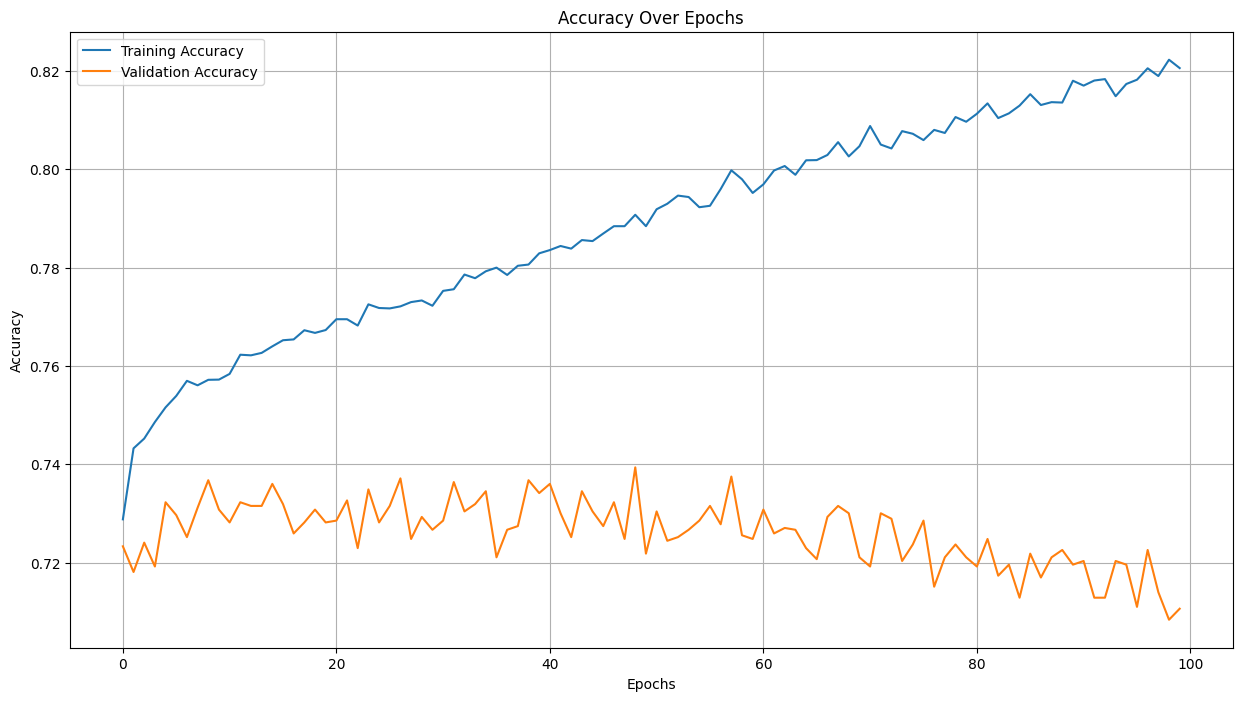

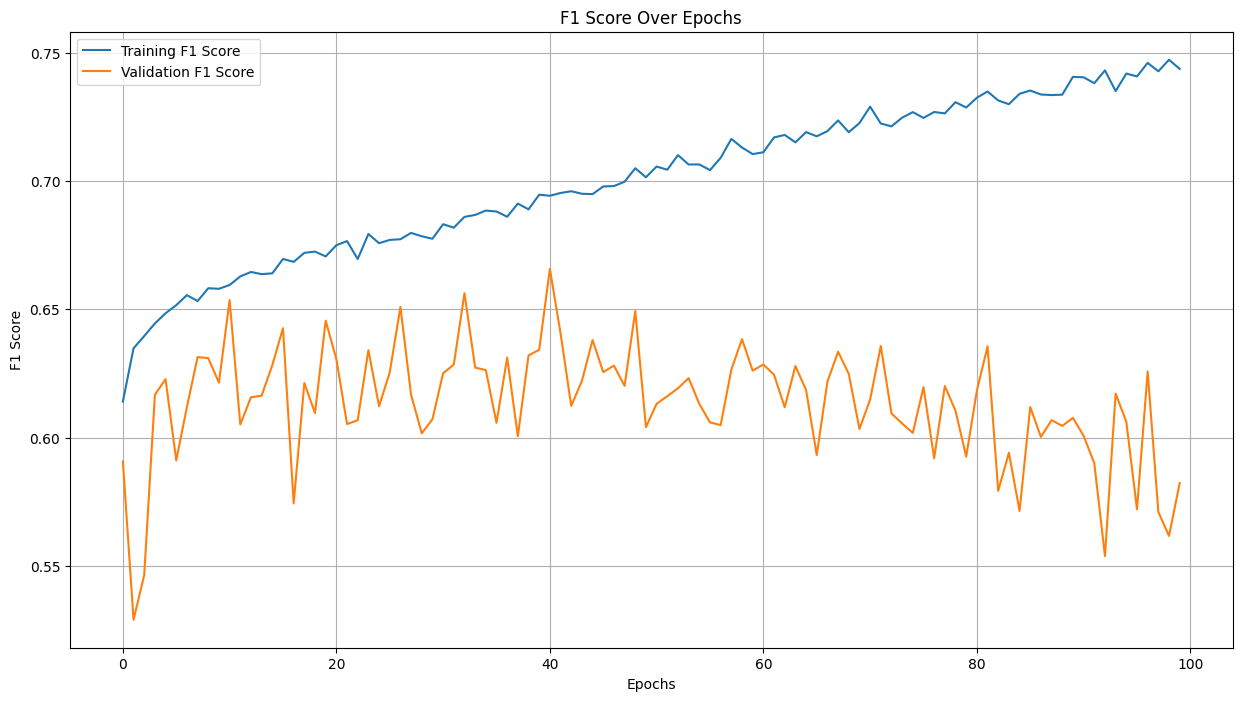

210/210 [==============================] - 0s 1ms/step
Classification Report - Training Set
              precision    recall  f1-score   support

           0       0.85      0.89      0.87     15270
           1       0.79      0.74      0.77      8825

    accuracy                           0.83     24095
   macro avg       0.82      0.81      0.82     24095
weighted avg       0.83      0.83      0.83     24095

Classification Report - Validation Set
              precision    recall  f1-score   support

           0       0.76      0.78      0.77      1697
           1       0.61      0.58      0.60       981

    accuracy                           0.71      2678
   macro avg       0.69      0.68      0.69      2678
weighted avg       0.71      0.71      0.71      2678

Classification Report - Test Set
              precision    recall  f1-score   support

           0       0.78      0.80      0.79      4242
           1       0.63      0.60      0.62      2452

    accuracy      

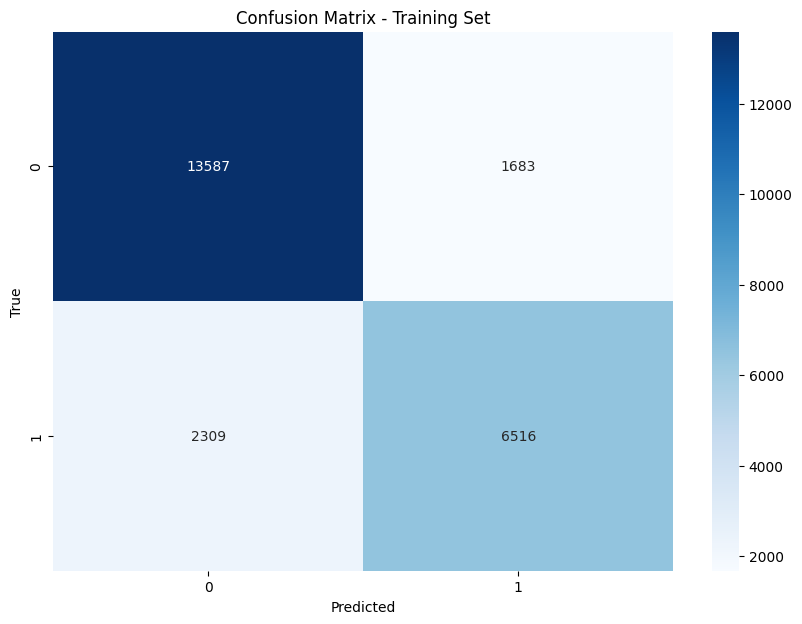

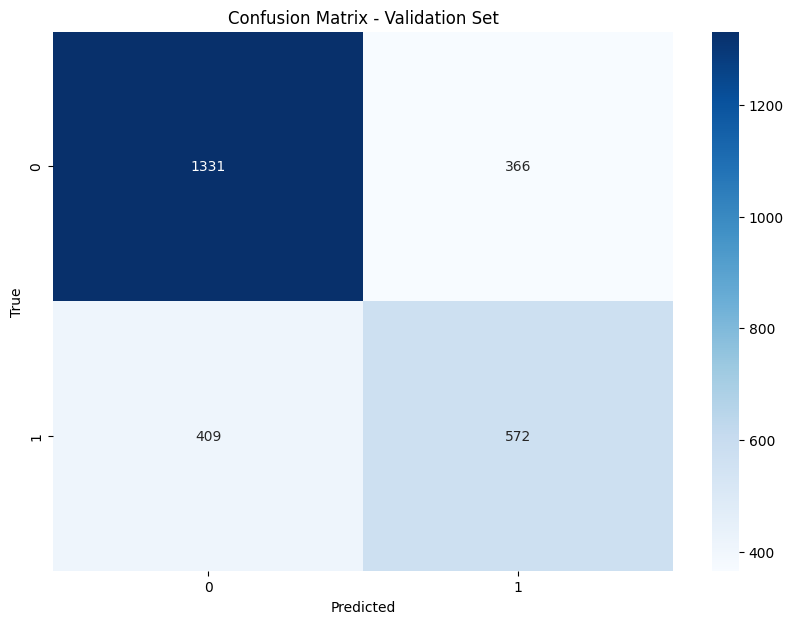

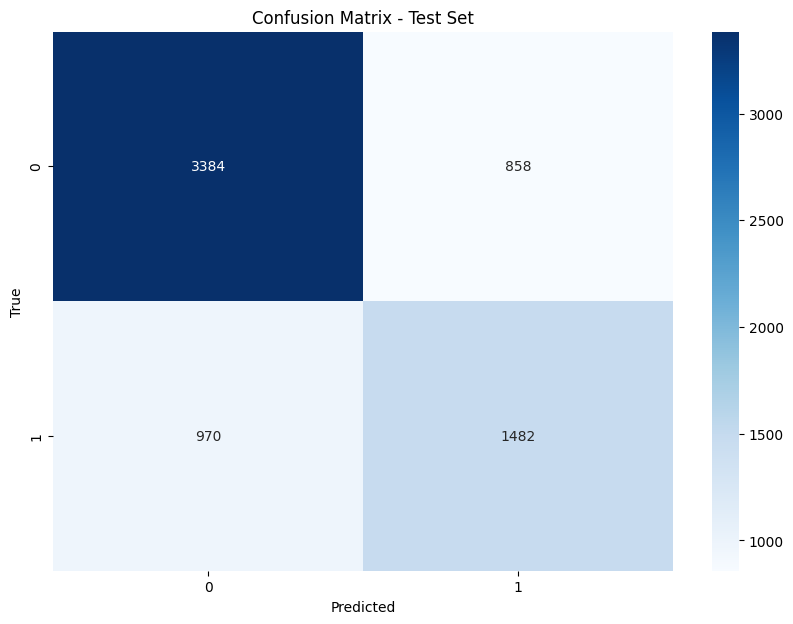

In [ ]:
evaluate_model(history, model, X_train_scaled, X_val_scaled, X_test_scaled, y_train, y_val, y_test)

Clear overfitting (high variance) existed and underfitting (high bias) and clear flactiuations
-> start to solve overfiting & flactiuations with regularization

L1 & L2 regularization

In [24]:
from tensorflow.keras import regularizers

In [ ]:
model = keras.models.Sequential([
    keras.layers.Dense(50, kernel_initializer='lecun_normal', activation='selu', input_shape=(22,),
                       kernel_regularizer=regularizers.l1_l2(l1=0.01, l2=0.01)),
    keras.layers.Dense(50, kernel_initializer='lecun_normal', activation='selu',
                       kernel_regularizer=regularizers.l1_l2(l1=0.01, l2=0.01)),
    keras.layers.Dense(50, kernel_initializer='lecun_normal', activation='selu',
                       kernel_regularizer=regularizers.l1_l2(l1=0.01, l2=0.01)),
    keras.layers.Dense(1, activation='sigmoid')
])

In [ ]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy', f1_score_metric])

In [ ]:
history = model.fit(X_train_scaled, y_train, epochs=30, validation_data = (X_val_scaled, y_val), batch_size=32)

Epoch 1/30
753/753 [==============================] - 3s 2ms/step - loss: 2.2414 - accuracy: 0.7128 - f1_score_metric: 0.5664 - val_loss: 0.6086 - val_accuracy: 0.7061 - val_f1_score_metric: 0.5837
Epoch 2/30
753/753 [==============================] - 2s 2ms/step - loss: 0.5811 - accuracy: 0.7187 - f1_score_metric: 0.6058 - val_loss: 0.5782 - val_accuracy: 0.7125 - val_f1_score_metric: 0.6011
Epoch 3/30
753/753 [==============================] - 2s 2ms/step - loss: 0.5675 - accuracy: 0.7200 - f1_score_metric: 0.6105 - val_loss: 0.5703 - val_accuracy: 0.7143 - val_f1_score_metric: 0.6065
Epoch 4/30
753/753 [==============================] - 2s 2ms/step - loss: 0.5619 - accuracy: 0.7248 - f1_score_metric: 0.6176 - val_loss: 0.5675 - val_accuracy: 0.7114 - val_f1_score_metric: 0.5984
Epoch 5/30
753/753 [==============================] - 2s 2ms/step - loss: 0.5582 - accuracy: 0.7224 - f1_score_metric: 0.6210 - val_loss: 0.5638 - val_accuracy: 0.7102 - val_f1_score_metric: 0.6092
Epoch 6/30

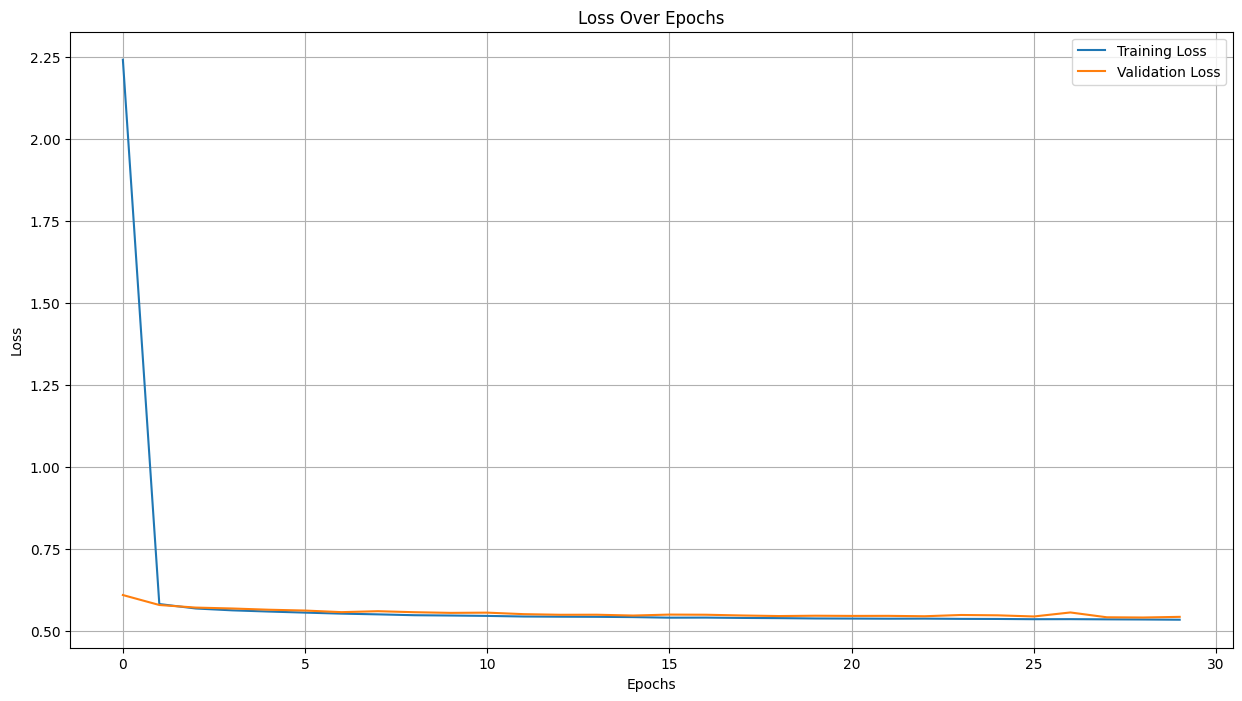

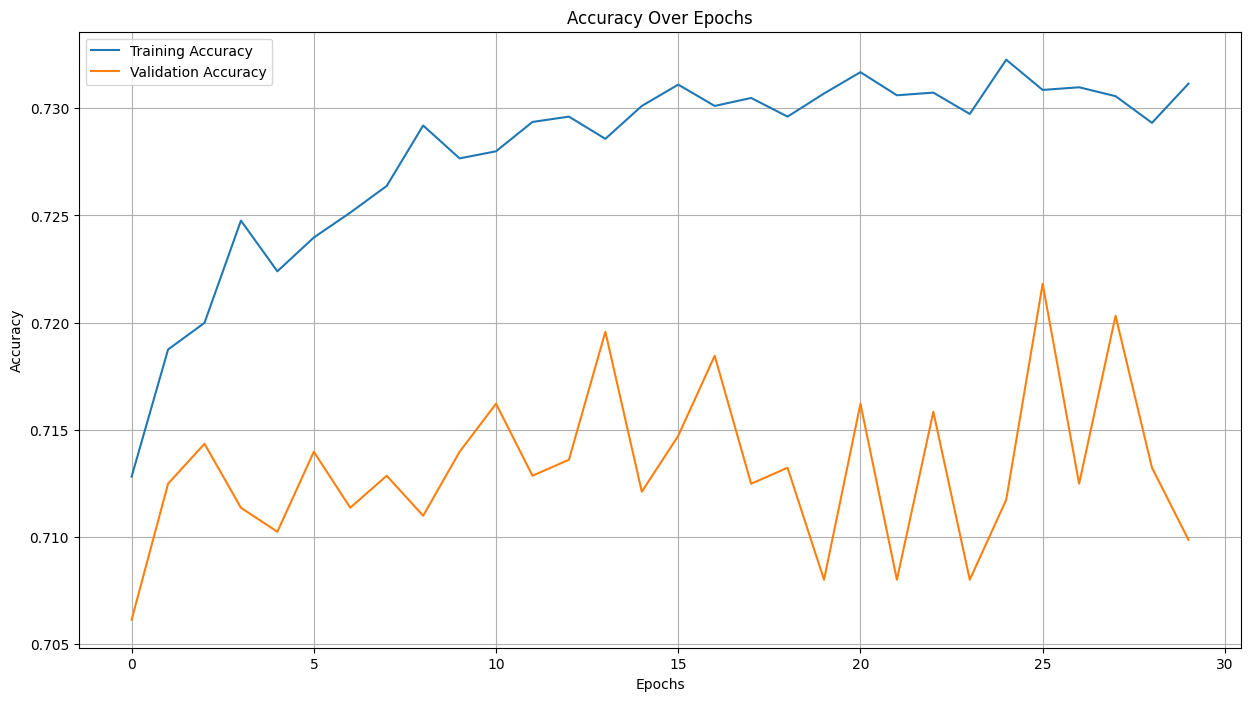

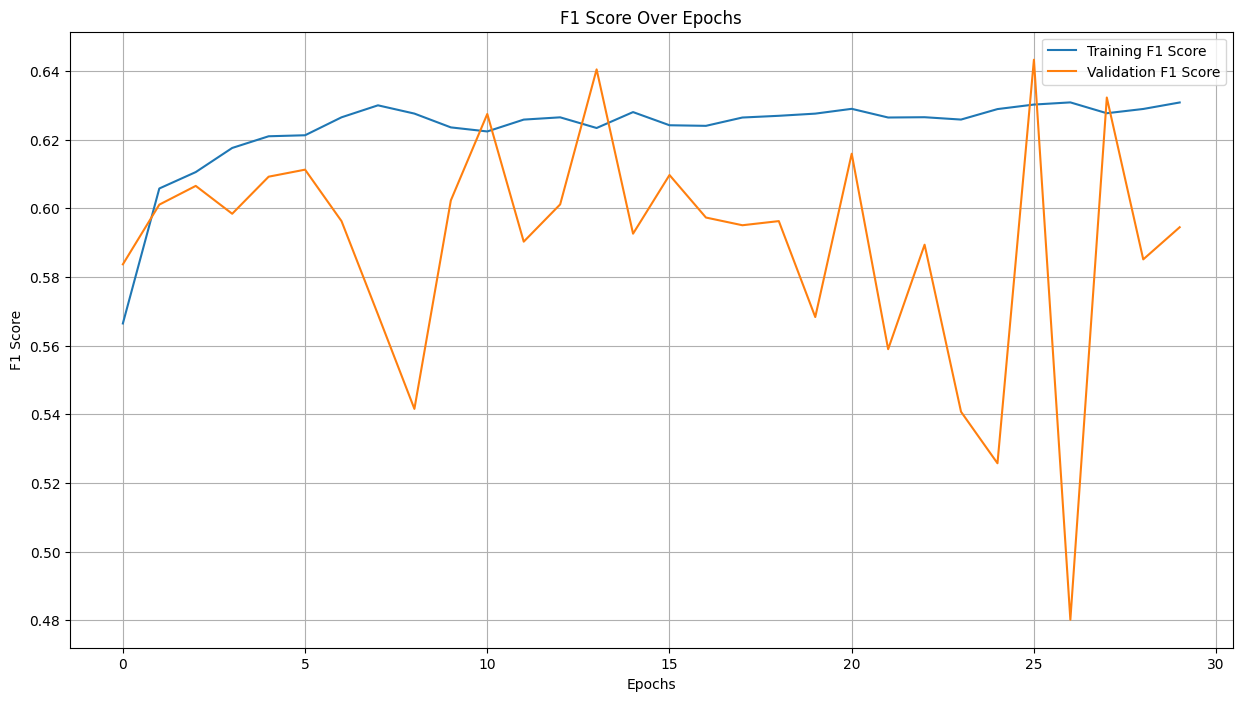

210/210 [==============================] - 0s 1ms/step
Classification Report - Training Set
              precision    recall  f1-score   support

           0       0.80      0.78      0.79     15270
           1       0.63      0.65      0.64      8825

    accuracy                           0.74     24095
   macro avg       0.72      0.72      0.72     24095
weighted avg       0.74      0.74      0.74     24095

Classification Report - Validation Set
              precision    recall  f1-score   support

           0       0.77      0.77      0.77      1697
           1       0.60      0.61      0.61       981

    accuracy                           0.71      2678
   macro avg       0.69      0.69      0.69      2678
weighted avg       0.71      0.71      0.71      2678

Classification Report - Test Set
              precision    recall  f1-score   support

           0       0.79      0.78      0.78      4242
           1       0.63      0.64      0.63      2452

    accuracy      

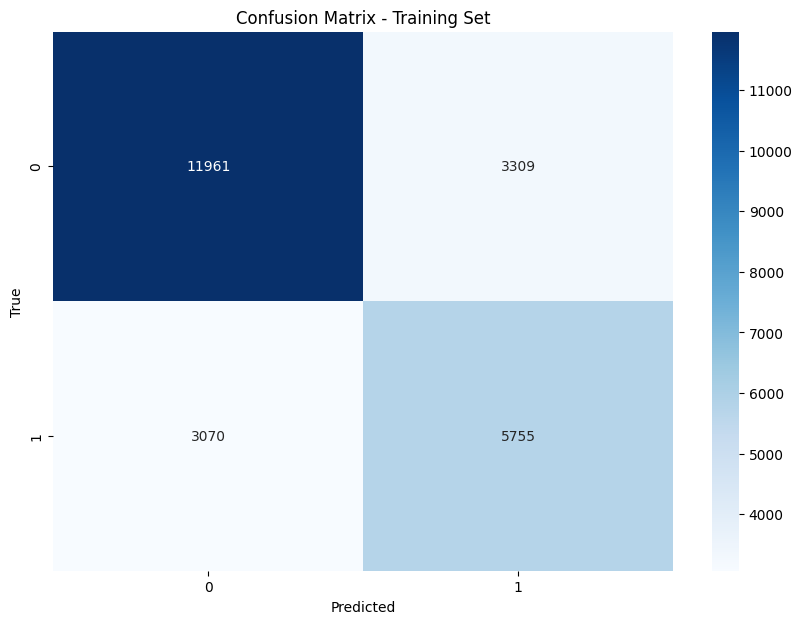

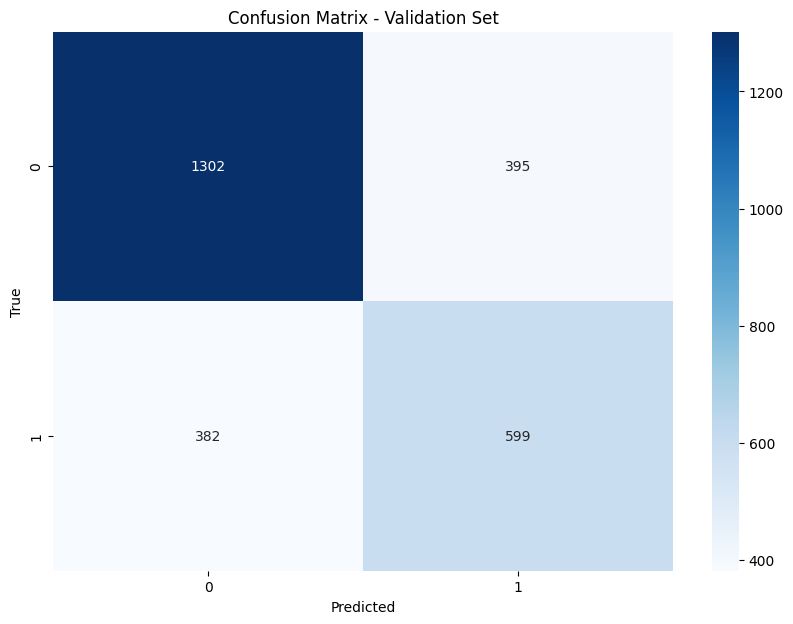

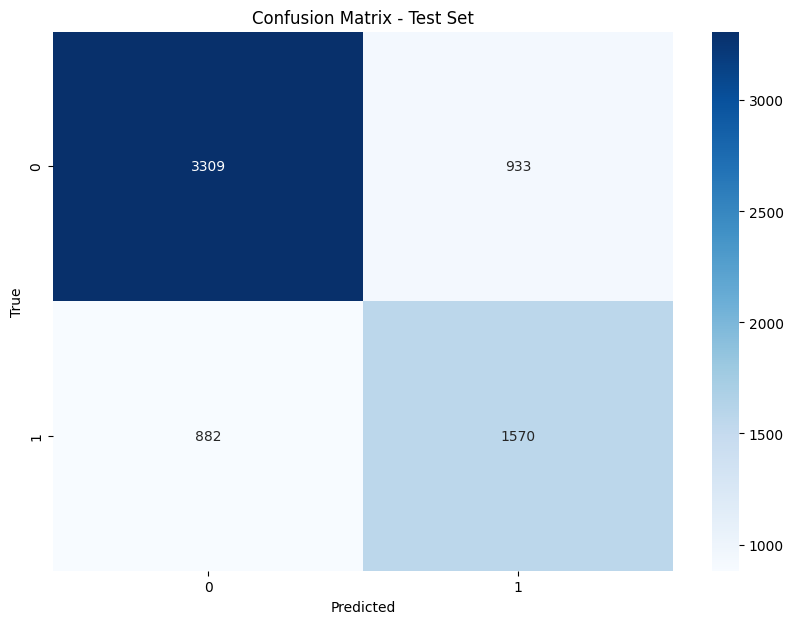

In [ ]:
evaluate_model(history, model, X_train_scaled, X_val_scaled, X_test_scaled, y_train, y_val, y_test)

\overfitting solved little bit but still this huge flactiuations in f1 but not bad in accuracy


use batch normalization But it is not recommended to use it with SELU (Self-Normalizing Behavior)
so we will use alpha Dropout

In [23]:
from tensorflow.keras.layers import AlphaDropout

In [ ]:
model = keras.models.Sequential([
    keras.layers.Dense(50, kernel_initializer='lecun_normal', activation='selu', input_shape=(22,),
                       kernel_regularizer=regularizers.l2(0.01)),
    AlphaDropout(0.1),

    keras.layers.Dense(50, kernel_initializer='lecun_normal', activation='selu',
                       kernel_regularizer=regularizers.l2(0.01)),
    AlphaDropout(0.1),

    keras.layers.Dense(50, kernel_initializer='lecun_normal', activation='selu',
                       kernel_regularizer=regularizers.l2(0.01)),
    AlphaDropout(0.1),

    keras.layers.Dense(1, activation='sigmoid')
])

In [ ]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy', f1_score_metric])

In [ ]:
history= model.fit(X_train_scaled, y_train, epochs=30, validation_data = (X_val_scaled, y_val), batch_size=32)

Epoch 1/30
753/753 [==============================] - 3s 3ms/step - loss: 1.0611 - accuracy: 0.6871 - f1_score_metric: 0.5523 - val_loss: 0.6409 - val_accuracy: 0.7099 - val_f1_score_metric: 0.6299
Epoch 2/30
753/753 [==============================] - 2s 2ms/step - loss: 0.5971 - accuracy: 0.7033 - f1_score_metric: 0.5730 - val_loss: 0.5703 - val_accuracy: 0.7140 - val_f1_score_metric: 0.6444
Epoch 3/30
753/753 [==============================] - 2s 2ms/step - loss: 0.5700 - accuracy: 0.7062 - f1_score_metric: 0.5802 - val_loss: 0.5898 - val_accuracy: 0.7091 - val_f1_score_metric: 0.6650
Epoch 4/30
753/753 [==============================] - 2s 2ms/step - loss: 0.5665 - accuracy: 0.7088 - f1_score_metric: 0.5847 - val_loss: 0.5516 - val_accuracy: 0.7155 - val_f1_score_metric: 0.6533
Epoch 5/30
753/753 [==============================] - 2s 2ms/step - loss: 0.5648 - accuracy: 0.7067 - f1_score_metric: 0.5830 - val_loss: 0.5935 - val_accuracy: 0.7013 - val_f1_score_metric: 0.6681
Epoch 6/30

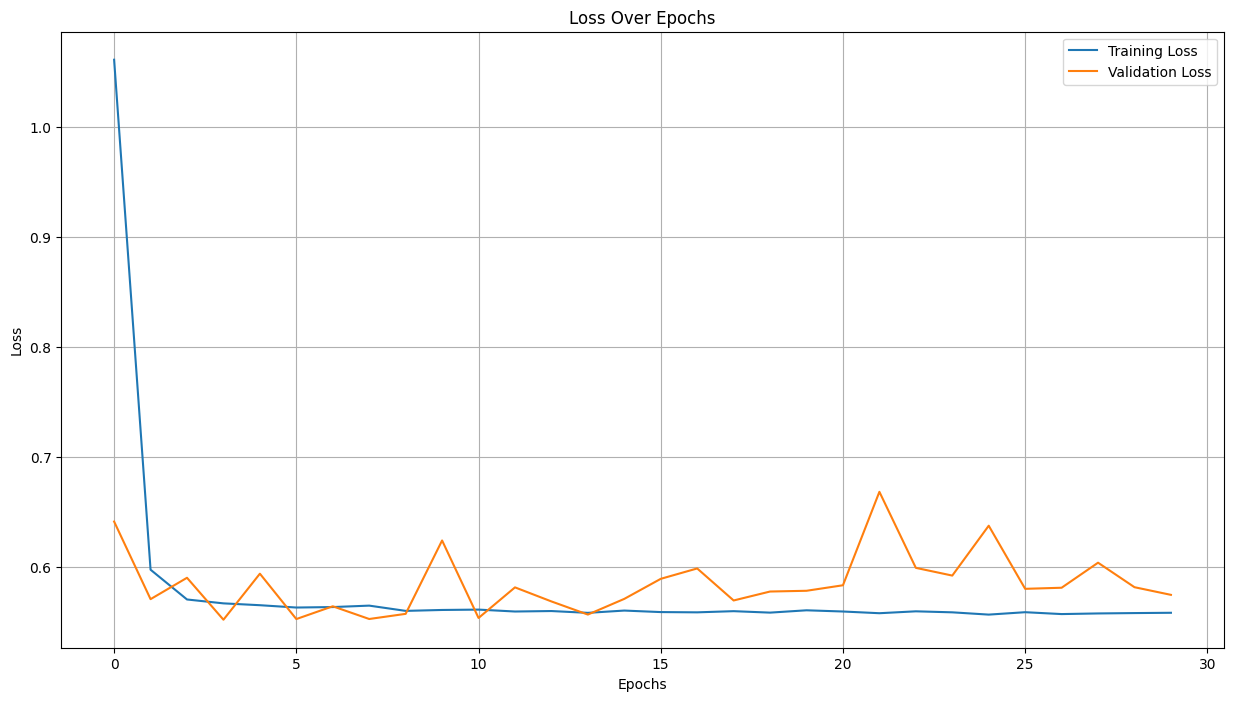

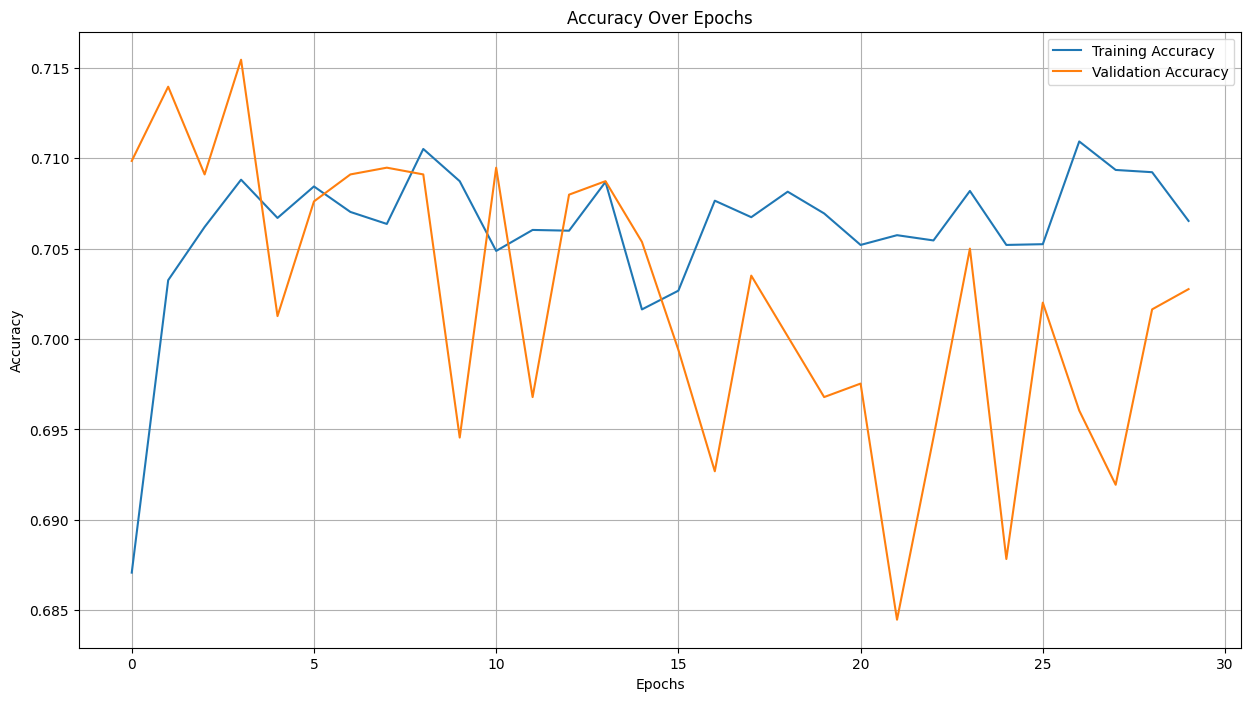

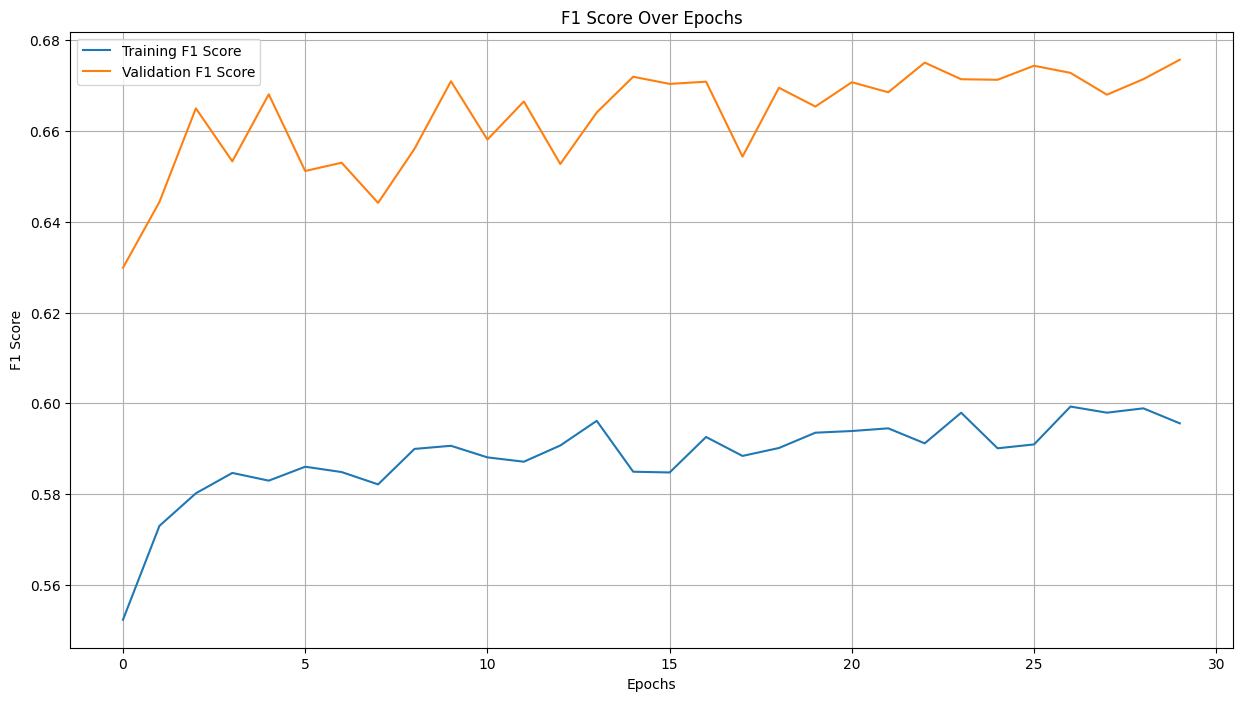

210/210 [==============================] - 0s 1ms/step
Classification Report - Training Set
              precision    recall  f1-score   support

           0       0.89      0.61      0.73     15270
           1       0.56      0.87      0.69      8825

    accuracy                           0.71     24095
   macro avg       0.73      0.74      0.71     24095
weighted avg       0.77      0.71      0.71     24095

Classification Report - Validation Set
              precision    recall  f1-score   support

           0       0.89      0.60      0.72      1697
           1       0.56      0.88      0.68       981

    accuracy                           0.70      2678
   macro avg       0.73      0.74      0.70      2678
weighted avg       0.77      0.70      0.71      2678

Classification Report - Test Set
              precision    recall  f1-score   support

           0       0.89      0.61      0.72      4242
           1       0.56      0.88      0.69      2452

    accuracy      

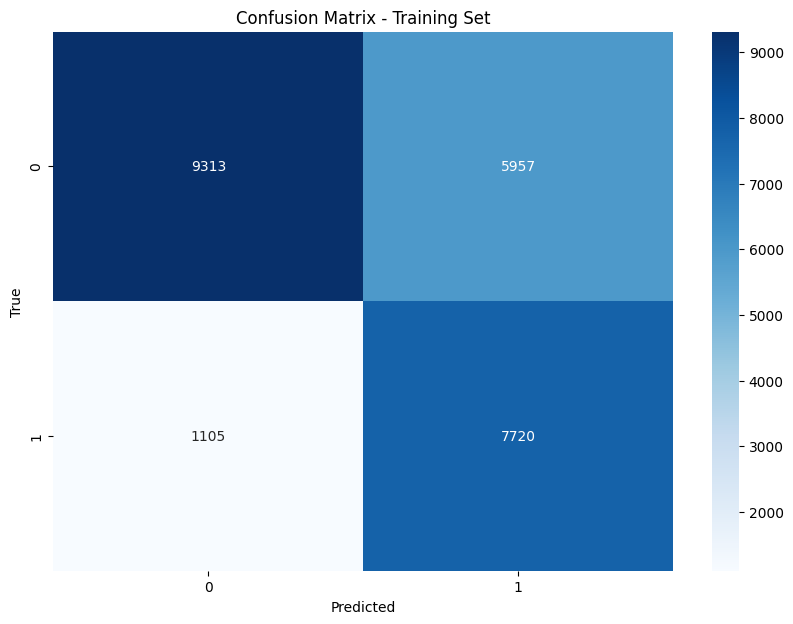

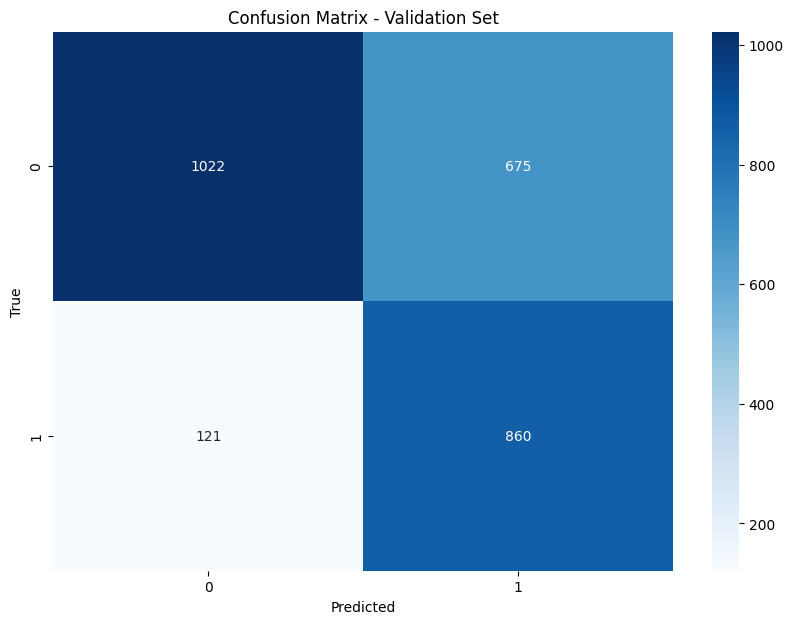

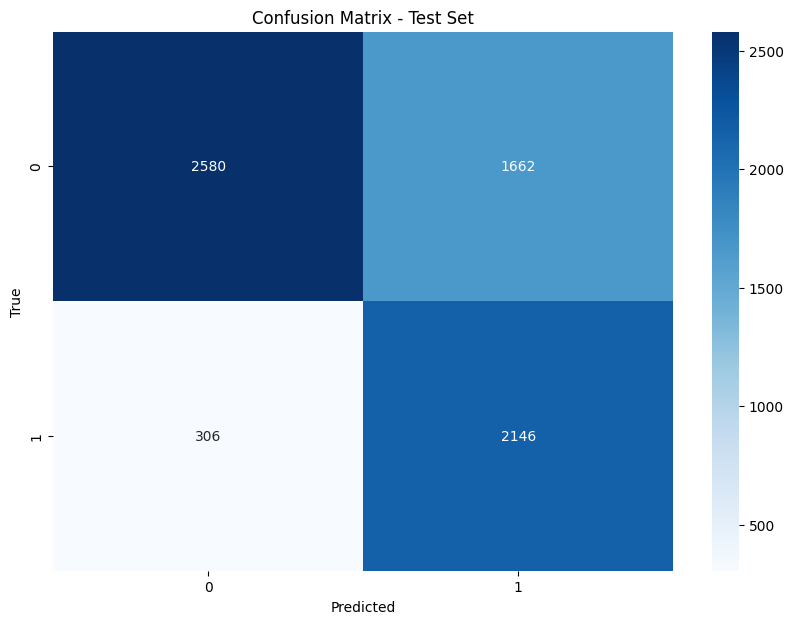

In [ ]:
evaluate_model(history, model, X_train_scaled, X_val_scaled, X_test_scaled, y_train, y_val, y_test)

overfitting solved mostly and good model performance

use more complex model

In [27]:
model = keras.models.Sequential([
    keras.layers.Dense(50, kernel_initializer='lecun_normal', activation='selu', input_shape=(22,),
                       kernel_regularizer=regularizers.l2(0.01)),
    AlphaDropout(0.1),

    keras.layers.Dense(50, kernel_initializer='lecun_normal', activation='selu',
                       kernel_regularizer=regularizers.l2(0.01)),
    AlphaDropout(0.1),

    keras.layers.Dense(50, kernel_initializer='lecun_normal', activation='selu',
                       kernel_regularizer=regularizers.l2(0.01)),
    AlphaDropout(0.1),
    keras.layers.Dense(50, kernel_initializer='lecun_normal', activation='selu',
                       kernel_regularizer=regularizers.l2(0.01)),
    AlphaDropout(0.1),
    keras.layers.Dense(50, kernel_initializer='lecun_normal', activation='selu',
                       kernel_regularizer=regularizers.l2(0.01)),
    AlphaDropout(0.1),

    keras.layers.Dense(1, activation='sigmoid')
])

In [28]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy', f1_score_metric])

In [29]:
history= model.fit(X_train_scaled, y_train, epochs=30, validation_data = (X_val_scaled, y_val), batch_size=32)

Epoch 1/30
878/878 [==============================] - 4s 3ms/step - loss: 1.2367 - accuracy: 0.6885 - f1_score_metric: 0.5535 - val_loss: 0.6678 - val_accuracy: 0.7217 - val_f1_score_metric: 0.6840
Epoch 2/30
878/878 [==============================] - 2s 2ms/step - loss: 0.6113 - accuracy: 0.6945 - f1_score_metric: 0.5705 - val_loss: 0.6774 - val_accuracy: 0.7012 - val_f1_score_metric: 0.6813
Epoch 3/30
878/878 [==============================] - 2s 2ms/step - loss: 0.5940 - accuracy: 0.6953 - f1_score_metric: 0.5782 - val_loss: 0.5729 - val_accuracy: 0.7060 - val_f1_score_metric: 0.6819
Epoch 4/30
878/878 [==============================] - 2s 2ms/step - loss: 0.5921 - accuracy: 0.6968 - f1_score_metric: 0.5821 - val_loss: 0.6272 - val_accuracy: 0.7005 - val_f1_score_metric: 0.6800
Epoch 5/30
878/878 [==============================] - 2s 2ms/step - loss: 0.5917 - accuracy: 0.6955 - f1_score_metric: 0.5764 - val_loss: 0.6155 - val_accuracy: 0.7009 - val_f1_score_metric: 0.6836
Epoch 6/30

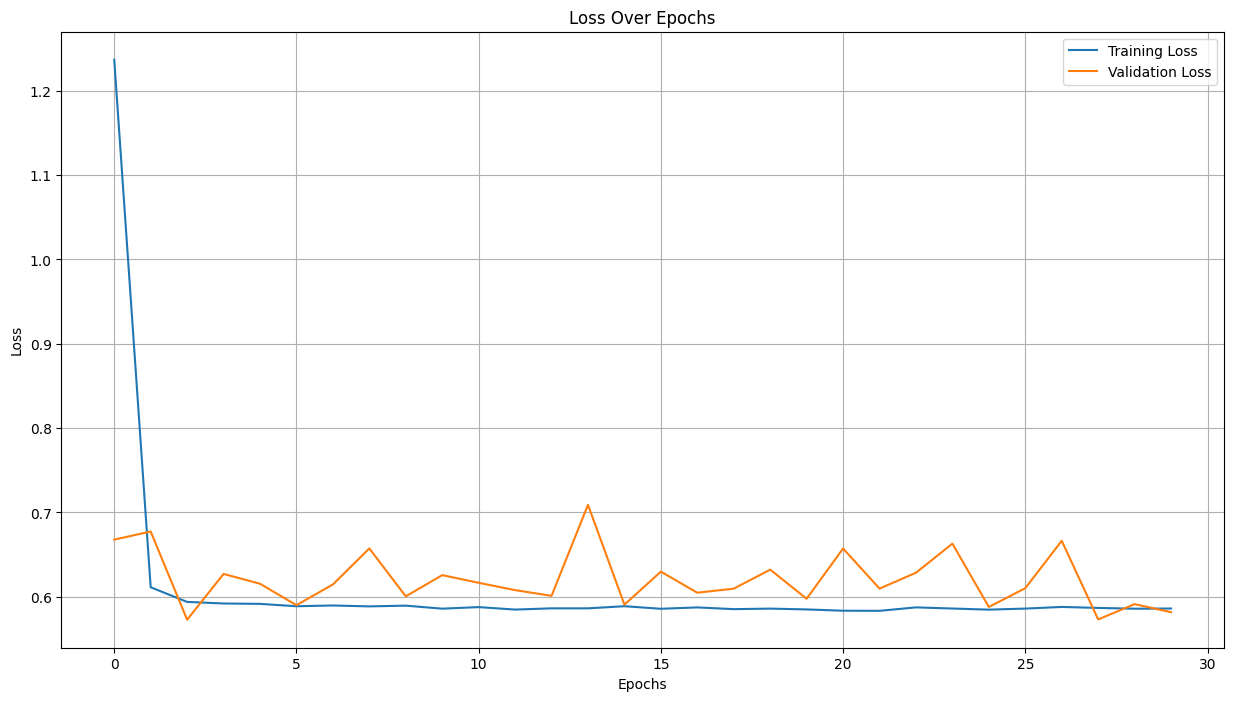

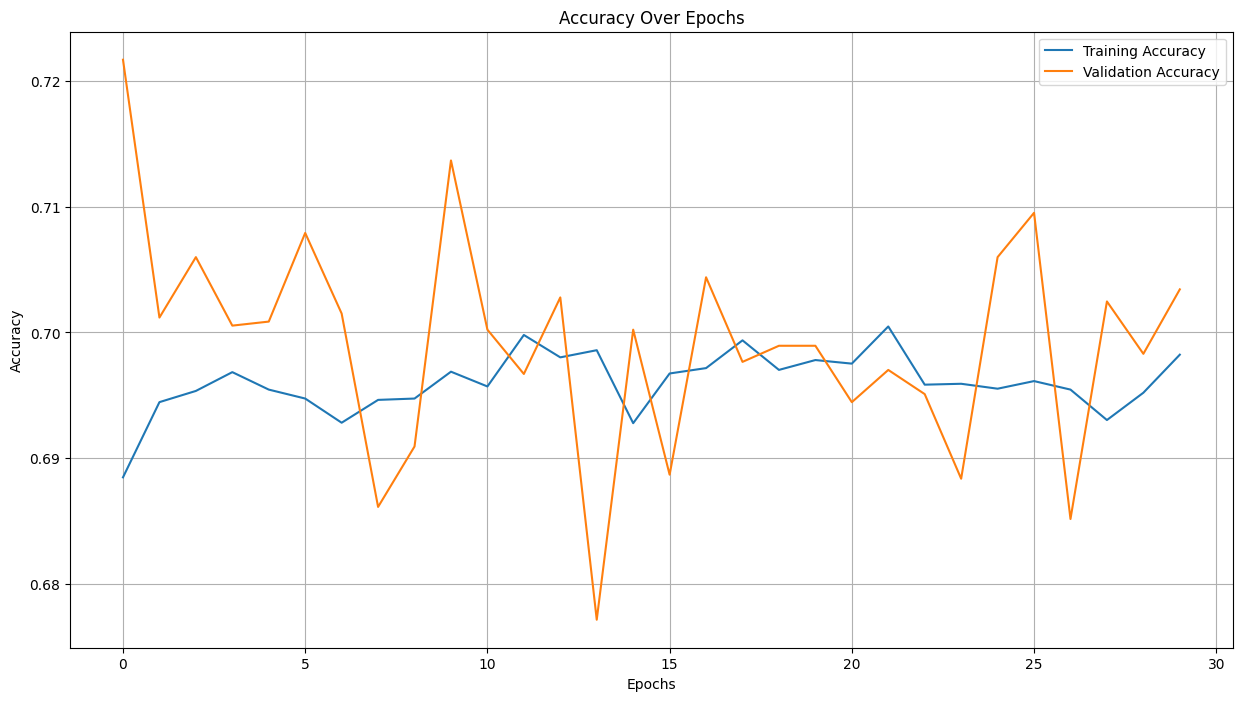

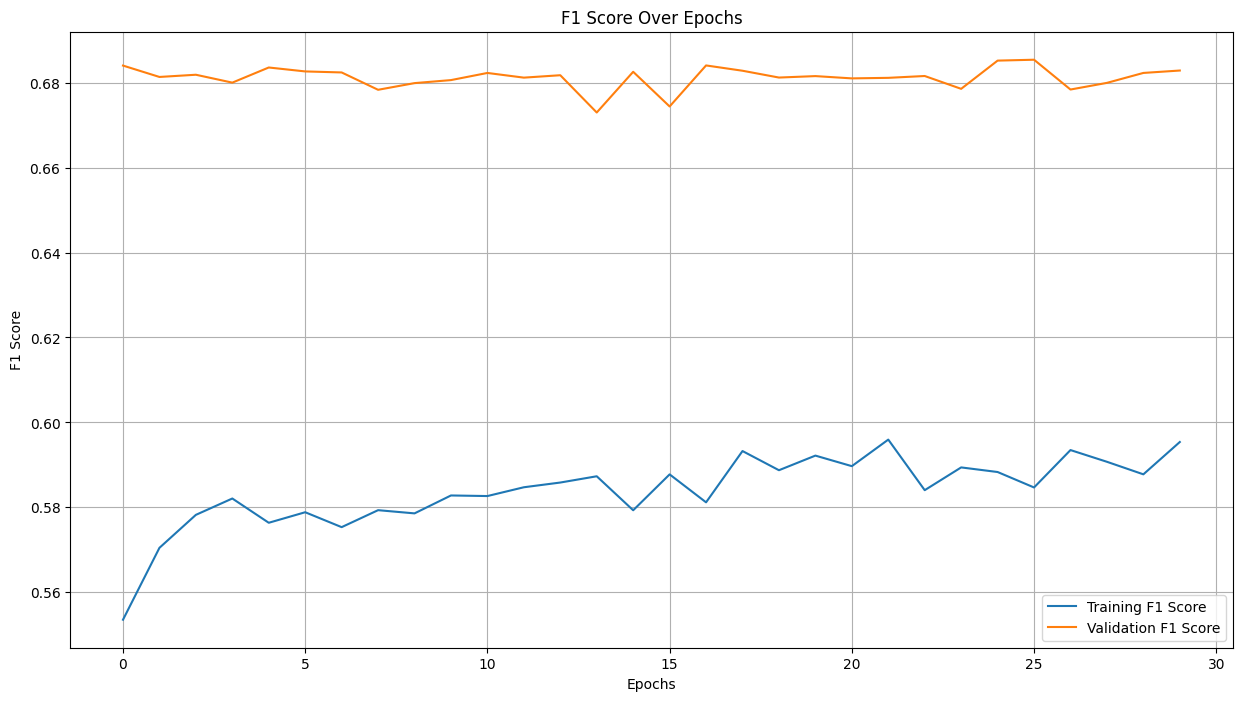

244/244 [==============================] - 0s 1ms/step
Classification Report - Training Set
              precision    recall  f1-score   support

           0       0.91      0.59      0.72     17760
           1       0.56      0.90      0.69     10308

    accuracy                           0.70     28068
   macro avg       0.73      0.74      0.70     28068
weighted avg       0.78      0.70      0.71     28068

Classification Report - Validation Set
              precision    recall  f1-score   support

           0       0.92      0.59      0.71      1973
           1       0.56      0.91      0.69      1146

    accuracy                           0.70      3119
   macro avg       0.74      0.75      0.70      3119
weighted avg       0.78      0.70      0.71      3119

Classification Report - Test Set
              precision    recall  f1-score   support

           0       0.90      0.57      0.70      4933
           1       0.55      0.89      0.68      2864

    accuracy      

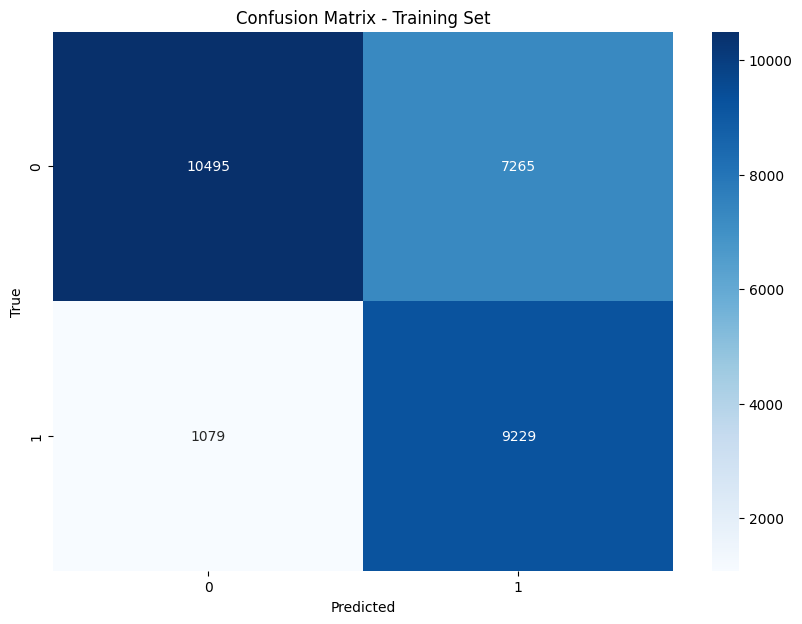

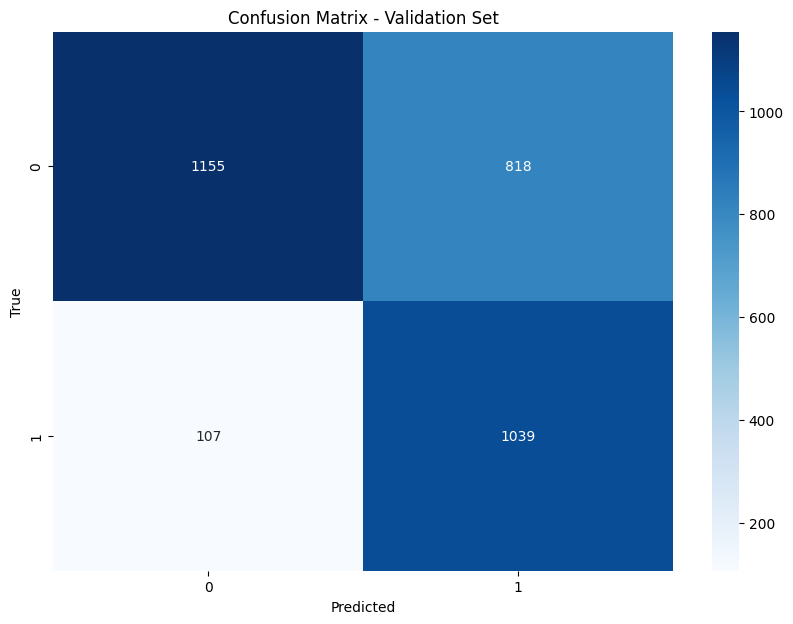

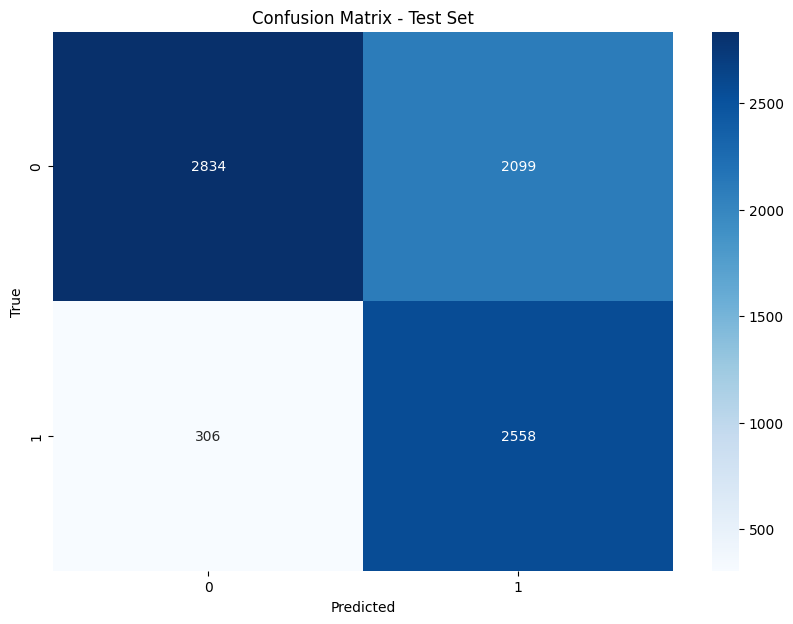

In [32]:
evaluate_model(history, model, X_train_scaled, X_val_scaled, X_test_scaled, y_train, y_val, y_test)

try another activation and intializer

In [33]:
from tensorflow.keras import layers, models

In [ ]:
model = models.Sequential([
    layers.Dense(50, kernel_initializer='he_normal', activation='relu', input_shape=(22,)),
    layers.Dense(50, kernel_initializer='he_normal', activation='relu'),
    layers.Dense(50, kernel_initializer='he_normal', activation='relu'),
    layers.Dense(1, activation='sigmoid')
])

In [ ]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy', f1_score_metric])

In [ ]:
history=model.fit(X_train_scaled, y_train, epochs=30, validation_data = (X_val_scaled, y_val), batch_size=32)

Epoch 1/30
753/753 [==============================] - 3s 2ms/step - loss: 0.5111 - accuracy: 0.7247 - f1_score_metric: 0.6032 - val_loss: 0.5103 - val_accuracy: 0.7140 - val_f1_score_metric: 0.5722
Epoch 2/30
753/753 [==============================] - 1s 2ms/step - loss: 0.4853 - accuracy: 0.7474 - f1_score_metric: 0.6409 - val_loss: 0.5015 - val_accuracy: 0.7214 - val_f1_score_metric: 0.6123
Epoch 3/30
753/753 [==============================] - 1s 2ms/step - loss: 0.4775 - accuracy: 0.7502 - f1_score_metric: 0.6478 - val_loss: 0.4993 - val_accuracy: 0.7259 - val_f1_score_metric: 0.5781
Epoch 4/30
753/753 [==============================] - 1s 2ms/step - loss: 0.4712 - accuracy: 0.7565 - f1_score_metric: 0.6542 - val_loss: 0.5087 - val_accuracy: 0.7226 - val_f1_score_metric: 0.5483
Epoch 5/30
753/753 [==============================] - 1s 2ms/step - loss: 0.4666 - accuracy: 0.7621 - f1_score_metric: 0.6615 - val_loss: 0.5037 - val_accuracy: 0.7296 - val_f1_score_metric: 0.6122
Epoch 6/30

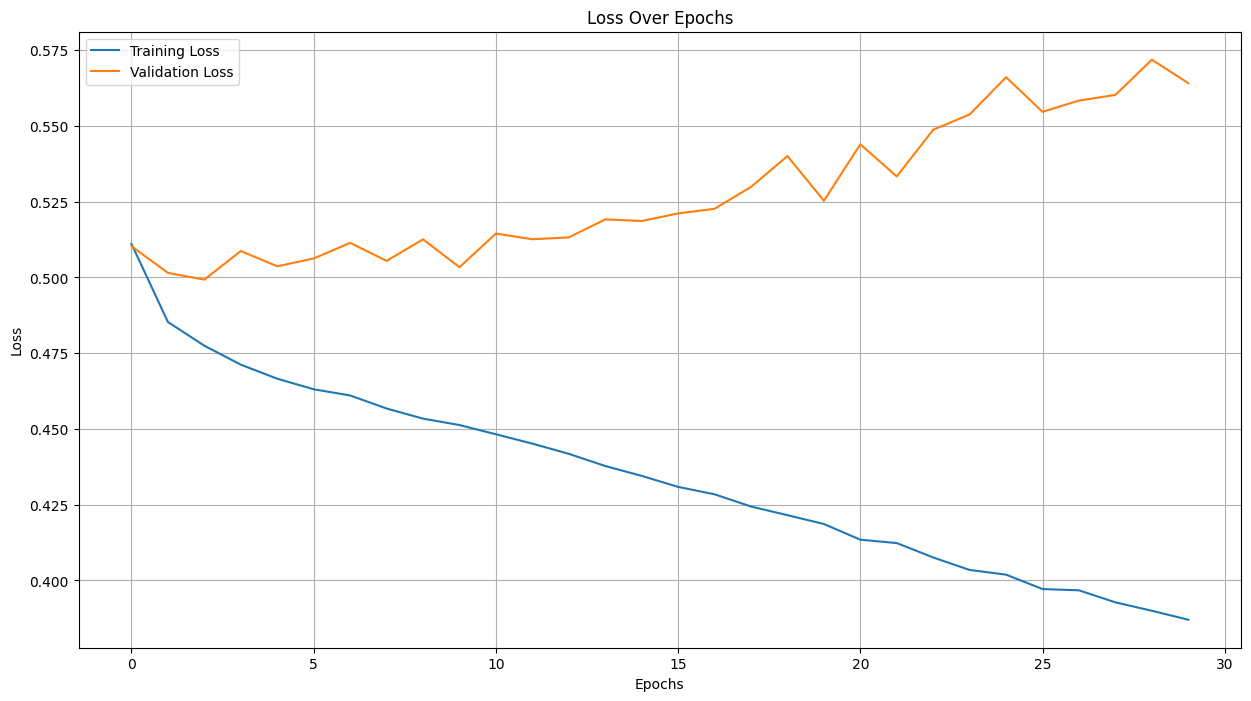

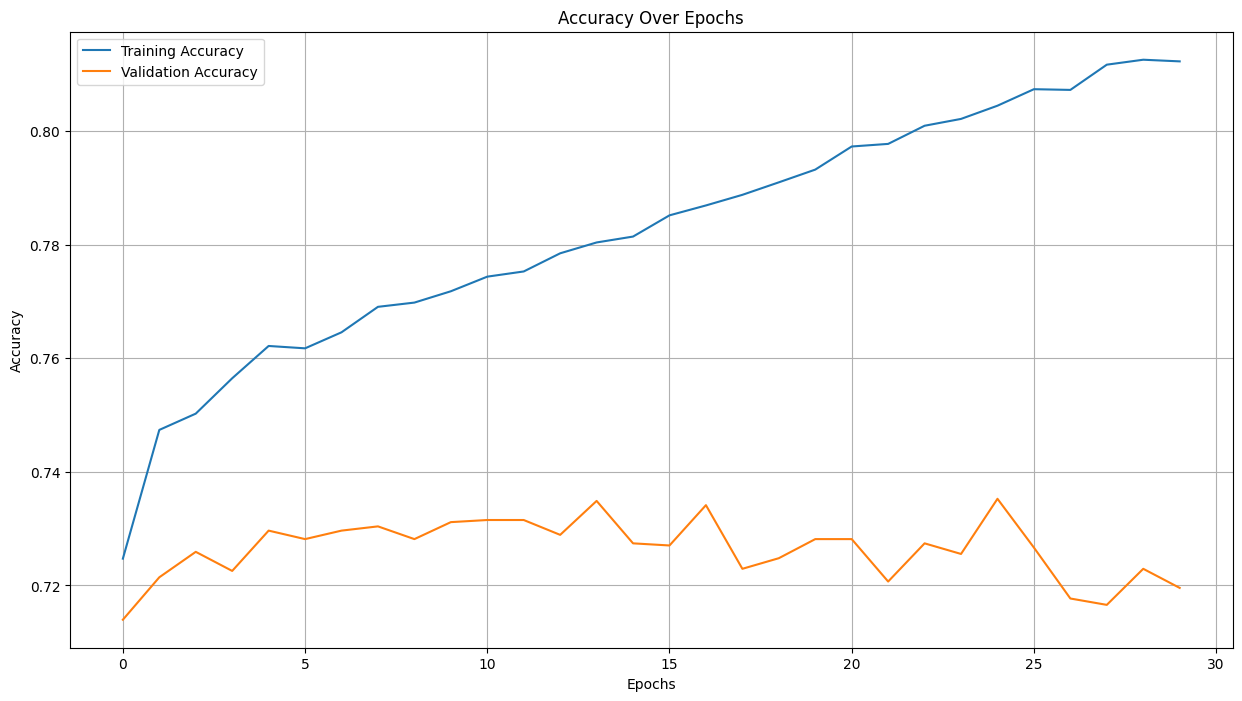

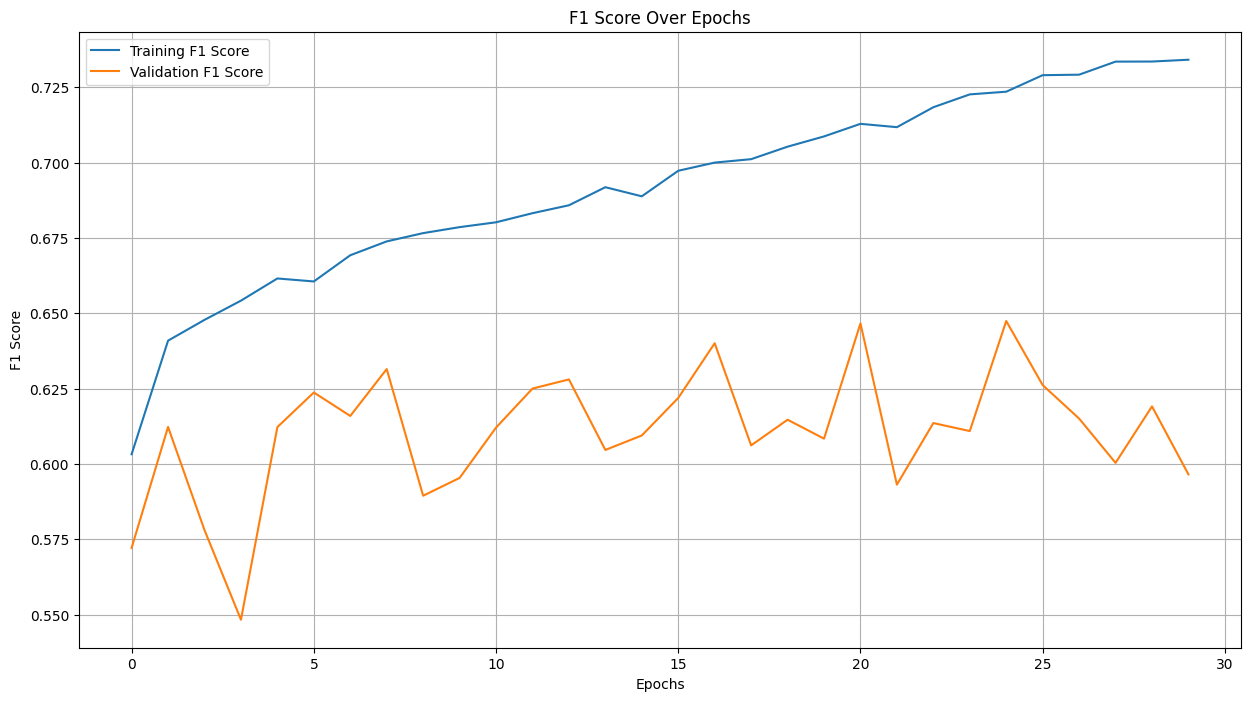

210/210 [==============================] - 0s 1ms/step
Classification Report - Training Set
              precision    recall  f1-score   support

           0       0.86      0.88      0.87     15270
           1       0.78      0.74      0.76      8825

    accuracy                           0.83     24095
   macro avg       0.82      0.81      0.81     24095
weighted avg       0.83      0.83      0.83     24095

Classification Report - Validation Set
              precision    recall  f1-score   support

           0       0.77      0.79      0.78      1697
           1       0.62      0.60      0.61       981

    accuracy                           0.72      2678
   macro avg       0.70      0.69      0.70      2678
weighted avg       0.72      0.72      0.72      2678

Classification Report - Test Set
              precision    recall  f1-score   support

           0       0.78      0.80      0.79      4242
           1       0.63      0.60      0.62      2452

    accuracy      

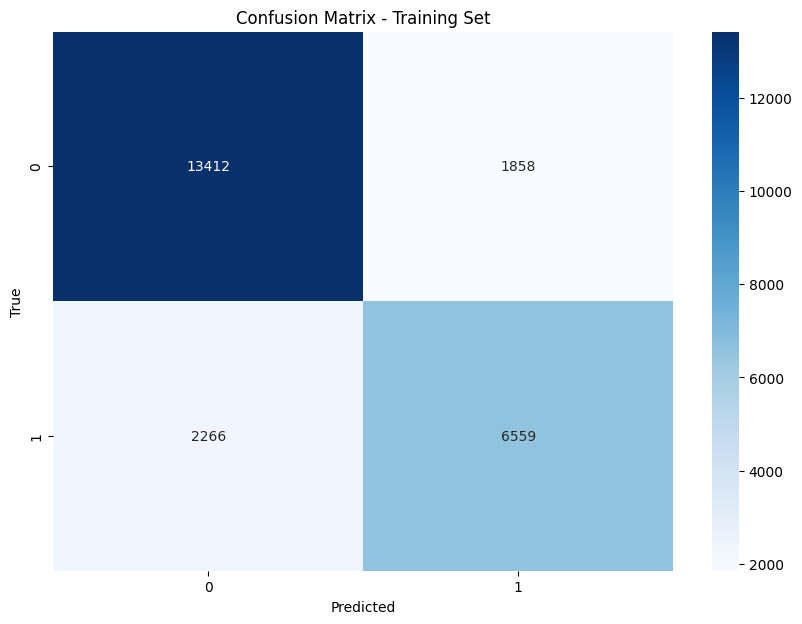

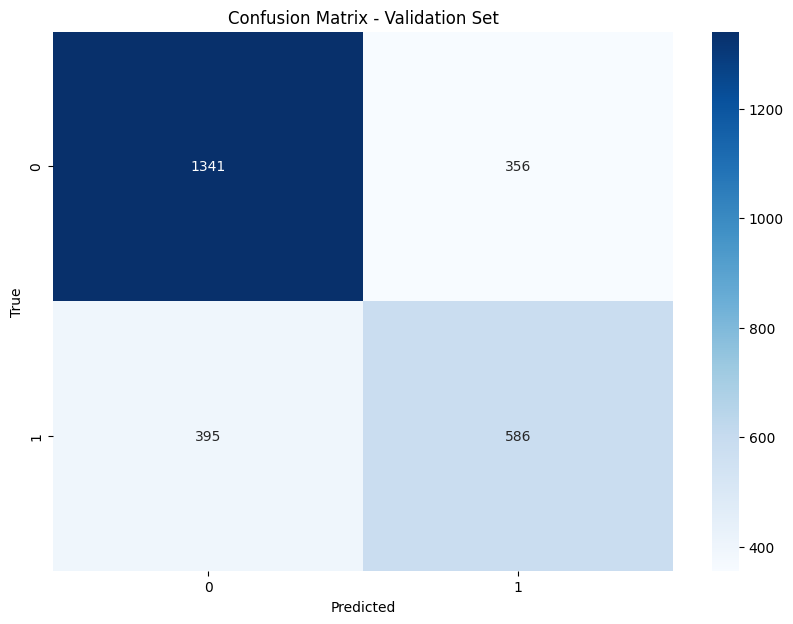

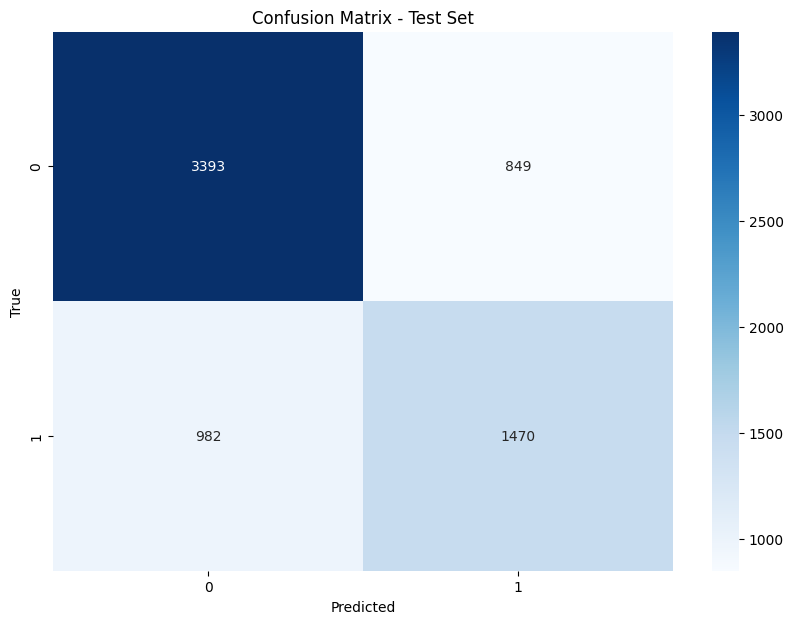

In [ ]:
evaluate_model(history, model, X_train_scaled, X_val_scaled, X_test_scaled, y_train, y_val, y_test)

More stable

adding regularization (L1 , L2 ) and batch normalization

In [ ]:
model = models.Sequential([
    layers.Dense(50, kernel_initializer='he_normal', kernel_regularizer=regularizers.l1_l2(l1=0.01, l2=0.01), input_shape=(22,)),
    layers.BatchNormalization(),
    layers.Activation('relu'),

    layers.Dense(50, kernel_initializer='he_normal', kernel_regularizer=regularizers.l1_l2(l1=0.01, l2=0.01)),
    layers.BatchNormalization(),
    layers.Activation('relu'),

    layers.Dense(50, kernel_initializer='he_normal', kernel_regularizer=regularizers.l1_l2(l1=0.01, l2=0.01)),
    layers.BatchNormalization(),
    layers.Activation('relu'),

    layers.Dense(1, activation='sigmoid')
])

In [ ]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy', f1_score_metric])

In [ ]:
history=model.fit(X_train_scaled, y_train, epochs=30, validation_data = (X_val_scaled, y_val), batch_size=32)

Epoch 1/30
753/753 [==============================] - 4s 3ms/step - loss: 4.2280 - accuracy: 0.7001 - f1_score_metric: 0.5548 - val_loss: 1.0054 - val_accuracy: 0.7009 - val_f1_score_metric: 0.4374
Epoch 2/30
753/753 [==============================] - 2s 3ms/step - loss: 0.6844 - accuracy: 0.7187 - f1_score_metric: 0.6110 - val_loss: 0.5816 - val_accuracy: 0.7072 - val_f1_score_metric: 0.6504
Epoch 3/30
753/753 [==============================] - 2s 3ms/step - loss: 0.5459 - accuracy: 0.7304 - f1_score_metric: 0.6313 - val_loss: 0.5346 - val_accuracy: 0.7162 - val_f1_score_metric: 0.5894
Epoch 4/30
753/753 [==============================] - 2s 3ms/step - loss: 0.5322 - accuracy: 0.7308 - f1_score_metric: 0.6336 - val_loss: 0.5626 - val_accuracy: 0.7020 - val_f1_score_metric: 0.6092
Epoch 5/30
753/753 [==============================] - 2s 3ms/step - loss: 0.5467 - accuracy: 0.7302 - f1_score_metric: 0.6277 - val_loss: 0.5547 - val_accuracy: 0.7240 - val_f1_score_metric: 0.6264
Epoch 6/30

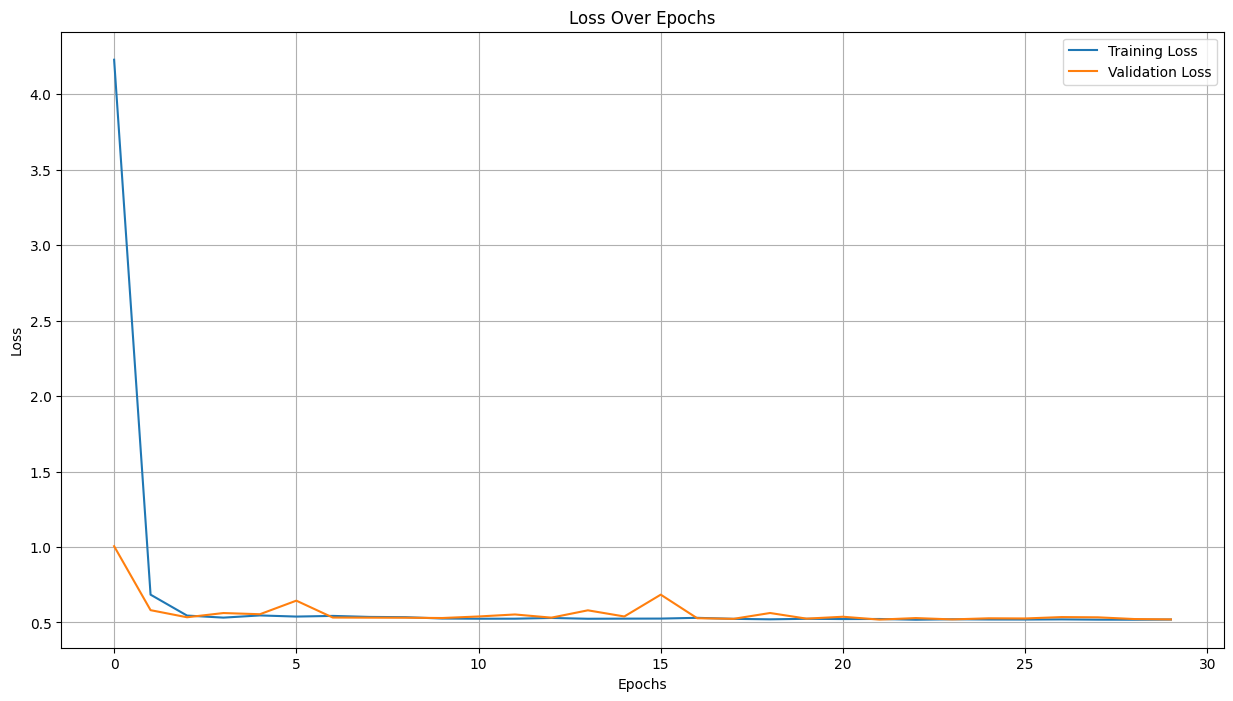

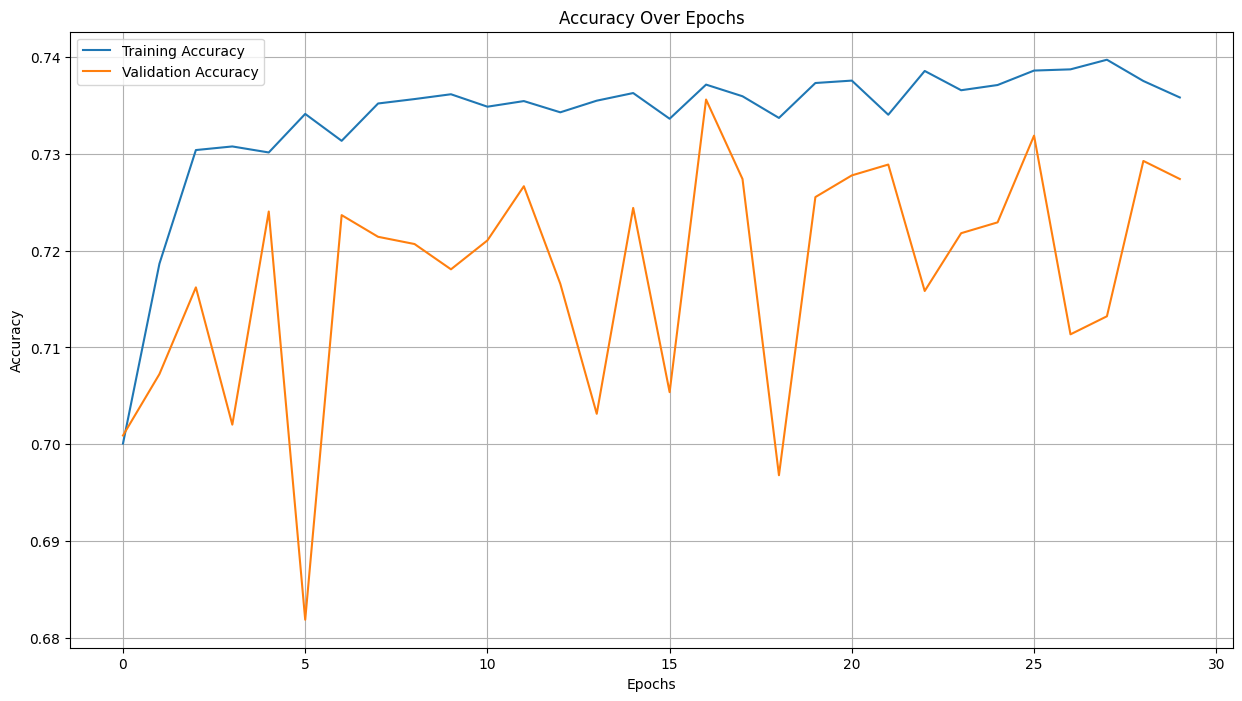

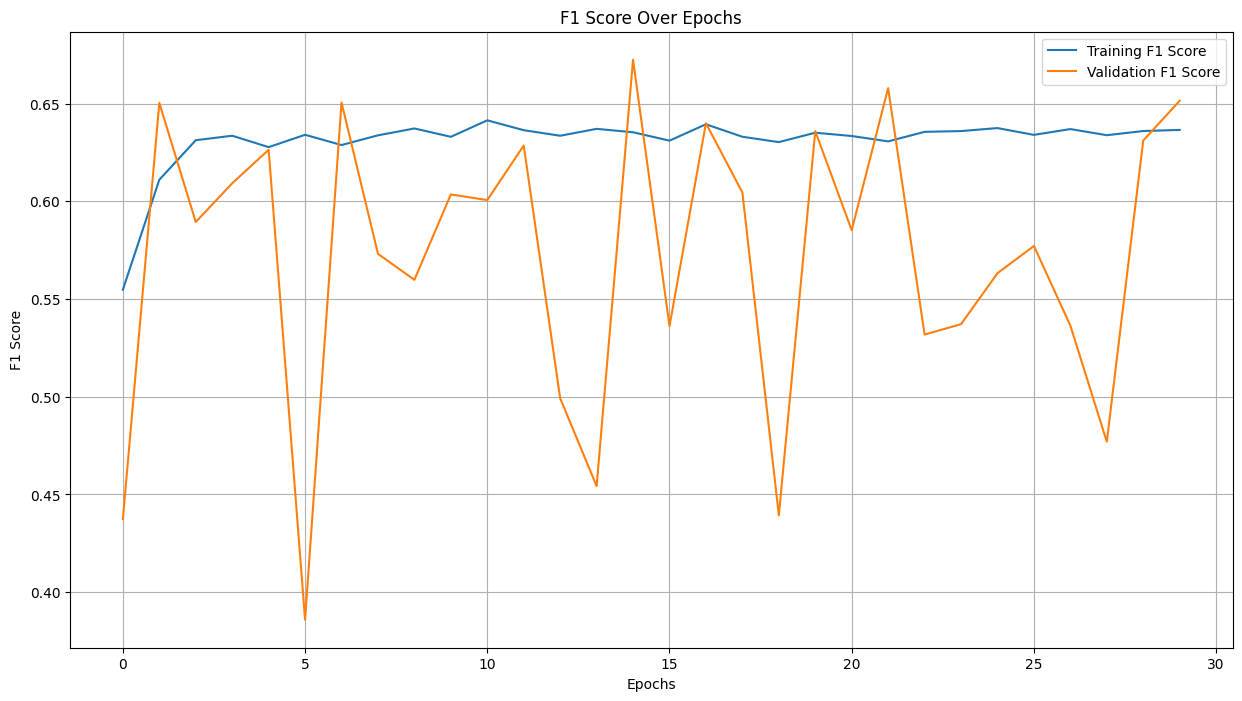

210/210 [==============================] - 0s 1ms/step
Classification Report - Training Set
              precision    recall  f1-score   support

           0       0.83      0.74      0.79     15270
           1       0.63      0.74      0.68      8825

    accuracy                           0.74     24095
   macro avg       0.73      0.74      0.73     24095
weighted avg       0.76      0.74      0.75     24095

Classification Report - Validation Set
              precision    recall  f1-score   support

           0       0.82      0.73      0.77      1697
           1       0.61      0.73      0.66       981

    accuracy                           0.73      2678
   macro avg       0.71      0.73      0.72      2678
weighted avg       0.74      0.73      0.73      2678

Classification Report - Test Set
              precision    recall  f1-score   support

           0       0.83      0.74      0.78      4242
           1       0.62      0.74      0.67      2452

    accuracy      

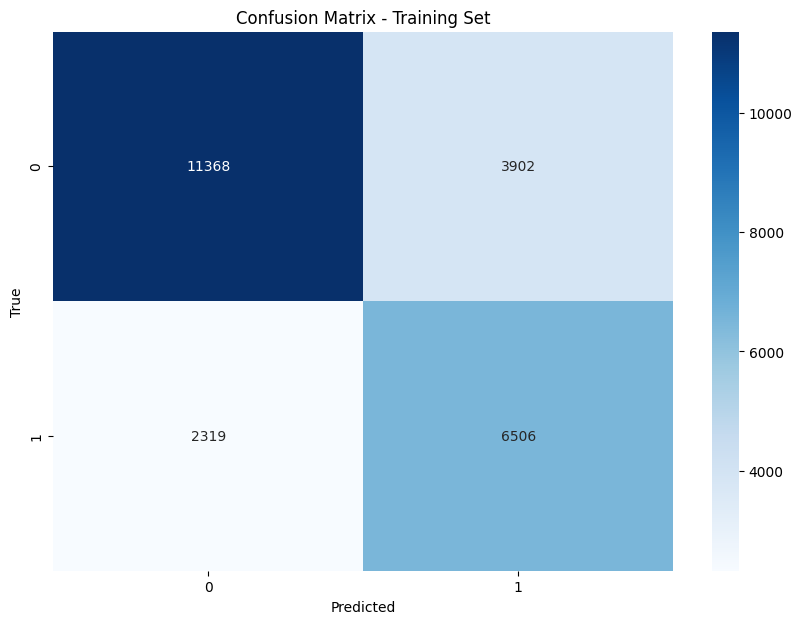

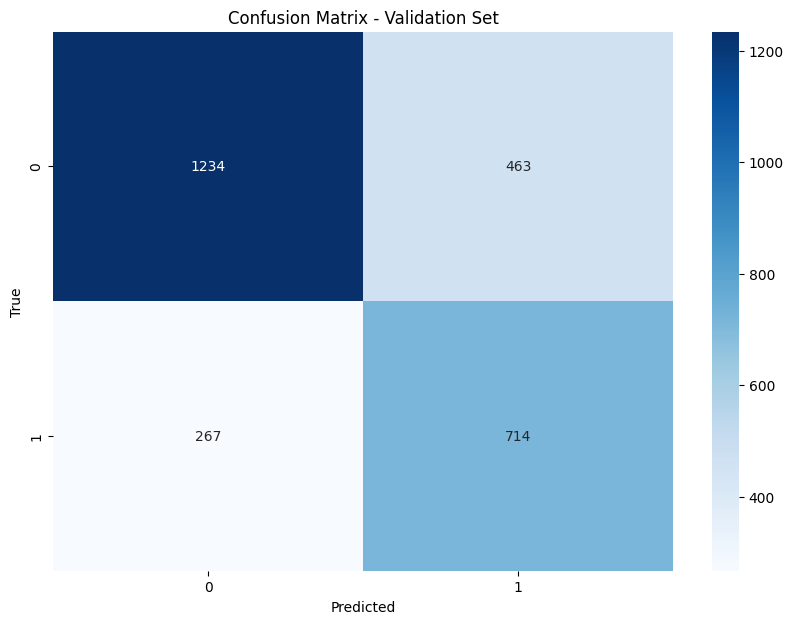

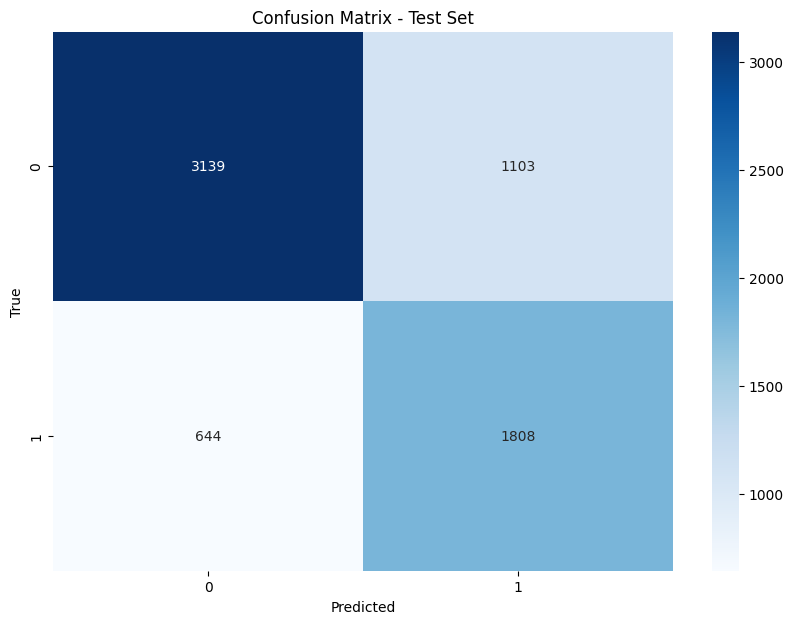

In [ ]:
evaluate_model(history, model, X_train_scaled, X_val_scaled, X_test_scaled, y_train, y_val, y_test)

no more training can help (loss is stable no decreasing)



In [39]:
from keras.layers import BatchNormalization

In [48]:
model = keras.models.Sequential([
    keras.layers.Dense(50, kernel_initializer='he_normal', activation=None, input_shape=(22,),
                       kernel_regularizer=regularizers.l1_l2(l1=0.01, l2=0.01)),
    BatchNormalization(),
    keras.layers.Activation('elu'),

    keras.layers.Dense(50, kernel_initializer='he_normal', activation=None,
                       kernel_regularizer=regularizers.l1_l2(l1=0.01, l2=0.01)),
    BatchNormalization(),
    keras.layers.Activation('elu'),

    keras.layers.Dense(50, kernel_initializer='he_normal', activation=None,
                       kernel_regularizer=regularizers.l1_l2(l1=0.01, l2=0.01)),
    BatchNormalization(),
    keras.layers.Activation('elu'),

    keras.layers.Dense(50, kernel_initializer='he_normal', activation=None,
                       kernel_regularizer=regularizers.l1_l2(l1=0.01, l2=0.01)),
    BatchNormalization(),
    keras.layers.Activation('elu'),

    keras.layers.Dense(50, kernel_initializer='he_normal', activation=None,
                       kernel_regularizer=regularizers.l1_l2(l1=0.01, l2=0.01)),
    BatchNormalization(),
    keras.layers.Activation('elu'),

    keras.layers.Dense(1, activation='sigmoid')
])

In [49]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy', f1_score_metric])

In [50]:
history=model.fit(X_train_scaled, y_train, epochs=30, validation_data = (X_val_scaled, y_val), batch_size=32)

Epoch 1/30
878/878 [==============================] - 6s 4ms/step - loss: 5.5504 - accuracy: 0.7036 - f1_score_metric: 0.5895 - val_loss: 0.7426 - val_accuracy: 0.6326 - val_f1_score_metric: 0.0000e+00
Epoch 2/30
878/878 [==============================] - 3s 3ms/step - loss: 0.5879 - accuracy: 0.7168 - f1_score_metric: 0.6142 - val_loss: 0.5541 - val_accuracy: 0.7313 - val_f1_score_metric: 0.6158
Epoch 3/30
878/878 [==============================] - 2s 3ms/step - loss: 0.5675 - accuracy: 0.7181 - f1_score_metric: 0.6251 - val_loss: 0.5492 - val_accuracy: 0.7361 - val_f1_score_metric: 0.5512
Epoch 4/30
878/878 [==============================] - 2s 3ms/step - loss: 0.5562 - accuracy: 0.7206 - f1_score_metric: 0.6264 - val_loss: 0.5325 - val_accuracy: 0.7451 - val_f1_score_metric: 0.6546
Epoch 5/30
878/878 [==============================] - 3s 3ms/step - loss: 0.5494 - accuracy: 0.7267 - f1_score_metric: 0.6365 - val_loss: 0.5247 - val_accuracy: 0.7483 - val_f1_score_metric: 0.6195
Epoch 

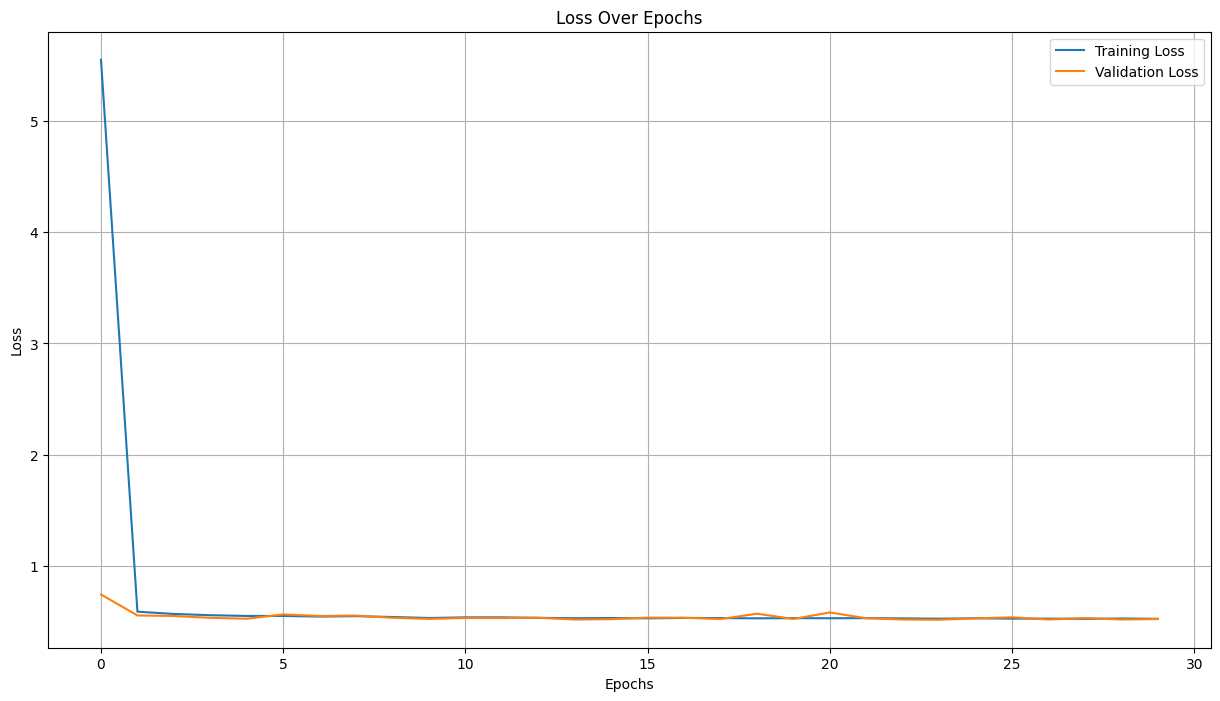

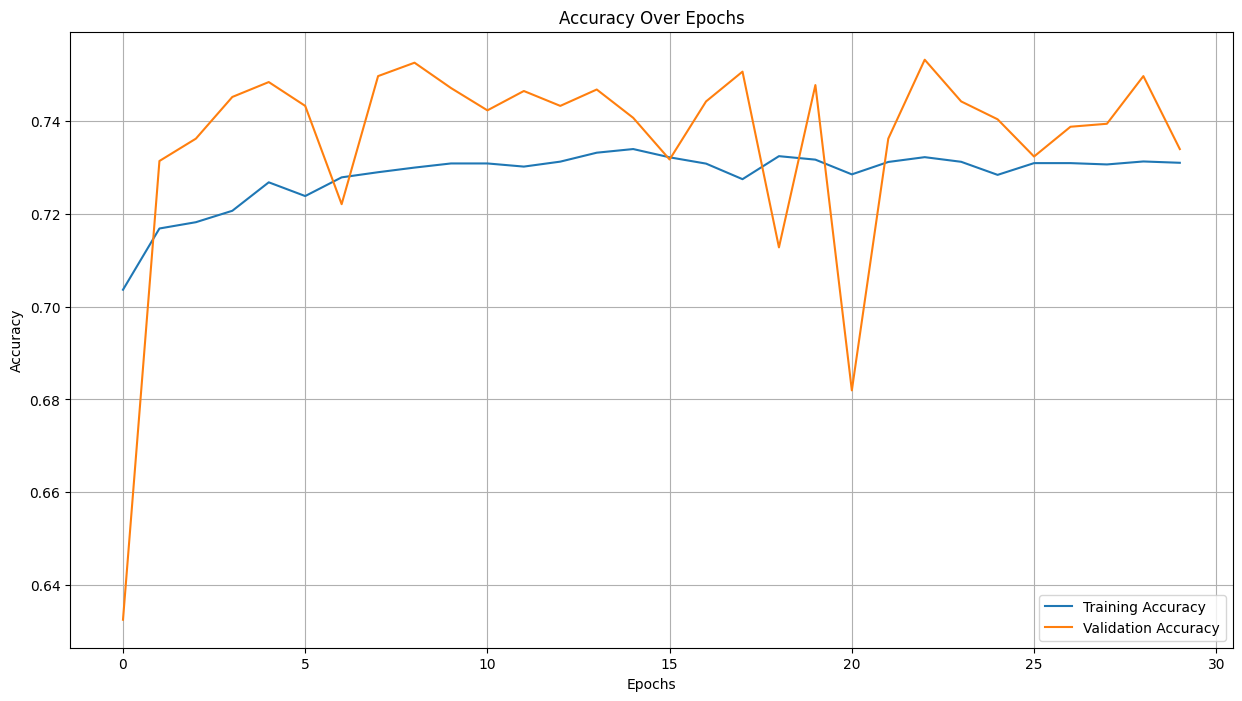

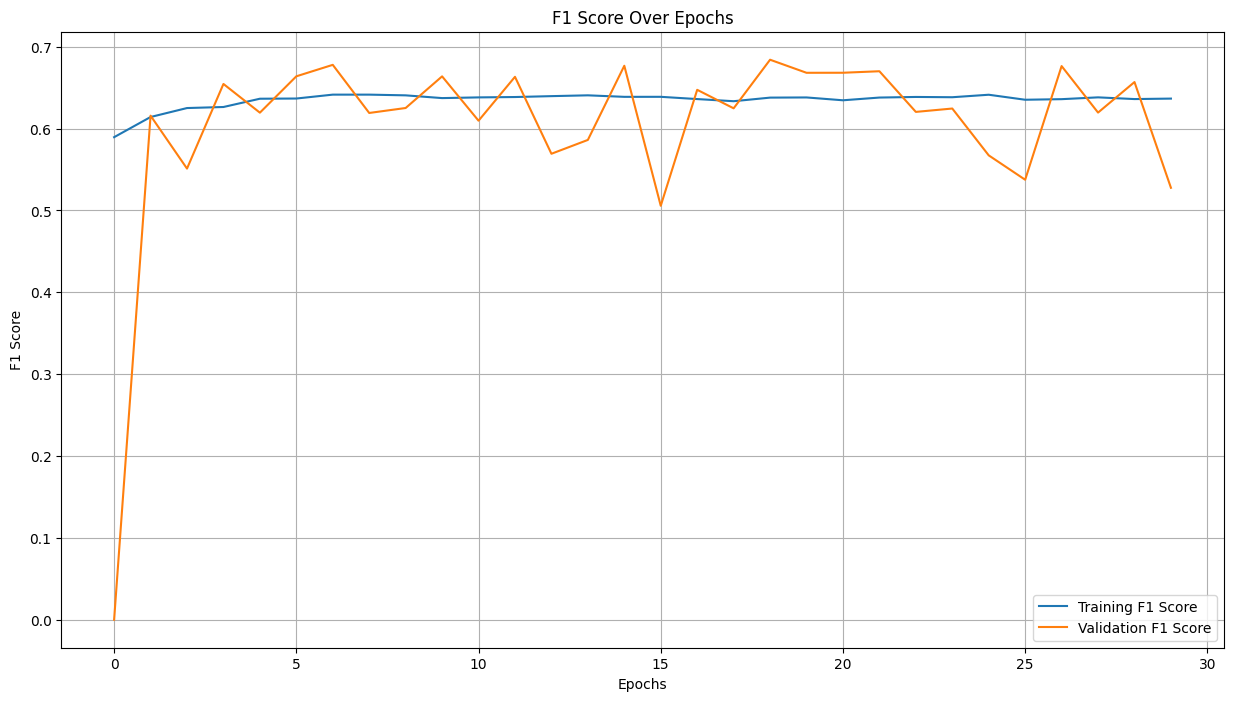

244/244 [==============================] - 0s 1ms/step
Classification Report - Training Set
              precision    recall  f1-score   support

           0       0.72      0.91      0.80     17760
           1       0.71      0.40      0.51     10308

    accuracy                           0.72     28068
   macro avg       0.72      0.65      0.66     28068
weighted avg       0.72      0.72      0.70     28068

Classification Report - Validation Set
              precision    recall  f1-score   support

           0       0.73      0.91      0.81      1973
           1       0.74      0.43      0.54      1146

    accuracy                           0.73      3119
   macro avg       0.73      0.67      0.68      3119
weighted avg       0.73      0.73      0.71      3119

Classification Report - Test Set
              precision    recall  f1-score   support

           0       0.72      0.90      0.80      4933
           1       0.71      0.40      0.51      2864

    accuracy      

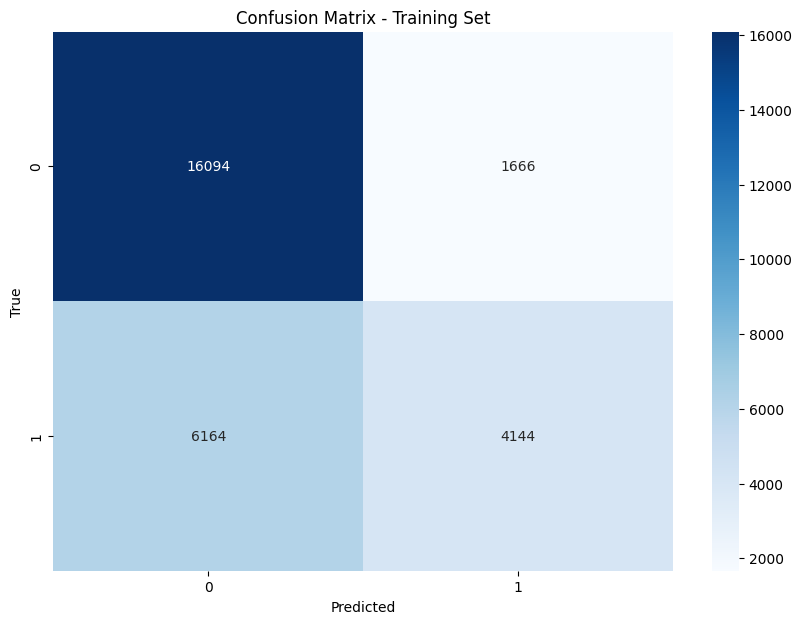

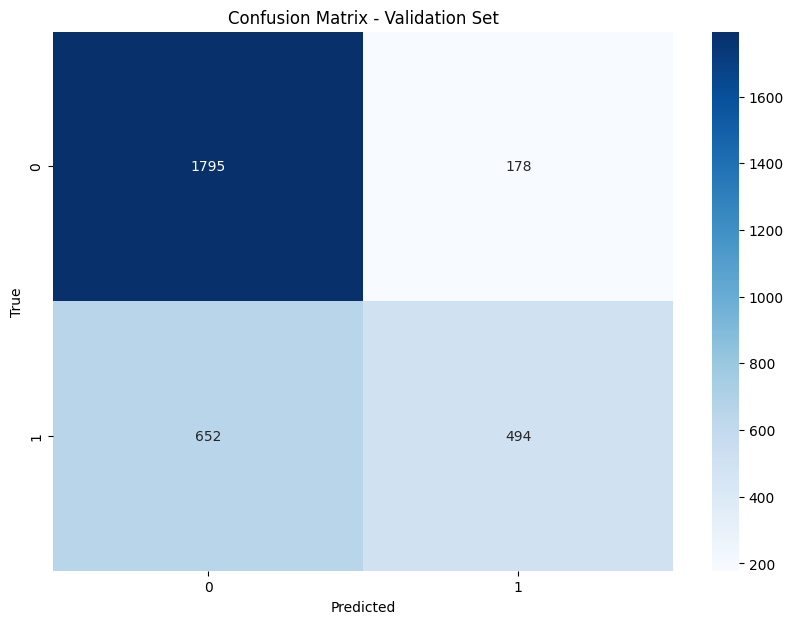

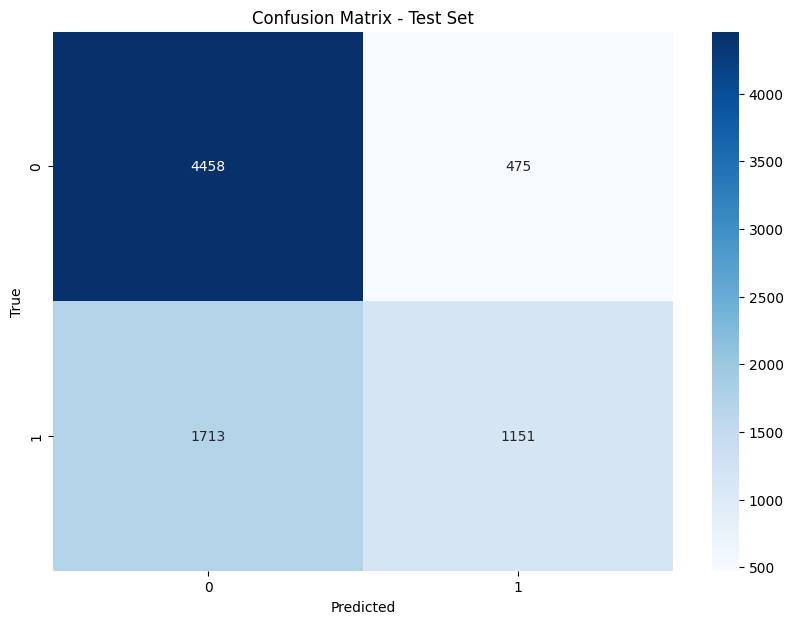

In [51]:
evaluate_model(history, model, X_train_scaled, X_val_scaled, X_test_scaled, y_train, y_val, y_test)

for more 70 epochs


In [45]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy', f1_score_metric])

In [46]:
history=model.fit(X_train_scaled, y_train, epochs=100, validation_data = (X_val_scaled, y_val), batch_size=32)

Epoch 1/100
878/878 [==============================] - 5s 3ms/step - loss: 0.4635 - accuracy: 0.7579 - f1_score_metric: 0.6653 - val_loss: 0.4787 - val_accuracy: 0.7557 - val_f1_score_metric: 0.6558
Epoch 2/100
878/878 [==============================] - 3s 3ms/step - loss: 0.4613 - accuracy: 0.7628 - f1_score_metric: 0.6715 - val_loss: 0.4744 - val_accuracy: 0.7573 - val_f1_score_metric: 0.6756
Epoch 3/100
878/878 [==============================] - 3s 3ms/step - loss: 0.4635 - accuracy: 0.7629 - f1_score_metric: 0.6721 - val_loss: 0.4733 - val_accuracy: 0.7573 - val_f1_score_metric: 0.6505
Epoch 4/100
878/878 [==============================] - 3s 3ms/step - loss: 0.4598 - accuracy: 0.7630 - f1_score_metric: 0.6724 - val_loss: 0.4812 - val_accuracy: 0.7502 - val_f1_score_metric: 0.6370
Epoch 5/100
878/878 [==============================] - 3s 3ms/step - loss: 0.4617 - accuracy: 0.7624 - f1_score_metric: 0.6703 - val_loss: 0.4832 - val_accuracy: 0.7534 - val_f1_score_metric: 0.6856
Epoch

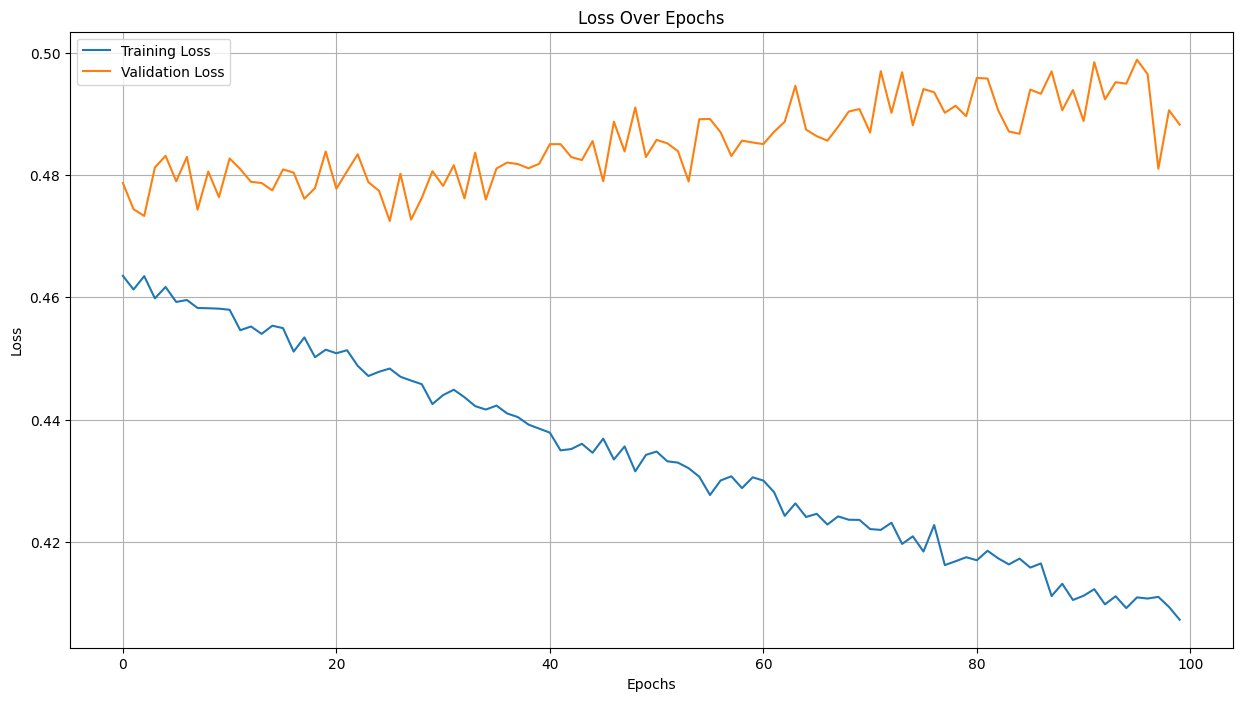

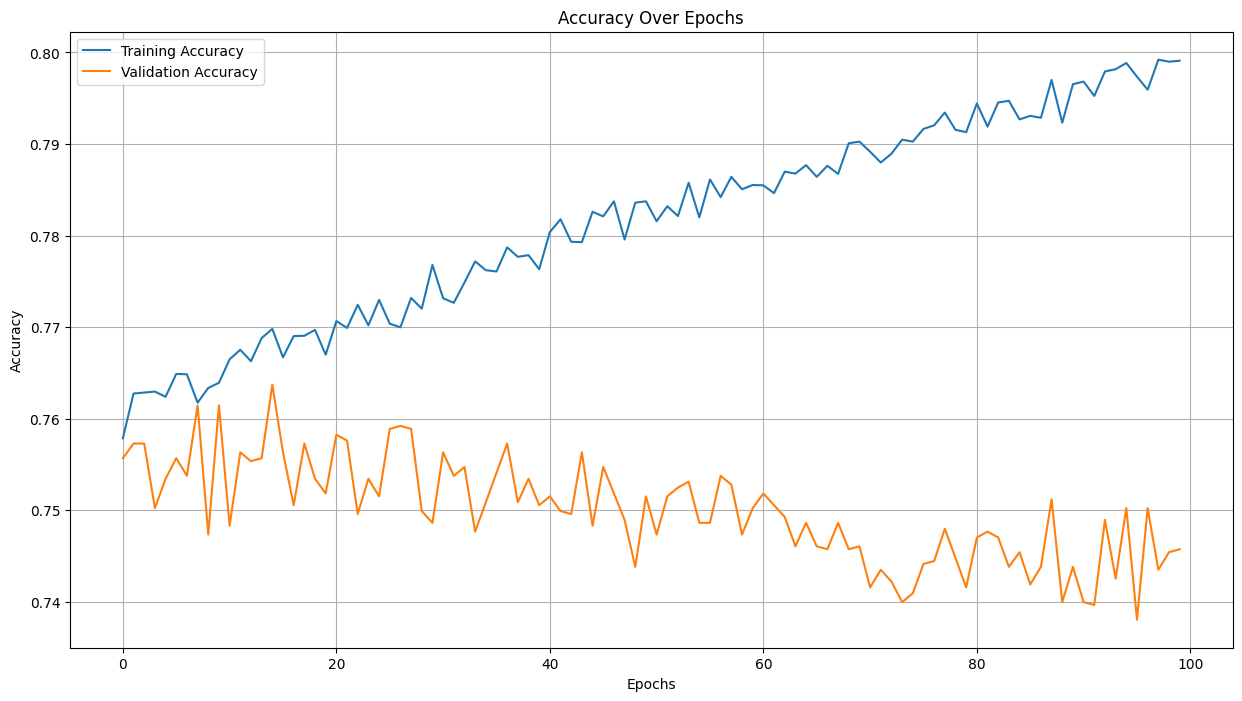

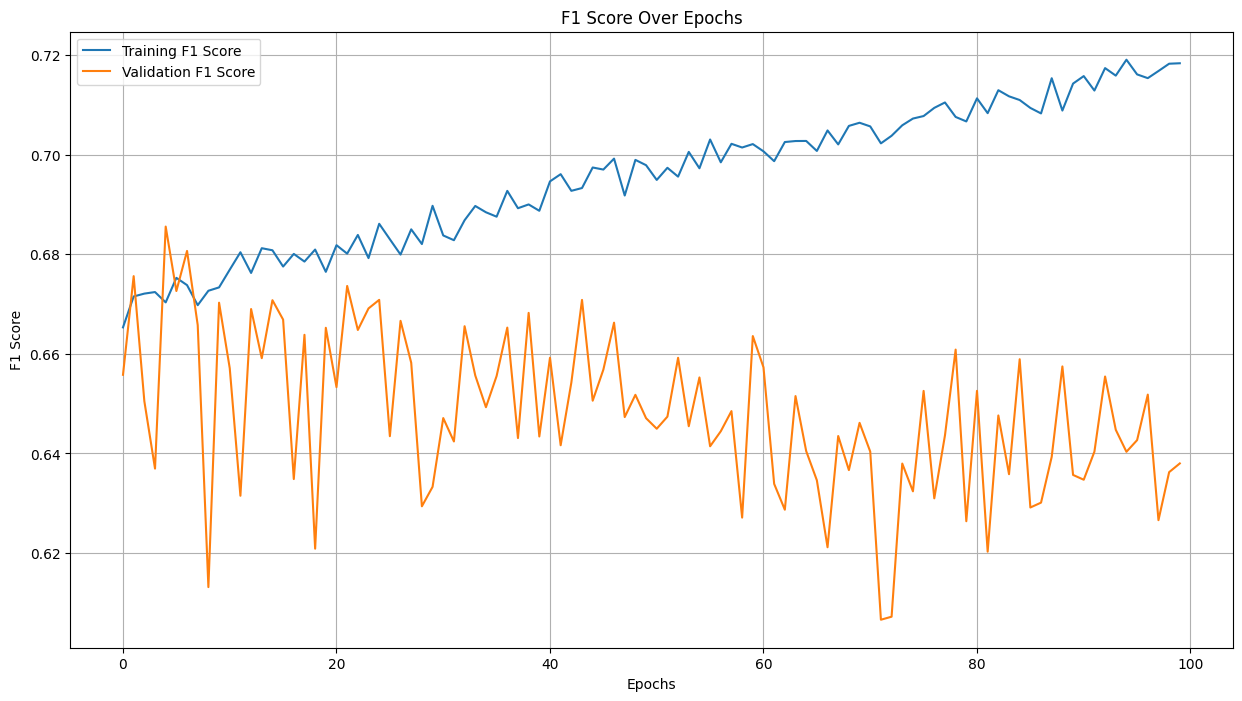

244/244 [==============================] - 0s 1ms/step
Classification Report - Training Set
              precision    recall  f1-score   support

           0       0.86      0.87      0.86     17760
           1       0.77      0.75      0.76     10308

    accuracy                           0.83     28068
   macro avg       0.81      0.81      0.81     28068
weighted avg       0.83      0.83      0.83     28068

Classification Report - Validation Set
              precision    recall  f1-score   support

           0       0.80      0.80      0.80      1973
           1       0.66      0.64      0.65      1146

    accuracy                           0.75      3119
   macro avg       0.73      0.72      0.73      3119
weighted avg       0.74      0.75      0.75      3119

Classification Report - Test Set
              precision    recall  f1-score   support

           0       0.80      0.80      0.80      4933
           1       0.66      0.65      0.66      2864

    accuracy      

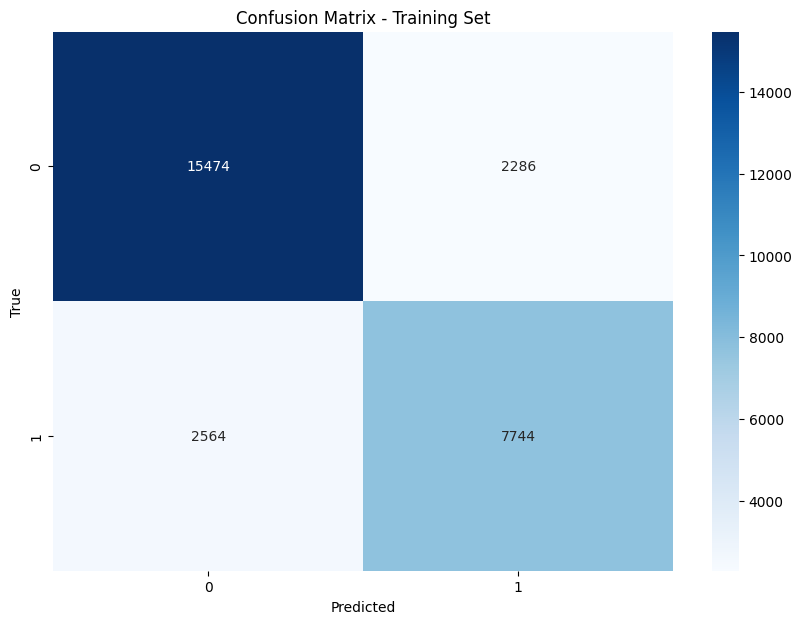

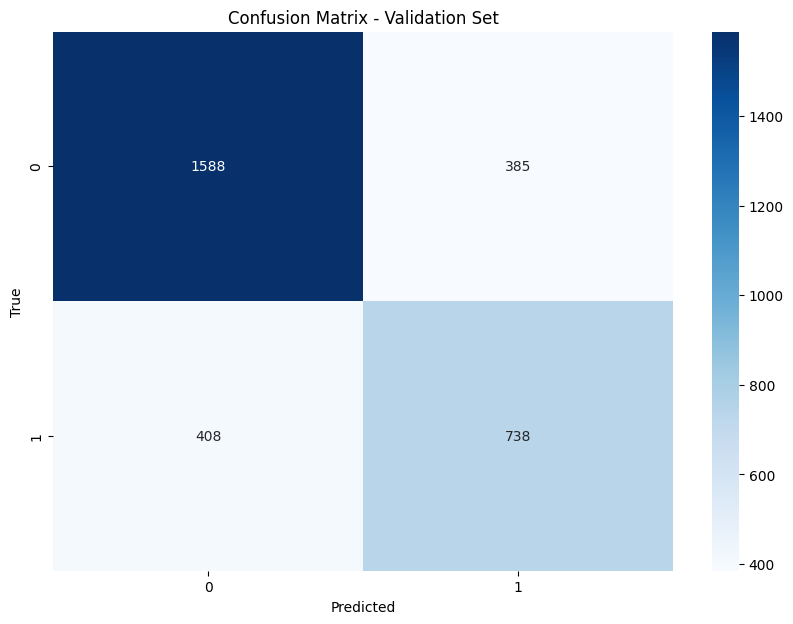

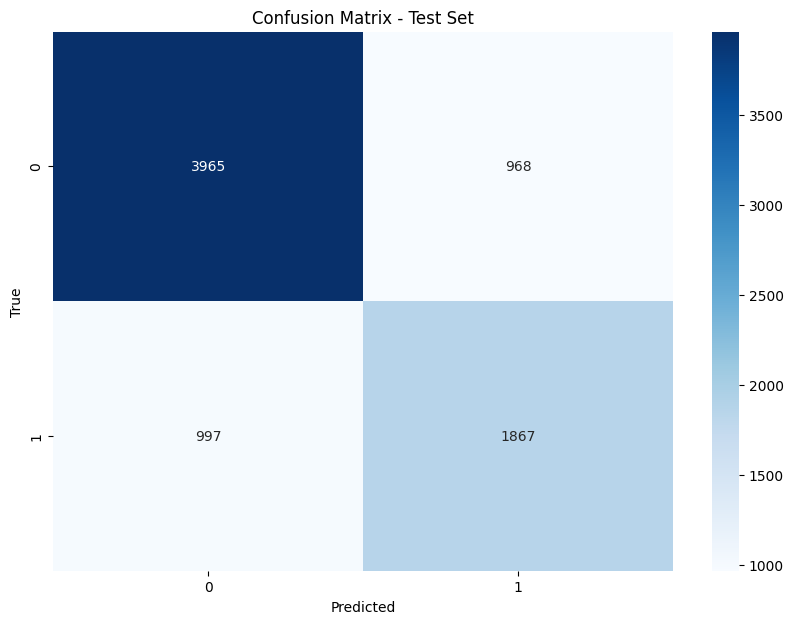

In [47]:
evaluate_model(history, model, X_train_scaled, X_val_scaled, X_test_scaled, y_train, y_val, y_test)

In [52]:
from keras.layers import Dropout

In [53]:
model = keras.models.Sequential([
    keras.layers.Dense(50, kernel_initializer='he_normal', activation='elu', input_shape=(22,),
                       kernel_regularizer=regularizers.L1L2()),
    Dropout(0.3),

    keras.layers.Dense(50, kernel_initializer='he_normal', activation='elu',
                       kernel_regularizer=regularizers.L1L2()),
    Dropout(0.3),

    keras.layers.Dense(50, kernel_initializer='he_normal', activation='elu',
                       kernel_regularizer=regularizers.L1L2()),
    Dropout(0.3),

    keras.layers.Dense(50, kernel_initializer='he_normal', activation='elu',
                       kernel_regularizer=regularizers.L1L2()),
    Dropout(0.3),

    keras.layers.Dense(50, kernel_initializer='he_normal', activation='elu',
                       kernel_regularizer=regularizers.L1L2()),
    Dropout(0.3),

    keras.layers.Dense(1, activation='sigmoid')
])

In [54]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy', f1_score_metric])

In [55]:
history=model.fit(X_train_scaled, y_train, epochs=30, validation_data = (X_val_scaled, y_val), batch_size=32)

Epoch 1/30
878/878 [==============================] - 4s 3ms/step - loss: 0.7002 - accuracy: 0.6577 - f1_score_metric: 0.5097 - val_loss: 0.4937 - val_accuracy: 0.7381 - val_f1_score_metric: 0.6642
Epoch 2/30
878/878 [==============================] - 2s 3ms/step - loss: 0.5351 - accuracy: 0.7038 - f1_score_metric: 0.5958 - val_loss: 0.4903 - val_accuracy: 0.7448 - val_f1_score_metric: 0.6709
Epoch 3/30
878/878 [==============================] - 2s 3ms/step - loss: 0.5146 - accuracy: 0.7188 - f1_score_metric: 0.6198 - val_loss: 0.4895 - val_accuracy: 0.7474 - val_f1_score_metric: 0.6747
Epoch 4/30
878/878 [==============================] - 2s 2ms/step - loss: 0.5063 - accuracy: 0.7272 - f1_score_metric: 0.6307 - val_loss: 0.4888 - val_accuracy: 0.7425 - val_f1_score_metric: 0.6802
Epoch 5/30
878/878 [==============================] - 2s 2ms/step - loss: 0.5024 - accuracy: 0.7311 - f1_score_metric: 0.6366 - val_loss: 0.4860 - val_accuracy: 0.7528 - val_f1_score_metric: 0.6433
Epoch 6/30

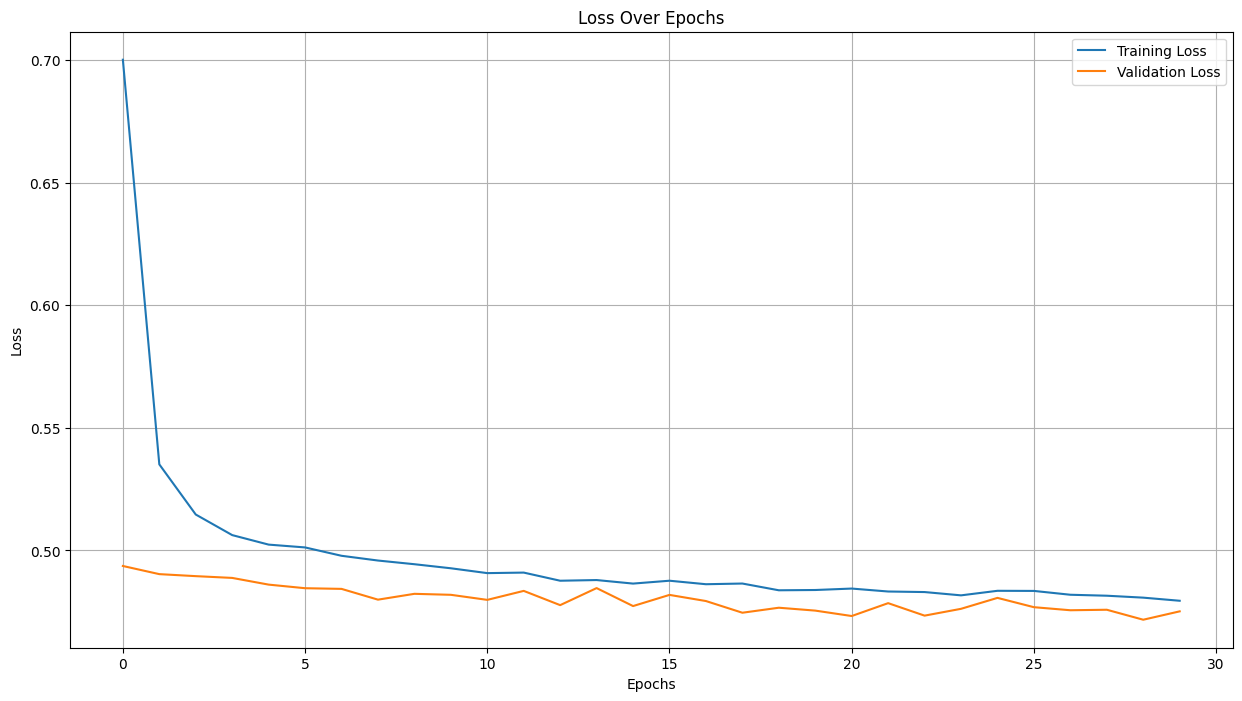

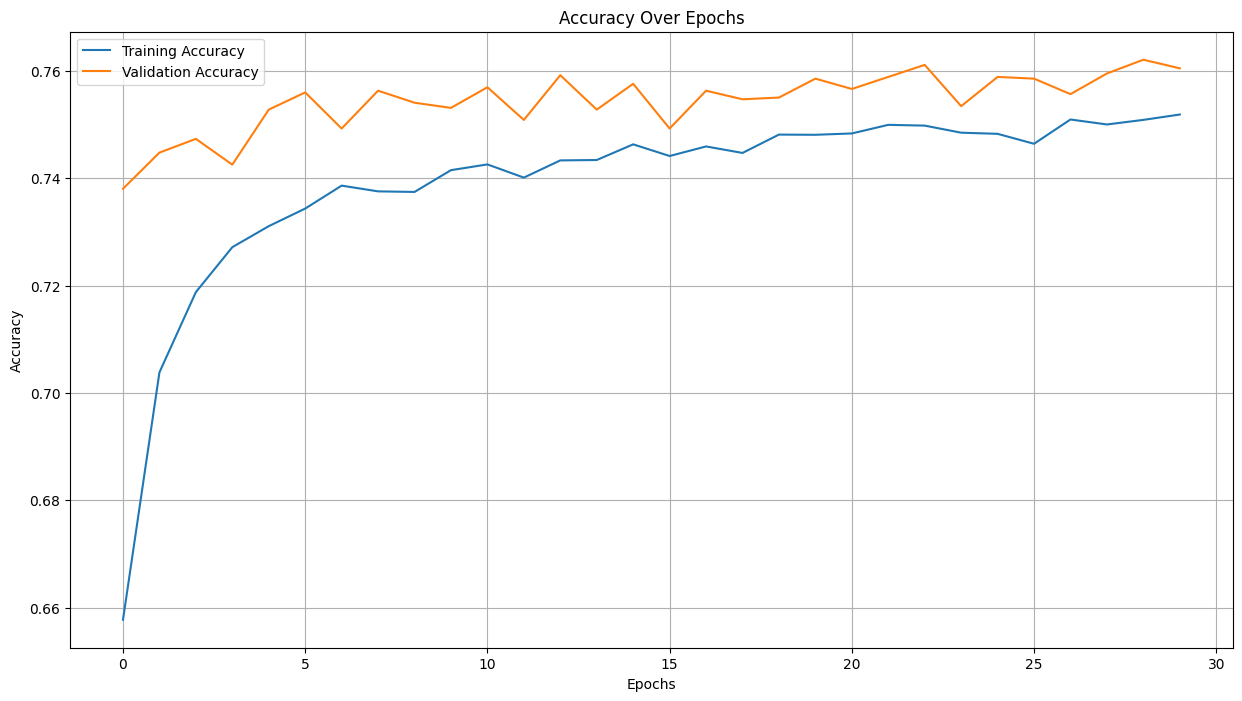

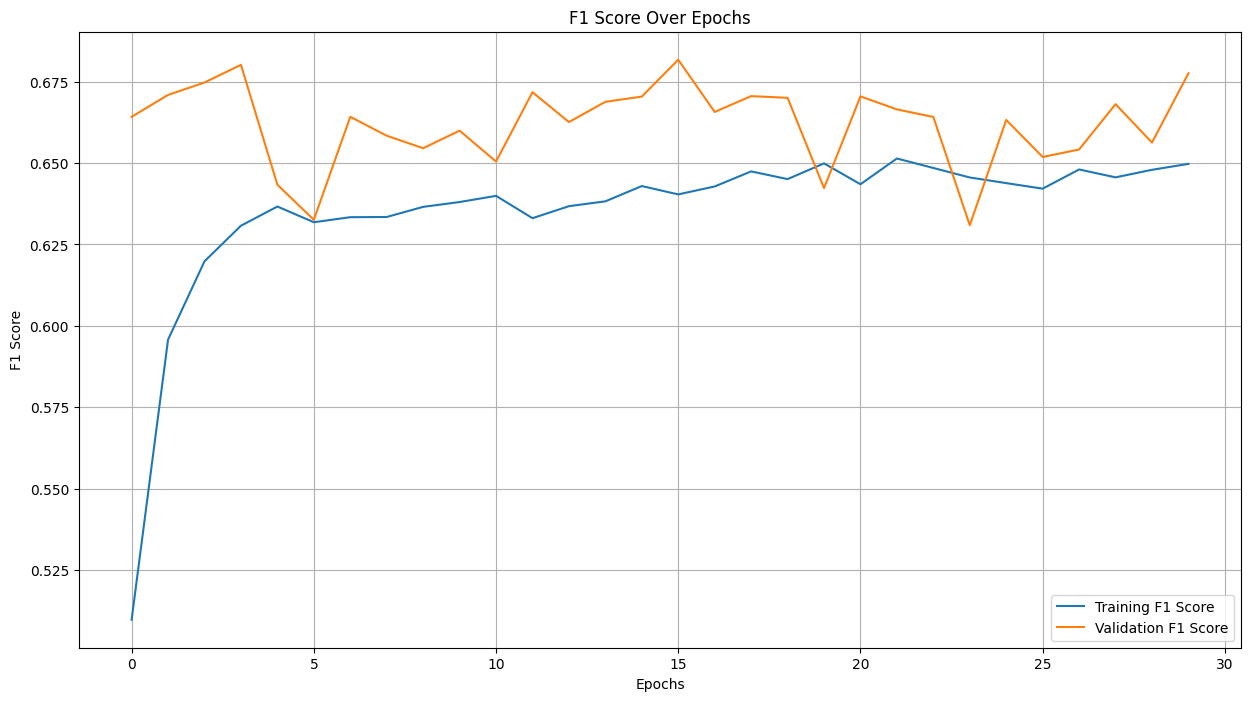

244/244 [==============================] - 0s 1ms/step
Classification Report - Training Set
              precision    recall  f1-score   support

           0       0.83      0.78      0.80     17760
           1       0.65      0.73      0.69     10308

    accuracy                           0.76     28068
   macro avg       0.74      0.75      0.75     28068
weighted avg       0.77      0.76      0.76     28068

Classification Report - Validation Set
              precision    recall  f1-score   support

           0       0.83      0.78      0.81      1973
           1       0.66      0.72      0.69      1146

    accuracy                           0.76      3119
   macro avg       0.74      0.75      0.75      3119
weighted avg       0.77      0.76      0.76      3119

Classification Report - Test Set
              precision    recall  f1-score   support

           0       0.83      0.76      0.79      4933
           1       0.64      0.72      0.68      2864

    accuracy      

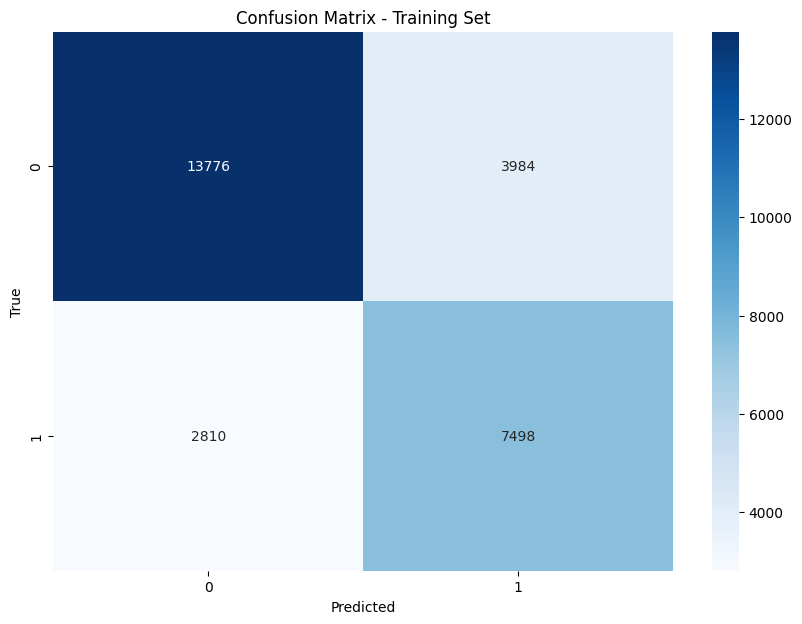

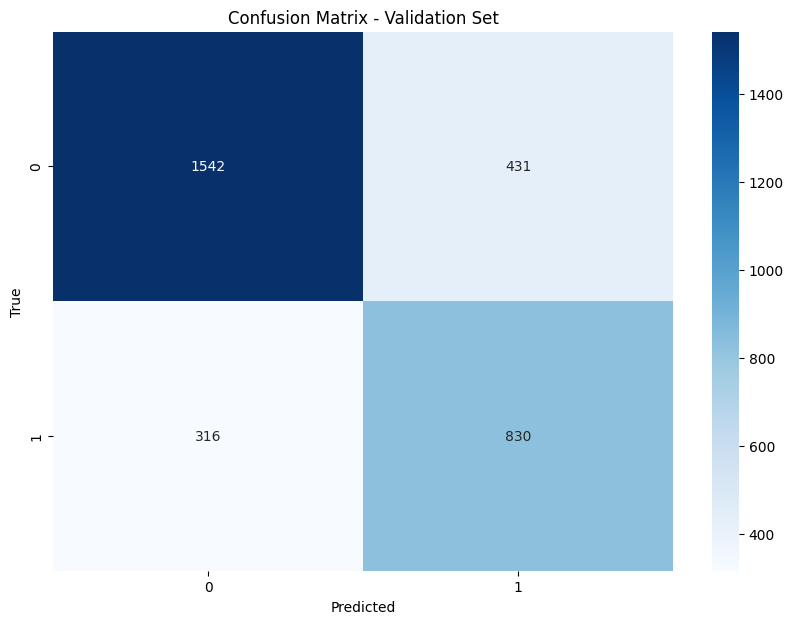

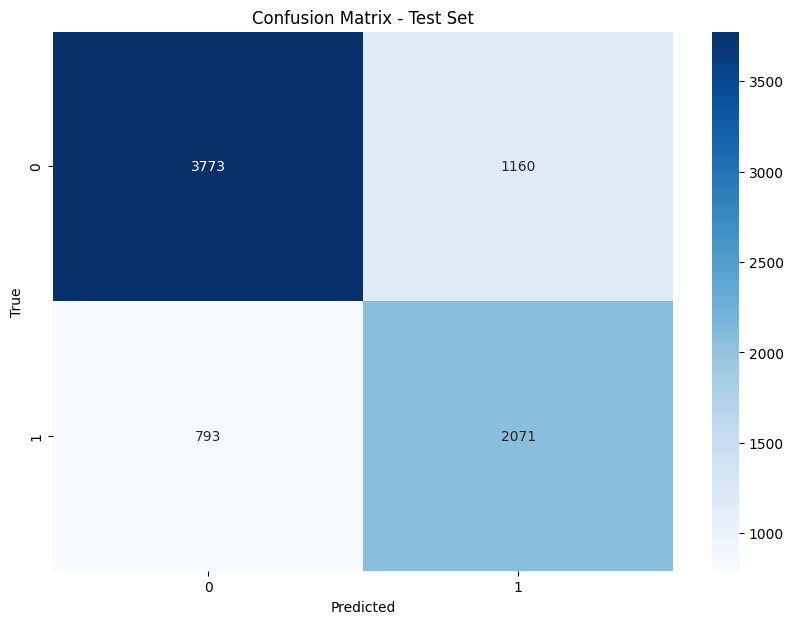

In [56]:
evaluate_model(history, model, X_train_scaled, X_val_scaled, X_test_scaled, y_train, y_val, y_test)

In [69]:
model = keras.models.Sequential([
    keras.layers.Dense(100, kernel_initializer='he_normal', activation='elu', input_shape=(22,),
                       kernel_regularizer=regularizers.L1L2()),
    Dropout(0.5),

    keras.layers.Dense(100, kernel_initializer='he_normal', activation='elu',
                       kernel_regularizer=regularizers.L1L2()),
    Dropout(0.5),

    keras.layers.Dense(100, kernel_initializer='he_normal', activation='elu',
                       kernel_regularizer=regularizers.L1L2()),
    Dropout(0.5),

    keras.layers.Dense(50, kernel_initializer='he_normal', activation='elu',
                       kernel_regularizer=regularizers.L1L2()),
    Dropout(0.5),

    keras.layers.Dense(50, kernel_initializer='he_normal', activation='elu',
                       kernel_regularizer=regularizers.L1L2()),
    Dropout(0.5),

    keras.layers.Dense(1, activation='sigmoid')
])

In [70]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy', f1_score_metric])

In [71]:
history=model.fit(X_train_scaled, y_train, epochs=30, validation_data = (X_val_scaled, y_val), batch_size=32)

Epoch 1/30
878/878 [==============================] - 4s 3ms/step - loss: 1.0174 - accuracy: 0.6088 - f1_score_metric: 0.4425 - val_loss: 0.5191 - val_accuracy: 0.7076 - val_f1_score_metric: 0.6702
Epoch 2/30
878/878 [==============================] - 2s 3ms/step - loss: 0.5700 - accuracy: 0.6720 - f1_score_metric: 0.5306 - val_loss: 0.5130 - val_accuracy: 0.7076 - val_f1_score_metric: 0.6784
Epoch 3/30
878/878 [==============================] - 2s 3ms/step - loss: 0.5399 - accuracy: 0.6931 - f1_score_metric: 0.5962 - val_loss: 0.5081 - val_accuracy: 0.7086 - val_f1_score_metric: 0.6821
Epoch 4/30
878/878 [==============================] - 2s 3ms/step - loss: 0.5343 - accuracy: 0.6984 - f1_score_metric: 0.6021 - val_loss: 0.5055 - val_accuracy: 0.7198 - val_f1_score_metric: 0.6841
Epoch 5/30
878/878 [==============================] - 2s 3ms/step - loss: 0.5236 - accuracy: 0.7114 - f1_score_metric: 0.6226 - val_loss: 0.5021 - val_accuracy: 0.7249 - val_f1_score_metric: 0.6867
Epoch 6/30

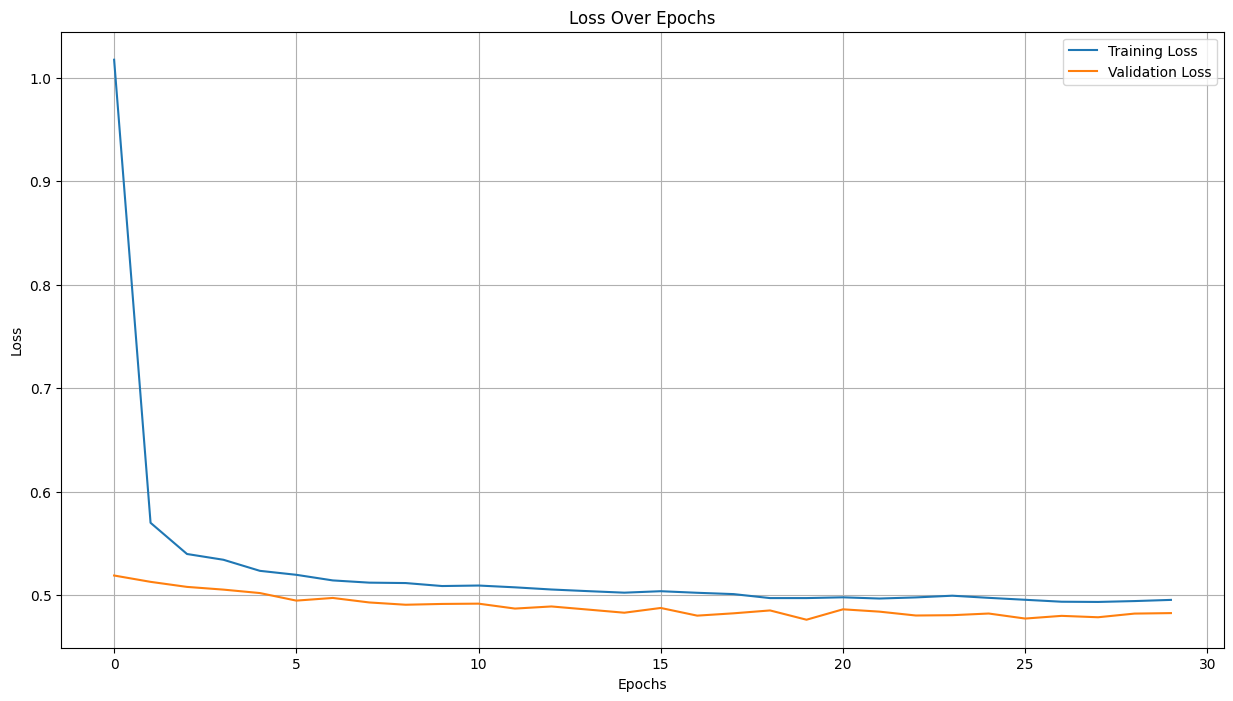

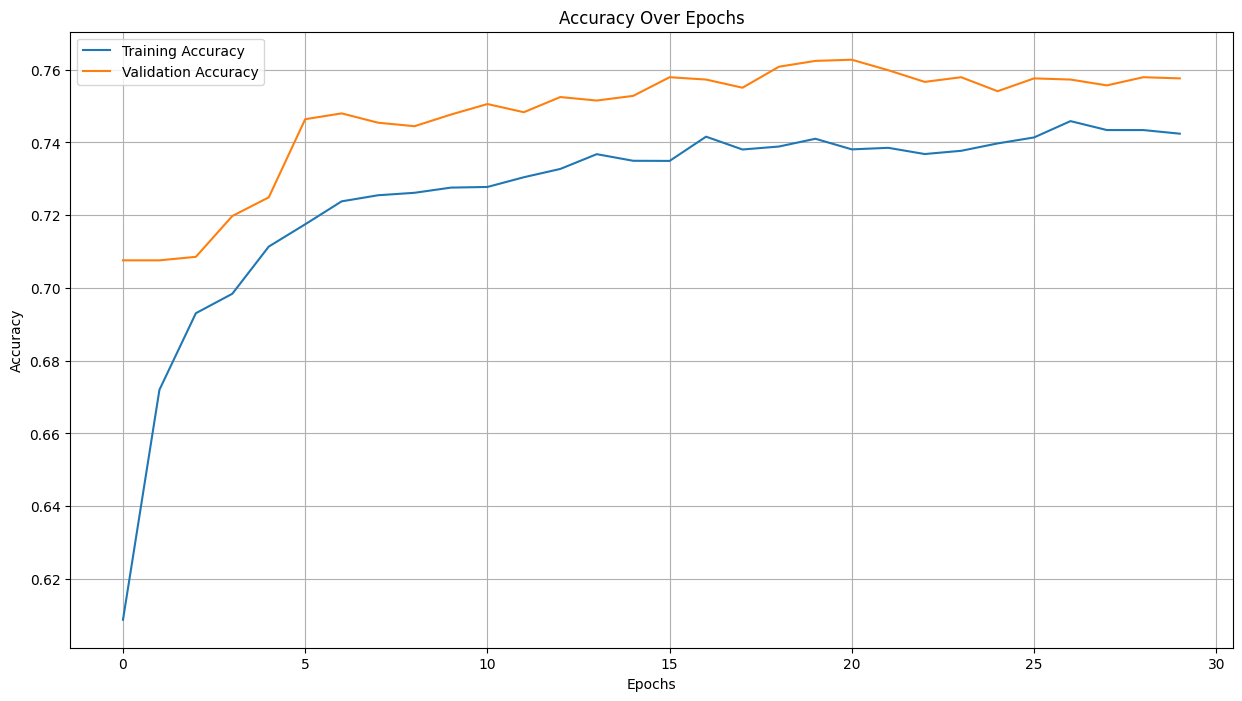

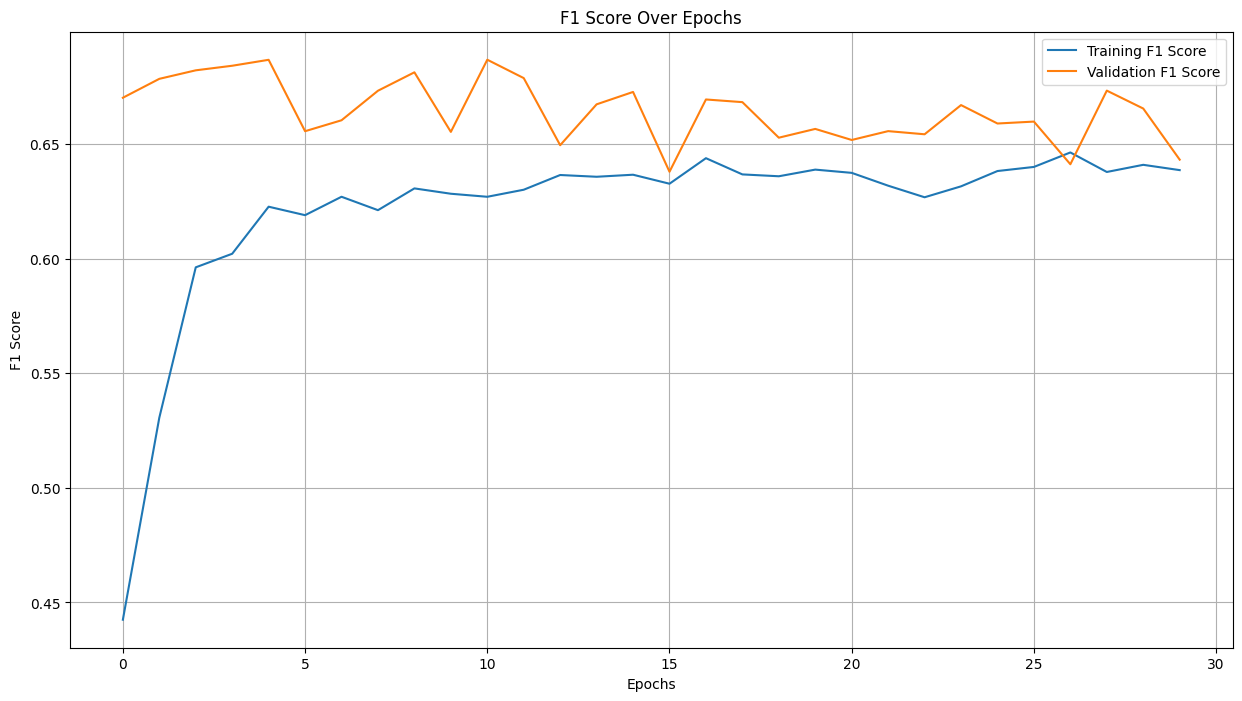

244/244 [==============================] - 0s 1ms/step
Classification Report - Training Set
              precision    recall  f1-score   support

           0       0.79      0.82      0.81     17760
           1       0.67      0.63      0.65     10308

    accuracy                           0.75     28068
   macro avg       0.73      0.73      0.73     28068
weighted avg       0.75      0.75      0.75     28068

Classification Report - Validation Set
              precision    recall  f1-score   support

           0       0.79      0.83      0.81      1973
           1       0.68      0.63      0.66      1146

    accuracy                           0.76      3119
   macro avg       0.74      0.73      0.73      3119
weighted avg       0.75      0.76      0.76      3119

Classification Report - Test Set
              precision    recall  f1-score   support

           0       0.79      0.82      0.80      4933
           1       0.66      0.63      0.65      2864

    accuracy      

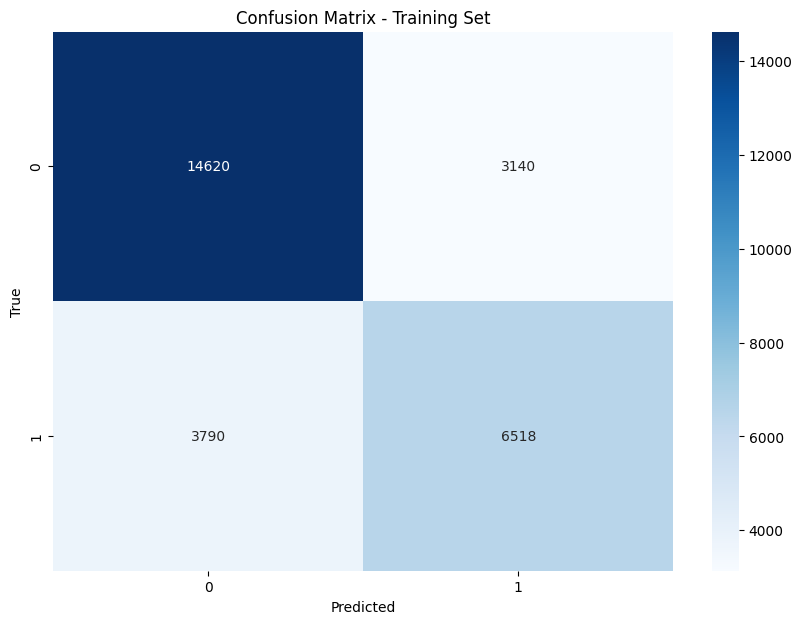

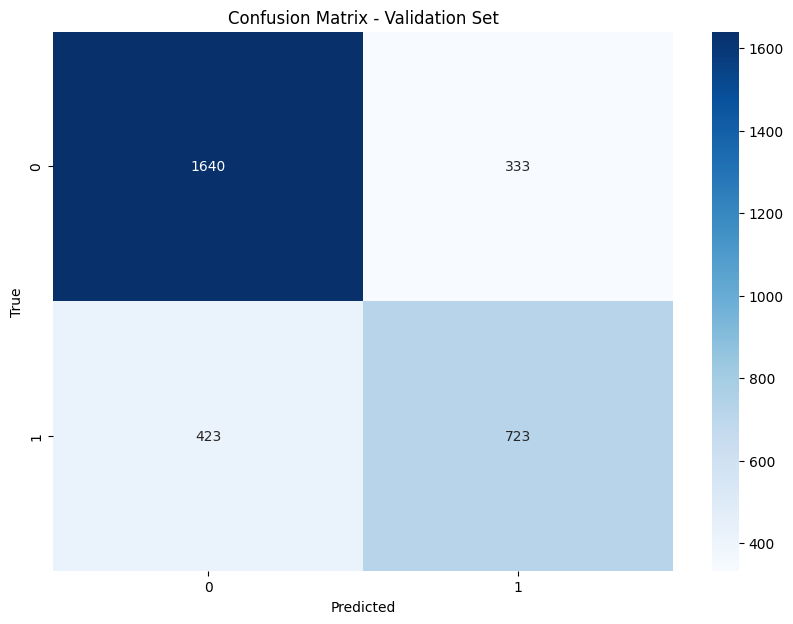

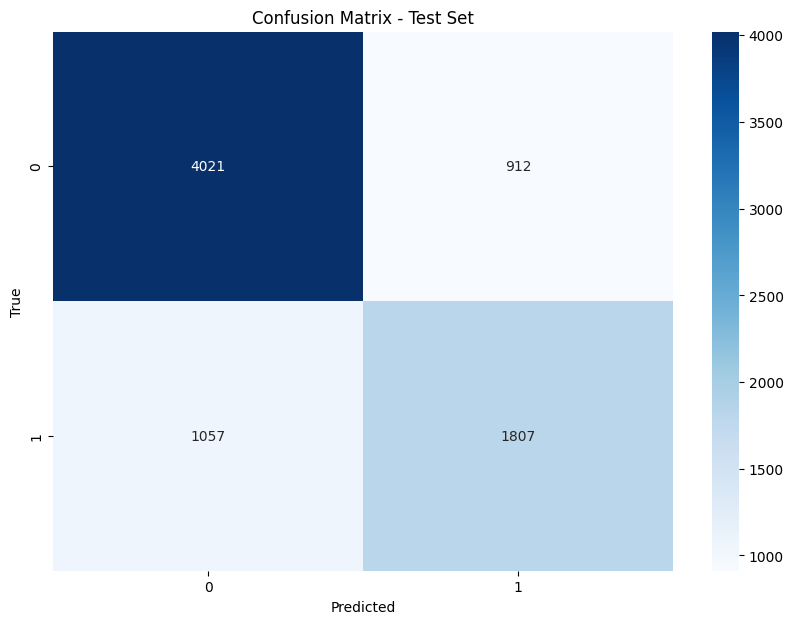

In [72]:
evaluate_model(history, model, X_train_scaled, X_val_scaled, X_test_scaled, y_train, y_val, y_test)

244/244 [==============================] - 0s 1ms/step


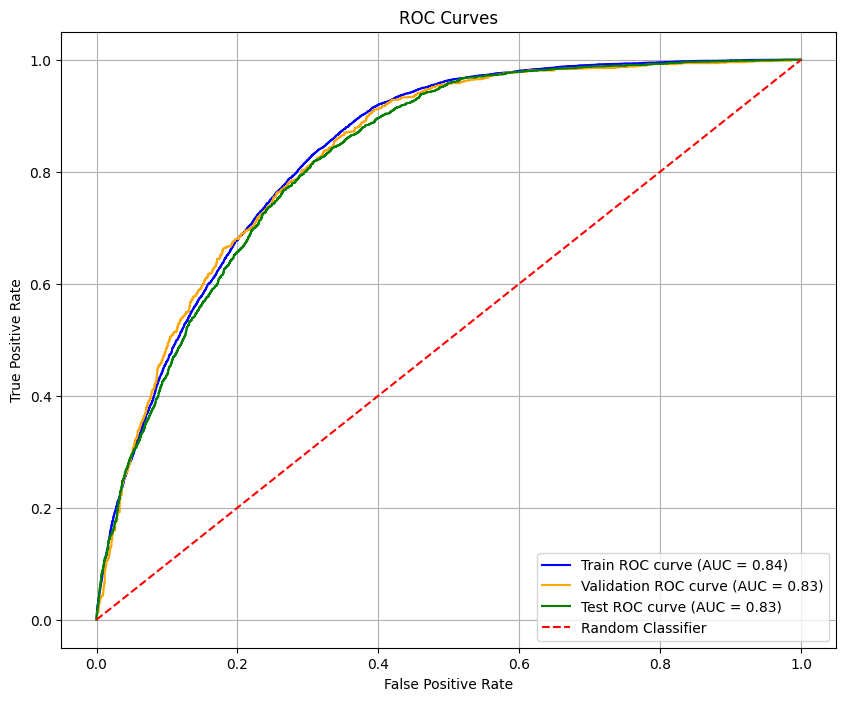

Train AUC: 0.8369
Validation AUC: 0.8344
Test AUC: 0.8282


In [73]:
evaluate_model_withROC(model, X_train_scaled, X_val_scaled, X_test_scaled, y_train, y_val, y_test)

In [61]:
model.compile(optimizer='sgd', loss='binary_crossentropy', metrics=['accuracy', f1_score_metric])

In [62]:
history=model.fit(X_train_scaled, y_train, epochs=30, validation_data = (X_val_scaled, y_val), batch_size=32)

Epoch 1/30
878/878 [==============================] - 3s 3ms/step - loss: 0.4972 - accuracy: 0.7419 - f1_score_metric: 0.6458 - val_loss: 0.4793 - val_accuracy: 0.7534 - val_f1_score_metric: 0.6789
Epoch 2/30
878/878 [==============================] - 2s 3ms/step - loss: 0.4944 - accuracy: 0.7442 - f1_score_metric: 0.6487 - val_loss: 0.4743 - val_accuracy: 0.7570 - val_f1_score_metric: 0.6591
Epoch 3/30
878/878 [==============================] - 2s 2ms/step - loss: 0.4954 - accuracy: 0.7433 - f1_score_metric: 0.6481 - val_loss: 0.4740 - val_accuracy: 0.7528 - val_f1_score_metric: 0.6618
Epoch 4/30
878/878 [==============================] - 2s 2ms/step - loss: 0.4962 - accuracy: 0.7439 - f1_score_metric: 0.6499 - val_loss: 0.4795 - val_accuracy: 0.7554 - val_f1_score_metric: 0.6664
Epoch 5/30
878/878 [==============================] - 2s 2ms/step - loss: 0.4923 - accuracy: 0.7458 - f1_score_metric: 0.6460 - val_loss: 0.4757 - val_accuracy: 0.7554 - val_f1_score_metric: 0.6687
Epoch 6/30

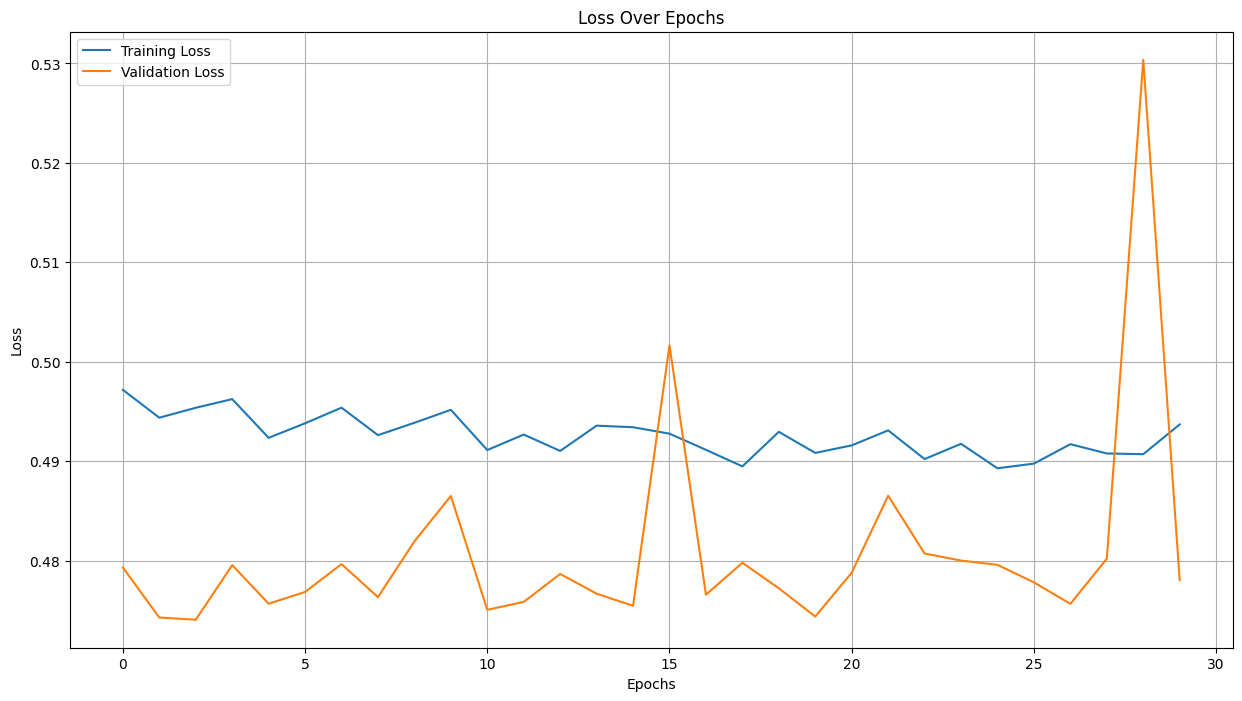

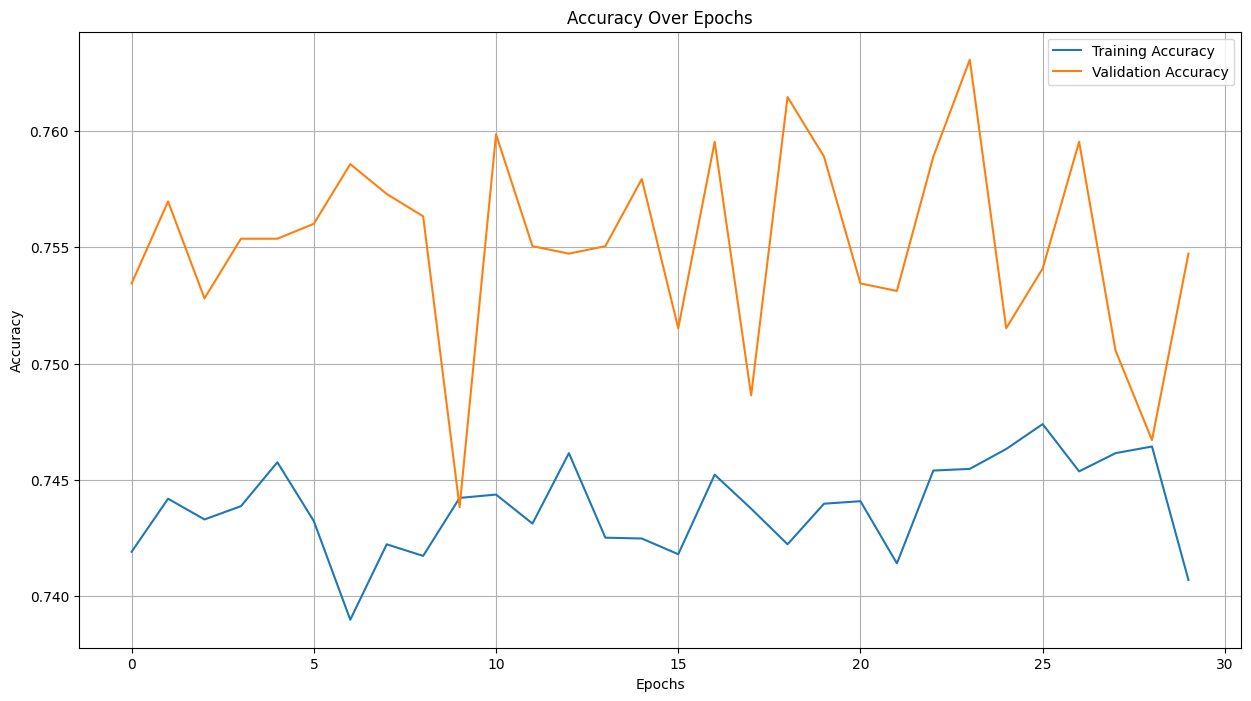

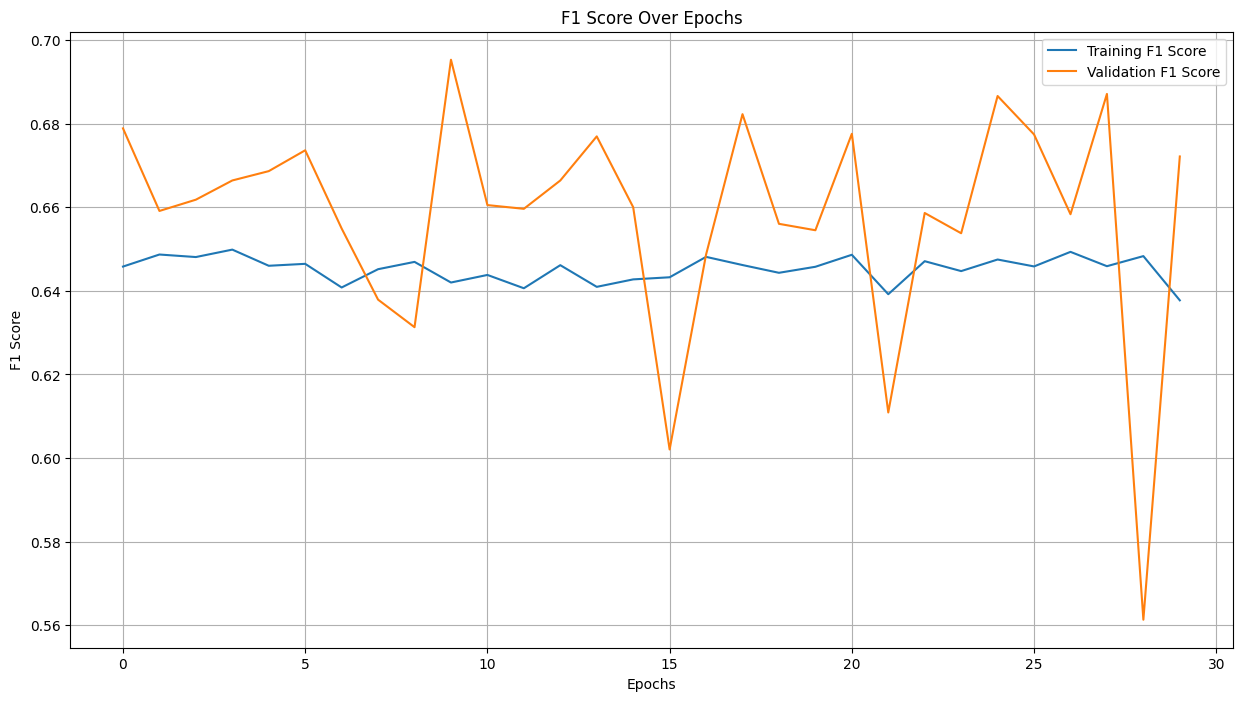

244/244 [==============================] - 0s 1ms/step
Classification Report - Training Set
              precision    recall  f1-score   support

           0       0.83      0.77      0.80     17760
           1       0.65      0.73      0.69     10308

    accuracy                           0.76     28068
   macro avg       0.74      0.75      0.74     28068
weighted avg       0.76      0.76      0.76     28068

Classification Report - Validation Set
              precision    recall  f1-score   support

           0       0.83      0.77      0.80      1973
           1       0.65      0.72      0.68      1146

    accuracy                           0.75      3119
   macro avg       0.74      0.75      0.74      3119
weighted avg       0.76      0.75      0.76      3119

Classification Report - Test Set
              precision    recall  f1-score   support

           0       0.83      0.76      0.79      4933
           1       0.64      0.73      0.68      2864

    accuracy      

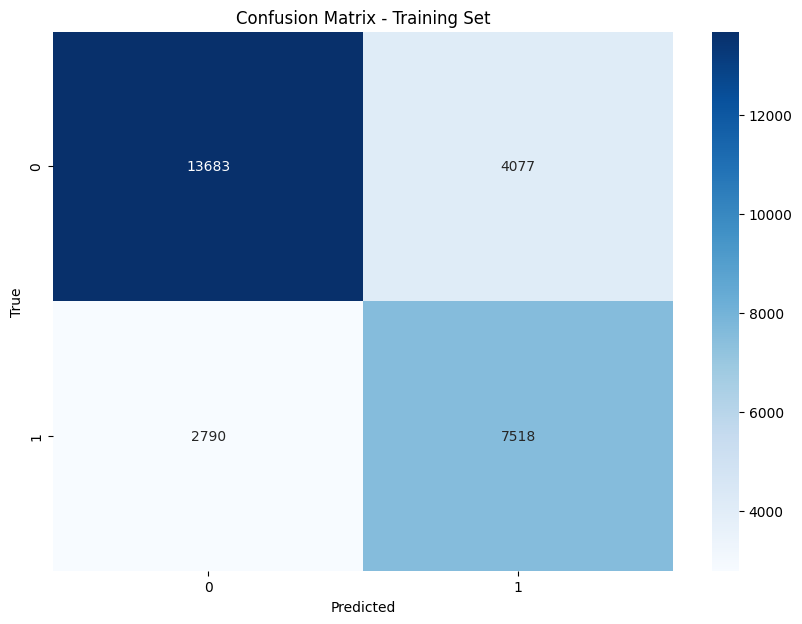

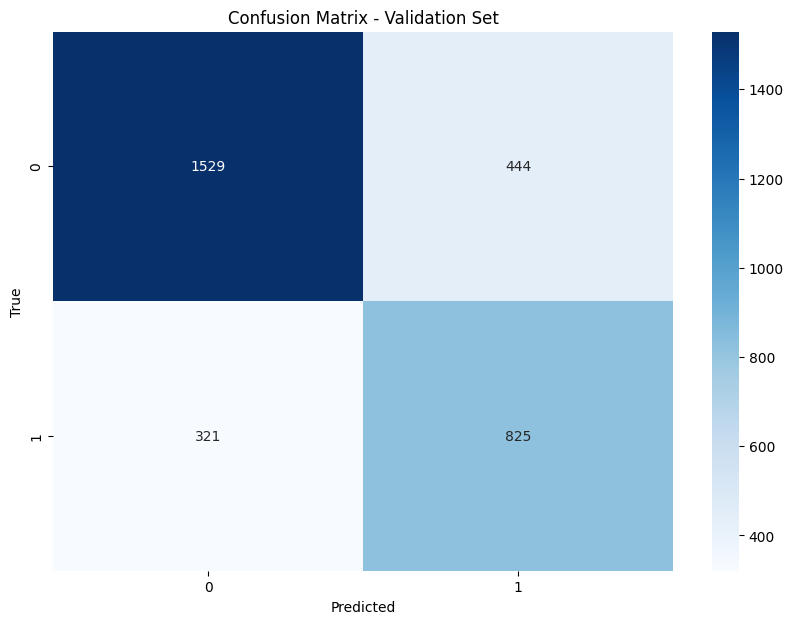

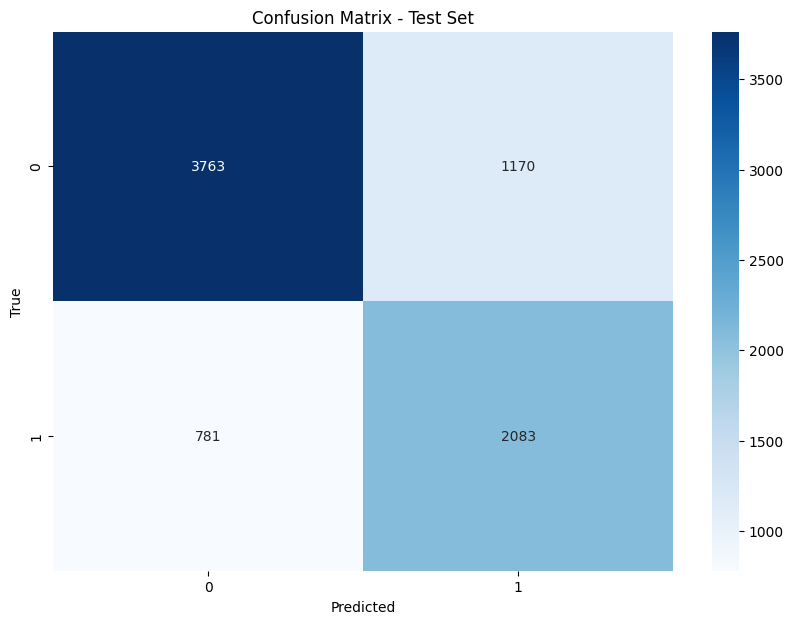

In [63]:
evaluate_model(history, model, X_train_scaled, X_val_scaled, X_test_scaled, y_train, y_val, y_test)

244/244 [==============================] - 0s 1ms/step


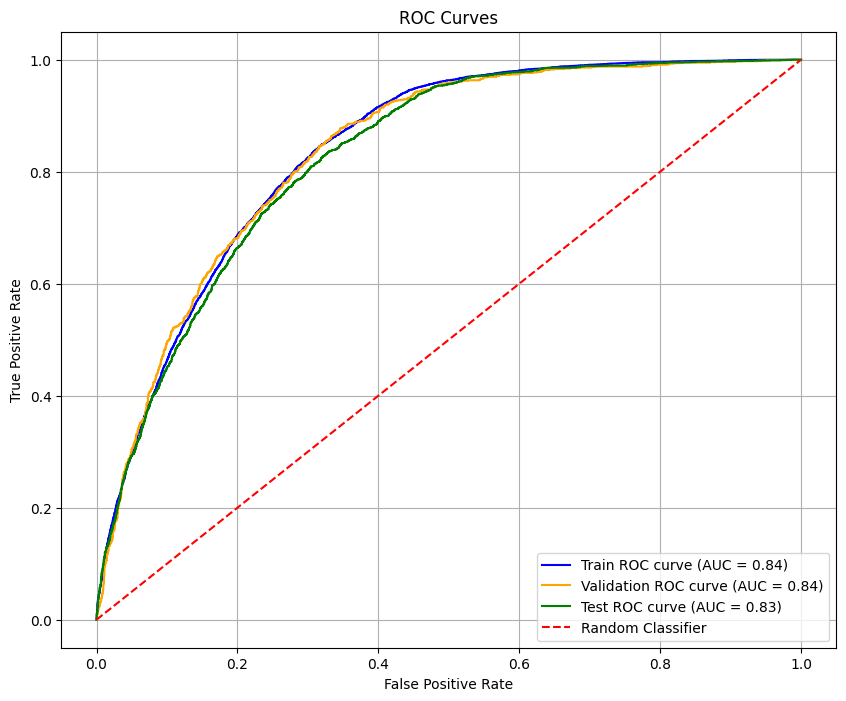

Train AUC: 0.8386
Validation AUC: 0.8369
Test AUC: 0.8291


In [68]:
evaluate_model_withROC(model, X_train_scaled, X_val_scaled, X_test_scaled, y_train, y_val, y_test)

In [75]:
model = keras.models.Sequential([
    keras.layers.Dense(100, kernel_initializer='he_normal', activation='elu', input_shape=(22,),
                       kernel_regularizer=regularizers.L1L2()),
    Dropout(0.5),

    keras.layers.Dense(100, kernel_initializer='he_normal', activation='elu',
                       kernel_regularizer=regularizers.L1L2()),
    Dropout(0.5),

    keras.layers.Dense(100, kernel_initializer='he_normal', activation='elu',
                       kernel_regularizer=regularizers.L1L2()),
    Dropout(0.5),

    keras.layers.Dense(1, activation='sigmoid')
])

In [76]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy', f1_score_metric])

In [77]:
history=model.fit(X_train_scaled, y_train, epochs=30, validation_data = (X_val_scaled, y_val), batch_size=32)

Epoch 1/30
878/878 [==============================] - 3s 3ms/step - loss: 0.7145 - accuracy: 0.6703 - f1_score_metric: 0.5376 - val_loss: 0.4967 - val_accuracy: 0.7252 - val_f1_score_metric: 0.6569
Epoch 2/30
878/878 [==============================] - 2s 2ms/step - loss: 0.5275 - accuracy: 0.7092 - f1_score_metric: 0.6009 - val_loss: 0.4919 - val_accuracy: 0.7374 - val_f1_score_metric: 0.6669
Epoch 3/30
878/878 [==============================] - 2s 2ms/step - loss: 0.5123 - accuracy: 0.7216 - f1_score_metric: 0.6248 - val_loss: 0.4905 - val_accuracy: 0.7384 - val_f1_score_metric: 0.6843
Epoch 4/30
878/878 [==============================] - 2s 2ms/step - loss: 0.5088 - accuracy: 0.7241 - f1_score_metric: 0.6274 - val_loss: 0.4864 - val_accuracy: 0.7515 - val_f1_score_metric: 0.6609
Epoch 5/30
878/878 [==============================] - 2s 2ms/step - loss: 0.5040 - accuracy: 0.7294 - f1_score_metric: 0.6294 - val_loss: 0.4829 - val_accuracy: 0.7547 - val_f1_score_metric: 0.6533
Epoch 6/30

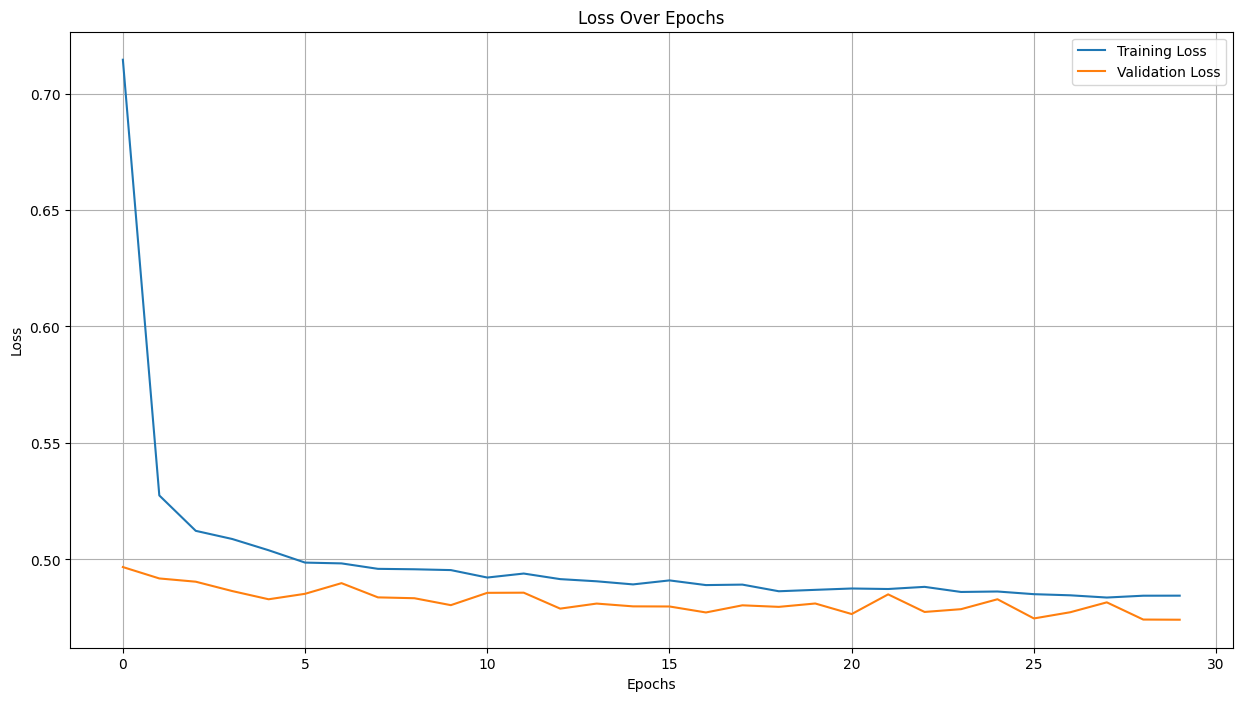

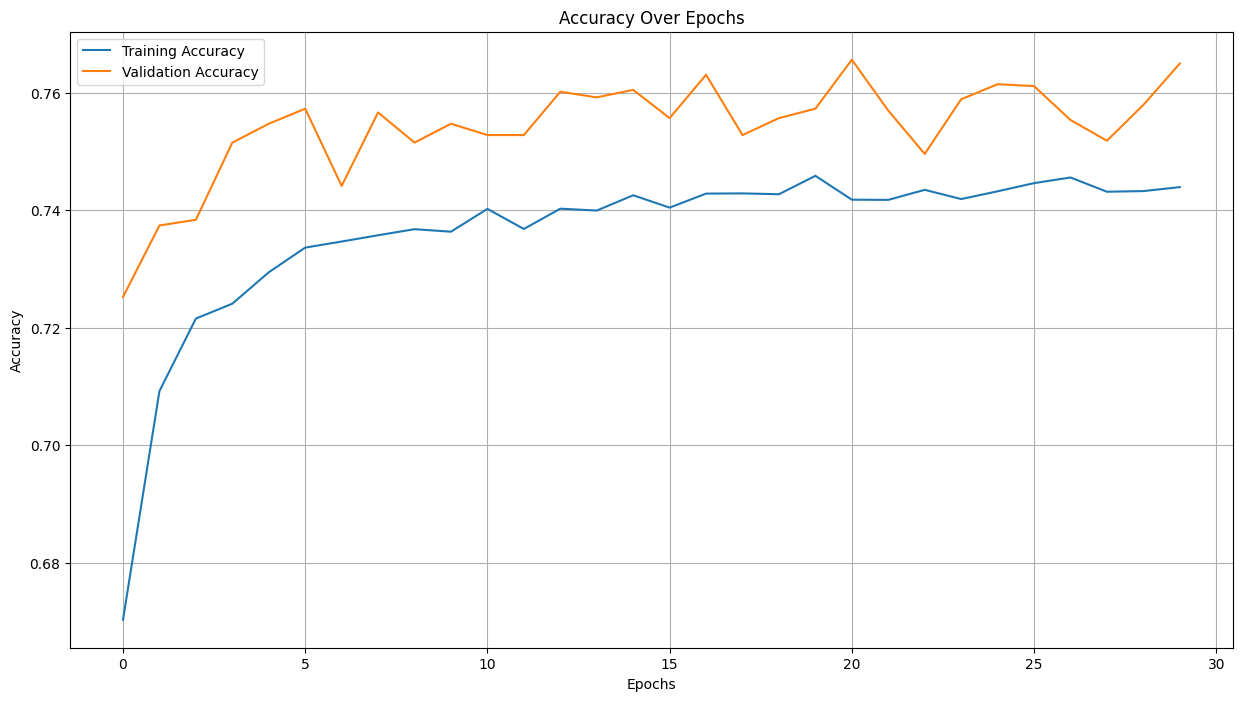

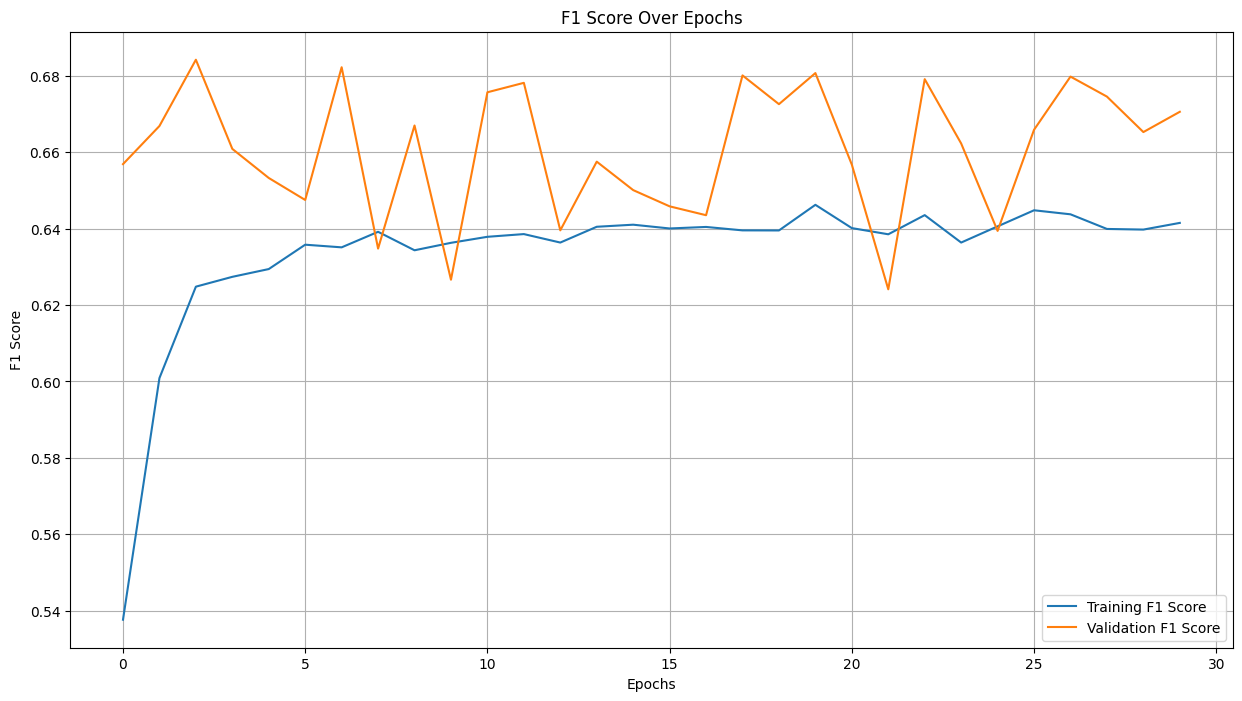

244/244 [==============================] - 0s 1ms/step
Classification Report - Training Set
              precision    recall  f1-score   support

           0       0.81      0.80      0.81     17760
           1       0.66      0.68      0.67     10308

    accuracy                           0.76     28068
   macro avg       0.74      0.74      0.74     28068
weighted avg       0.76      0.76      0.76     28068

Classification Report - Validation Set
              precision    recall  f1-score   support

           0       0.82      0.81      0.81      1973
           1       0.68      0.69      0.68      1146

    accuracy                           0.76      3119
   macro avg       0.75      0.75      0.75      3119
weighted avg       0.77      0.76      0.77      3119

Classification Report - Test Set
              precision    recall  f1-score   support

           0       0.81      0.79      0.80      4933
           1       0.65      0.67      0.66      2864

    accuracy      

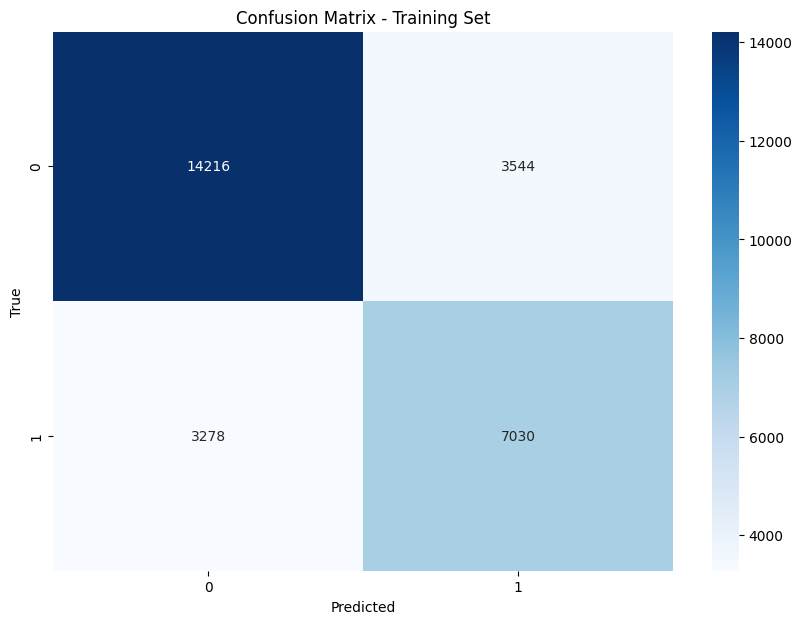

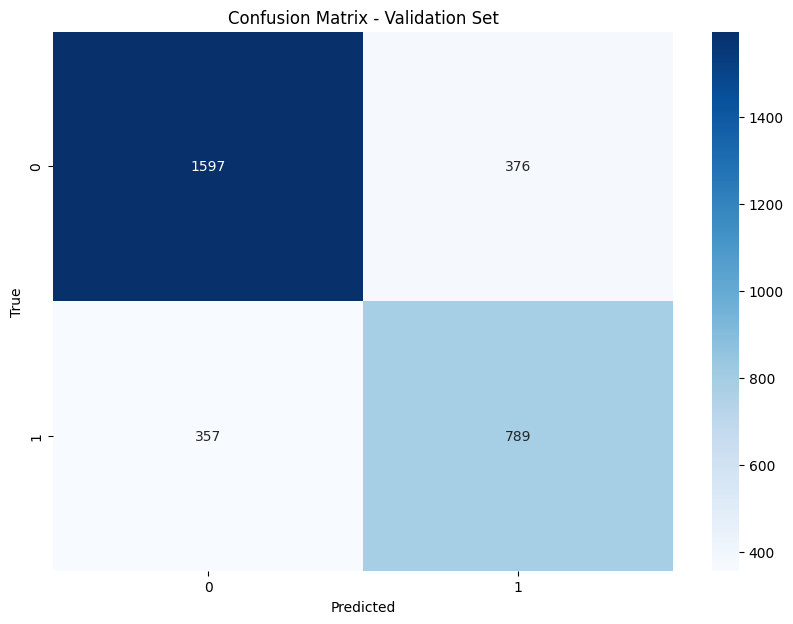

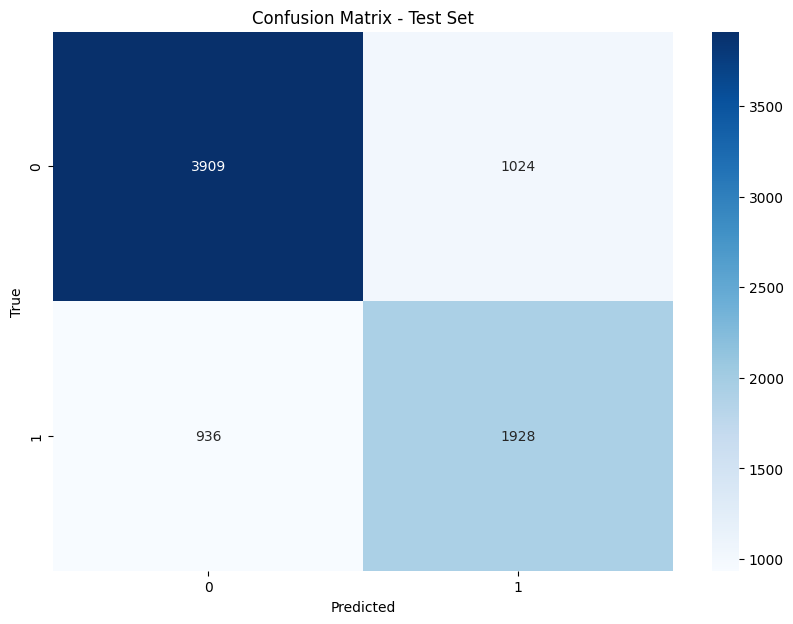

In [78]:
evaluate_model(history, model, X_train_scaled, X_val_scaled, X_test_scaled, y_train, y_val, y_test)

244/244 [==============================] - 0s 1ms/step


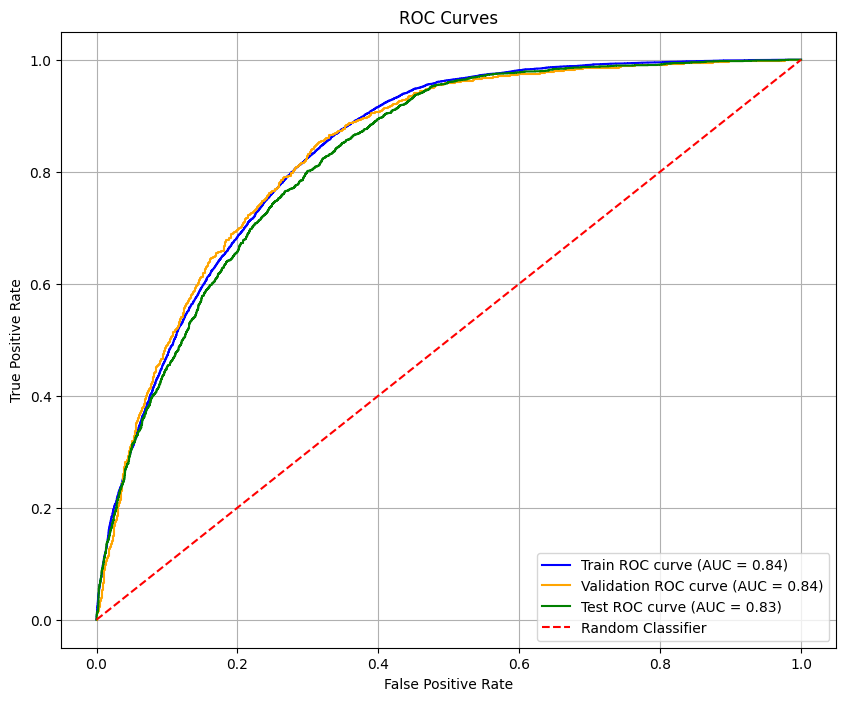

Train AUC: 0.8405
Validation AUC: 0.8392
Test AUC: 0.8295


In [79]:
evaluate_model_withROC(model, X_train_scaled, X_val_scaled, X_test_scaled, y_train, y_val, y_test)

Try to Tune the hyber parameters

#### try schedular

In [74]:
# 1cycle learning rate scheduler
class OneCycleScheduler(keras.callbacks.Callback):
    def __init__(self, iterations, max_rate, start_rate=None,
                 last_iterations=None, last_rate=None):
        self.iterations = iterations
        self.max_rate = max_rate
        self.start_rate = start_rate or max_rate / 10
        self.last_iterations = last_iterations or iterations // 10 + 1
        self.half_iteration = (iterations - self.last_iterations) // 2
        self.last_rate = last_rate or self.start_rate / 1000
        self.iteration = 0

    def _interpolate(self, iter1, iter2, rate1, rate2):
        return ((rate2 - rate1) * (self.iteration - iter1)
                / (iter2 - iter1) + rate1)

    def on_batch_begin(self, batch, logs):
        if self.iteration < self.half_iteration:
            rate = self._interpolate(0, self.half_iteration, self.start_rate, self.max_rate)
        elif self.iteration < 2 * self.half_iteration:
            rate = self._interpolate(self.half_iteration, 2 * self.half_iteration,
                                     self.max_rate, self.start_rate)
        else:
            rate = self._interpolate(2 * self.half_iteration, self.iterations,
                                     self.start_rate, self.last_rate)
        self.iteration += 1
        keras.backend.set_value(self.model.optimizer.lr, rate)


In [114]:
model = keras.models.Sequential([
    keras.layers.Dense(100, kernel_initializer='he_normal', activation='elu', input_shape=(22,),
                       kernel_regularizer=regularizers.L1L2()),
    Dropout(0.5),

    keras.layers.Dense(100, kernel_initializer='he_normal', activation='elu',
                       kernel_regularizer=regularizers.L1L2()),
    Dropout(0.5),

    keras.layers.Dense(100, kernel_initializer='he_normal', activation='elu',
                       kernel_regularizer=regularizers.L1L2()),
    Dropout(0.5),

    keras.layers.Dense(1, activation='sigmoid')
])

In [82]:
from keras.optimizers import SGD , Adam

In [83]:
# Total number of iterations (batches) for the training
epochs = 30
batch_size = 32
total_batches = len(X_train_scaled) // batch_size * epochs

# Create an instance of the OneCycleScheduler
one_cycle_scheduler = OneCycleScheduler(iterations=total_batches, max_rate=0.01)

optimizer = SGD(lr=0.001, momentum=0.9)

In [84]:
model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy', f1_score_metric])

In [85]:
history = model.fit(X_train_scaled, y_train, epochs=30, validation_data = (X_val_scaled, y_val), batch_size=32, callbacks=[one_cycle_scheduler])

Epoch 1/30
878/878 [==============================] - 3s 3ms/step - loss: 0.6725 - accuracy: 0.6652 - f1_score_metric: 0.5072 - val_loss: 0.5210 - val_accuracy: 0.7121 - val_f1_score_metric: 0.6365
Epoch 2/30
878/878 [==============================] - 2s 2ms/step - loss: 0.5722 - accuracy: 0.6886 - f1_score_metric: 0.5432 - val_loss: 0.5095 - val_accuracy: 0.7124 - val_f1_score_metric: 0.6165
Epoch 3/30
878/878 [==============================] - 2s 2ms/step - loss: 0.5642 - accuracy: 0.6903 - f1_score_metric: 0.5556 - val_loss: 0.5005 - val_accuracy: 0.7342 - val_f1_score_metric: 0.6668
Epoch 4/30
878/878 [==============================] - 2s 2ms/step - loss: 0.5598 - accuracy: 0.6939 - f1_score_metric: 0.5629 - val_loss: 0.5079 - val_accuracy: 0.7220 - val_f1_score_metric: 0.6645
Epoch 5/30
878/878 [==============================] - 2s 3ms/step - loss: 0.5494 - accuracy: 0.7001 - f1_score_metric: 0.5770 - val_loss: 0.4960 - val_accuracy: 0.7355 - val_f1_score_metric: 0.6442
Epoch 6/30

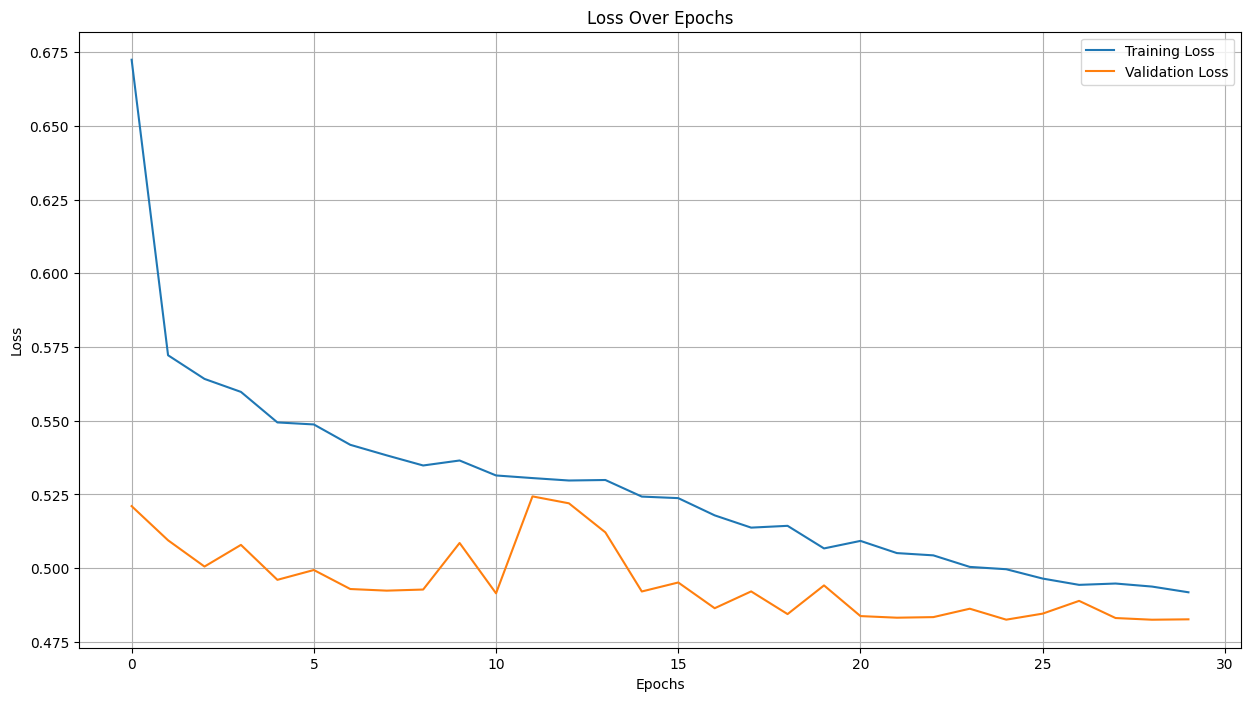

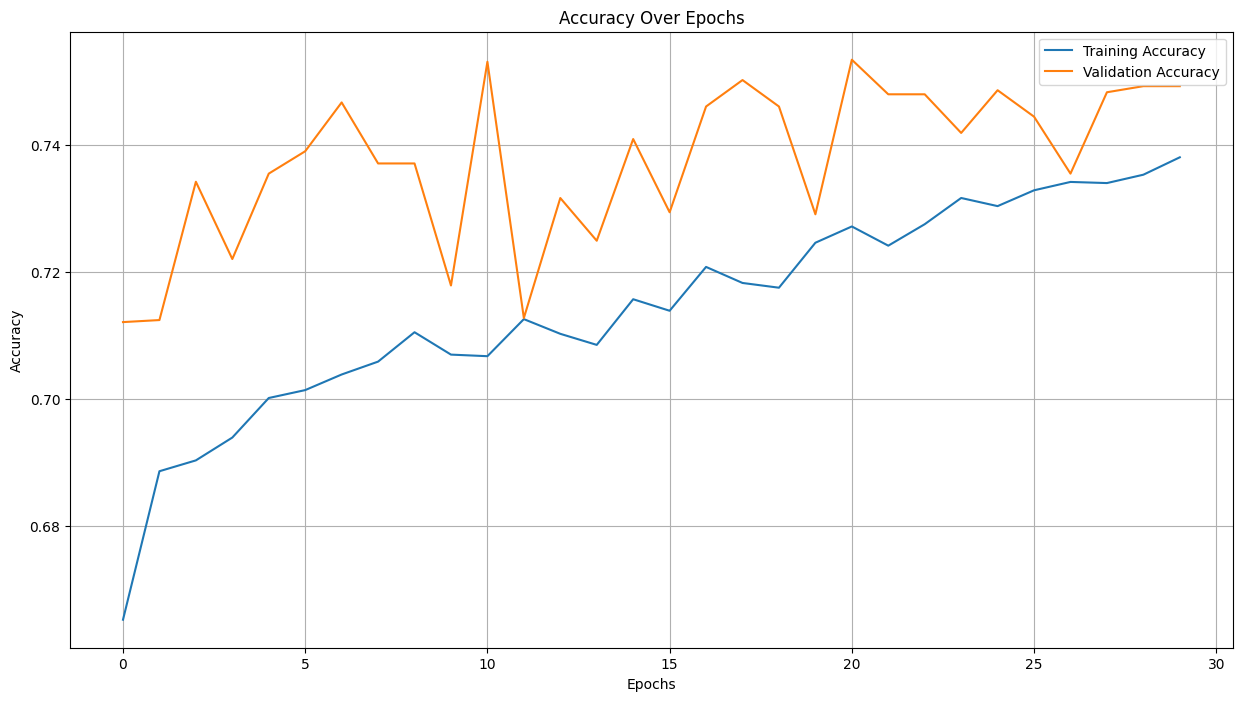

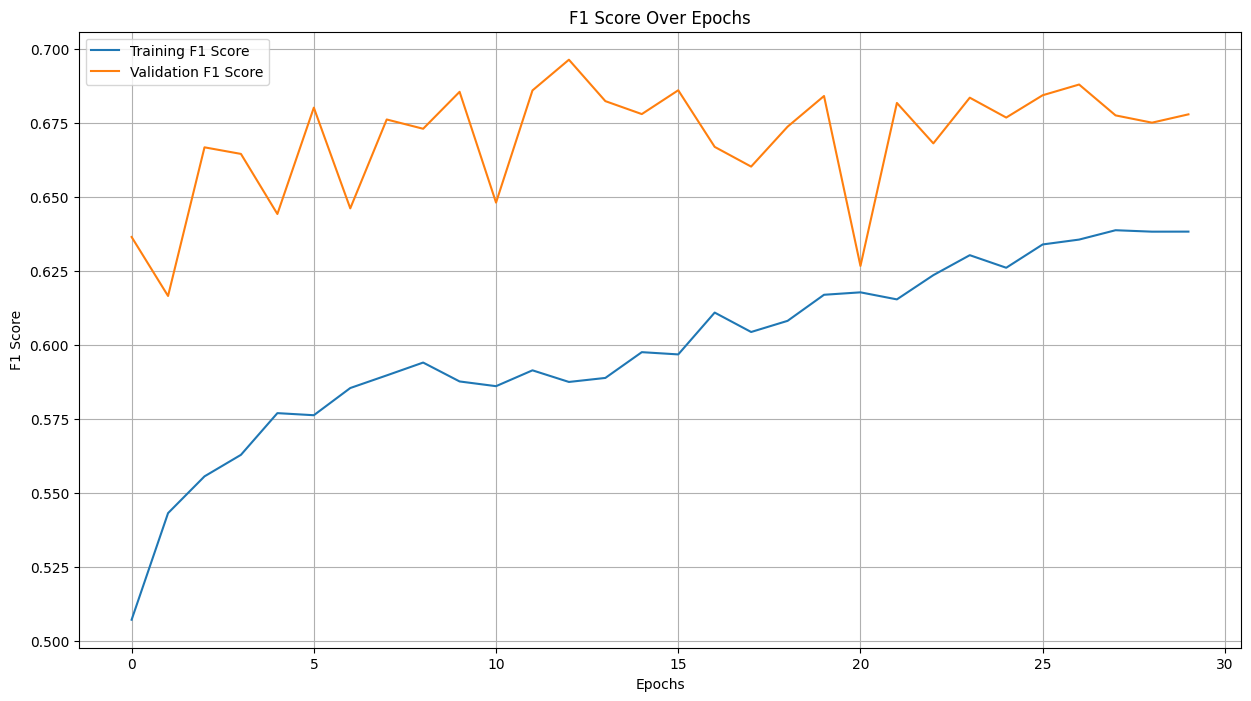

244/244 [==============================] - 0s 1ms/step
Classification Report - Training Set
              precision    recall  f1-score   support

           0       0.84      0.73      0.78     17760
           1       0.62      0.76      0.68     10308

    accuracy                           0.74     28068
   macro avg       0.73      0.74      0.73     28068
weighted avg       0.76      0.74      0.75     28068

Classification Report - Validation Set
              precision    recall  f1-score   support

           0       0.84      0.74      0.79      1973
           1       0.63      0.76      0.69      1146

    accuracy                           0.75      3119
   macro avg       0.74      0.75      0.74      3119
weighted avg       0.76      0.75      0.75      3119

Classification Report - Test Set
              precision    recall  f1-score   support

           0       0.83      0.72      0.77      4933
           1       0.61      0.75      0.67      2864

    accuracy      

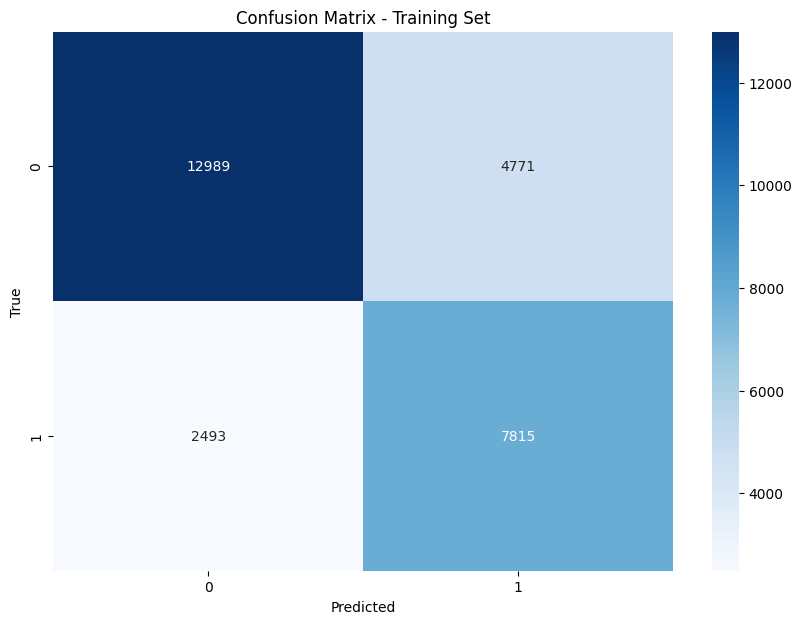

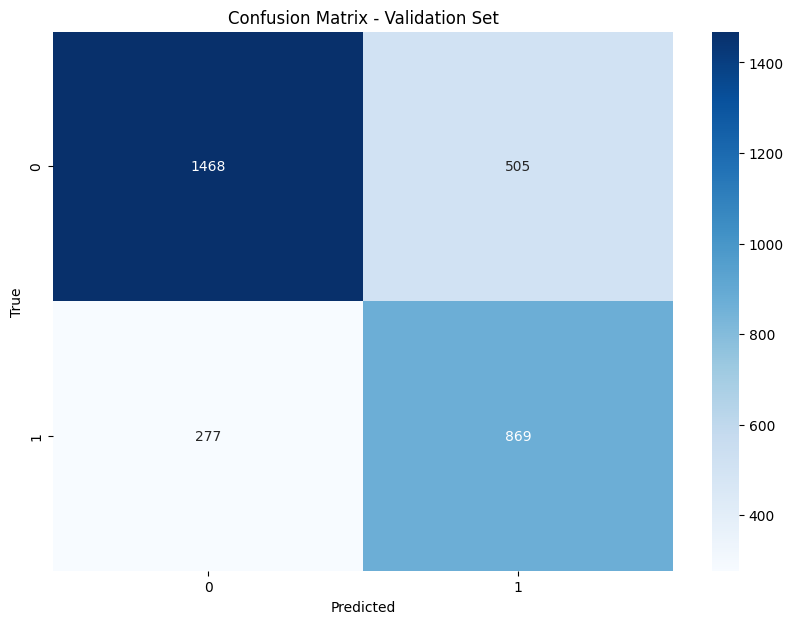

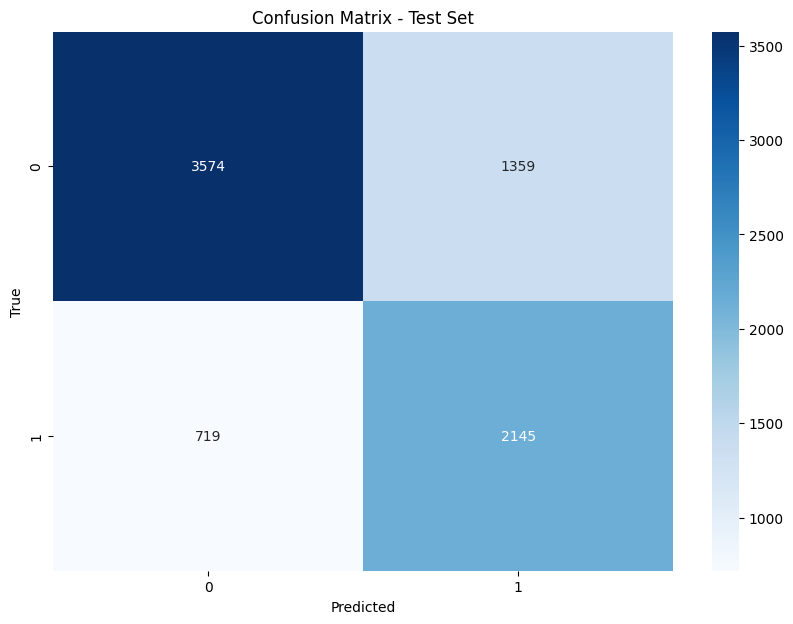

244/244 [==============================] - 0s 1ms/step


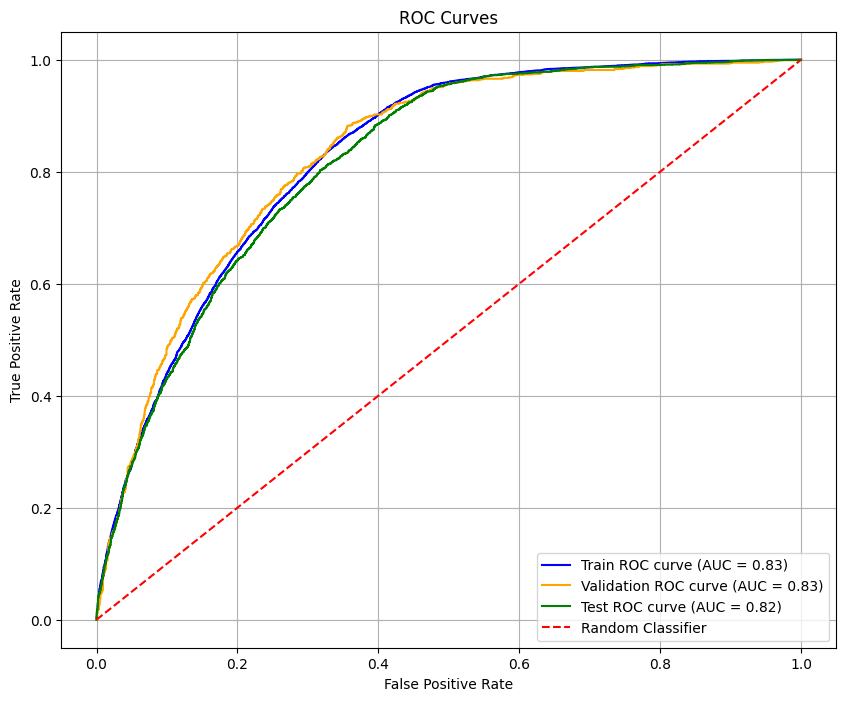

Train AUC: 0.8280
Validation AUC: 0.8321
Test AUC: 0.8199


In [86]:
evaluate_model(history, model, X_train_scaled, X_val_scaled, X_test_scaled, y_train, y_val, y_test)
evaluate_model_withROC(model, X_train_scaled, X_val_scaled, X_test_scaled, y_train, y_val, y_test)

train more

In [115]:
# Total number of iterations (batches) for the training
epochs = 100
batch_size = 32
total_batches = len(X_train_scaled) // batch_size * epochs

# Create an instance of the OneCycleScheduler
one_cycle_scheduler = OneCycleScheduler(iterations=total_batches, max_rate=0.01)

optimizer = SGD(lr=0.001, momentum=0.9)

In [116]:
model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy', f1_score_metric])

In [117]:
history = model.fit(X_train_scaled, y_train, epochs=100, validation_data = (X_val_scaled, y_val), batch_size=32, callbacks=[one_cycle_scheduler])

Epoch 1/100
878/878 [==============================] - 3s 3ms/step - loss: 0.6810 - accuracy: 0.6544 - f1_score_metric: 0.4801 - val_loss: 0.5301 - val_accuracy: 0.7073 - val_f1_score_metric: 0.6450
Epoch 2/100
878/878 [==============================] - 2s 3ms/step - loss: 0.5763 - accuracy: 0.6786 - f1_score_metric: 0.5212 - val_loss: 0.5163 - val_accuracy: 0.7156 - val_f1_score_metric: 0.6395
Epoch 3/100
878/878 [==============================] - 2s 3ms/step - loss: 0.5625 - accuracy: 0.6875 - f1_score_metric: 0.5455 - val_loss: 0.5065 - val_accuracy: 0.7352 - val_f1_score_metric: 0.6550
Epoch 4/100
878/878 [==============================] - 2s 2ms/step - loss: 0.5590 - accuracy: 0.6873 - f1_score_metric: 0.5511 - val_loss: 0.5051 - val_accuracy: 0.7214 - val_f1_score_metric: 0.6618
Epoch 5/100
878/878 [==============================] - 2s 2ms/step - loss: 0.5482 - accuracy: 0.6986 - f1_score_metric: 0.5740 - val_loss: 0.5034 - val_accuracy: 0.7207 - val_f1_score_metric: 0.6708
Epoch

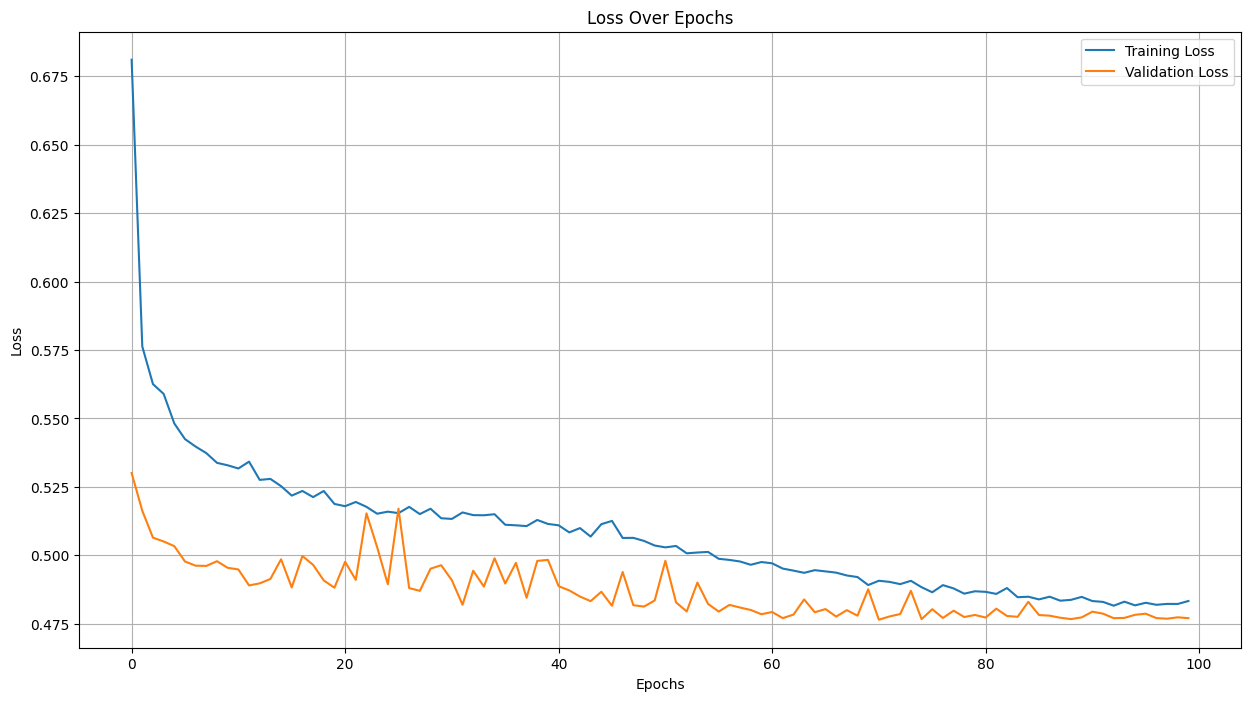

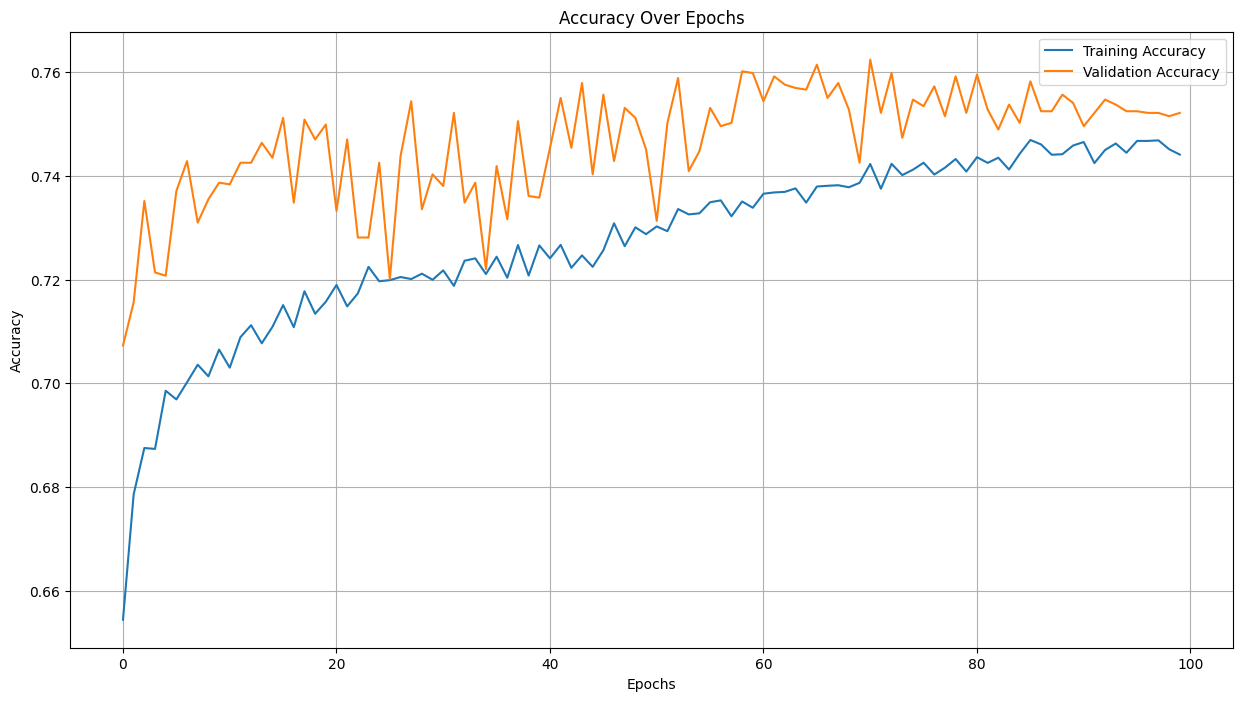

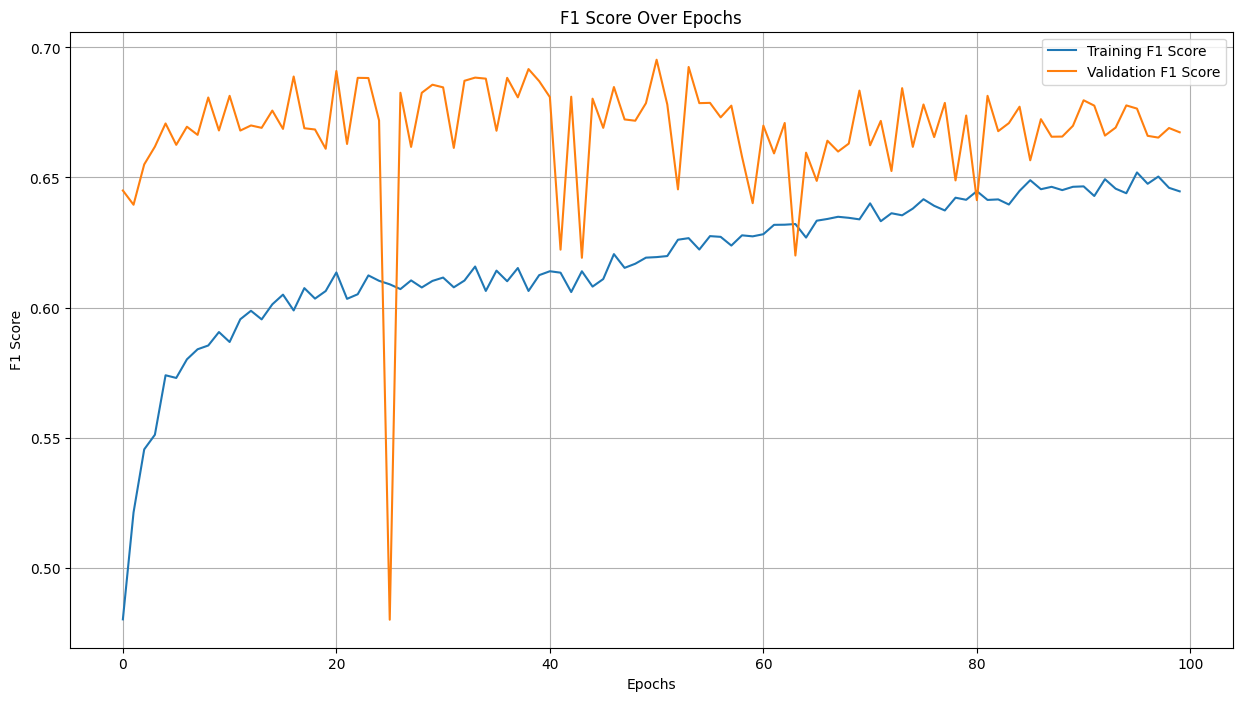

244/244 [==============================] - 0s 1ms/step
Classification Report - Training Set
              precision    recall  f1-score   support

           0       0.83      0.77      0.80     17760
           1       0.65      0.72      0.68     10308

    accuracy                           0.75     28068
   macro avg       0.74      0.75      0.74     28068
weighted avg       0.76      0.75      0.76     28068

Classification Report - Validation Set
              precision    recall  f1-score   support

           0       0.82      0.77      0.80      1973
           1       0.65      0.71      0.68      1146

    accuracy                           0.75      3119
   macro avg       0.74      0.74      0.74      3119
weighted avg       0.76      0.75      0.75      3119

Classification Report - Test Set
              precision    recall  f1-score   support

           0       0.82      0.76      0.79      4933
           1       0.63      0.71      0.67      2864

    accuracy      

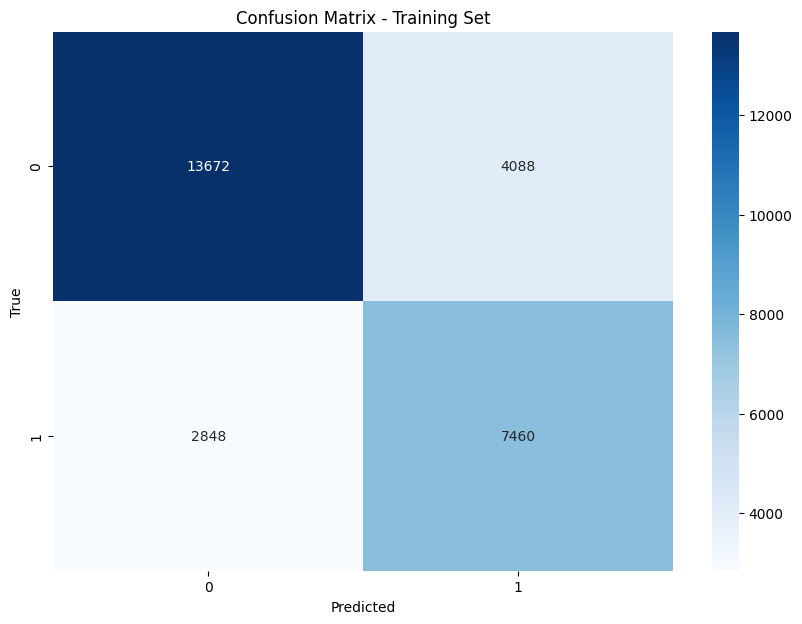

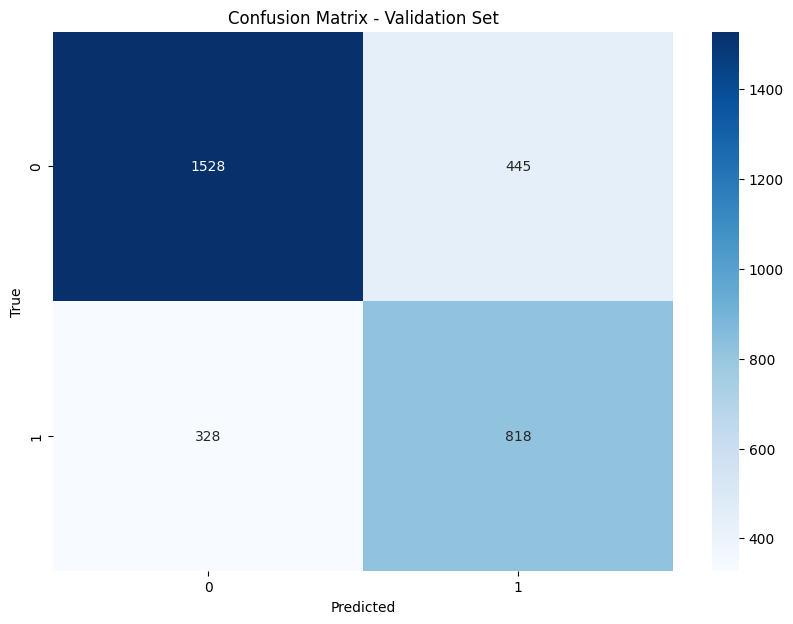

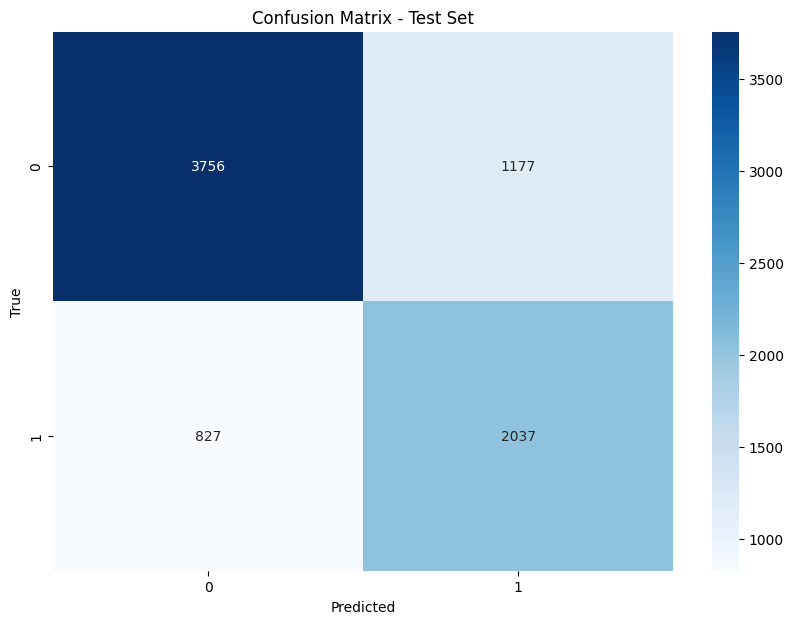

244/244 [==============================] - 0s 1ms/step


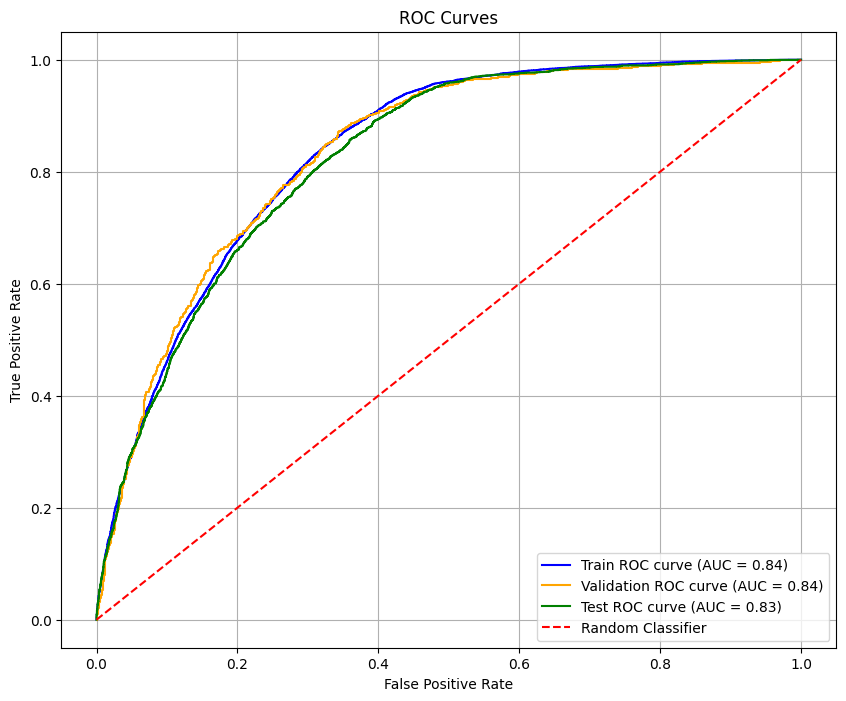

Train AUC: 0.8357
Validation AUC: 0.8351
Test AUC: 0.8266


In [118]:
evaluate_model(history, model, X_train_scaled, X_val_scaled, X_test_scaled, y_train, y_val, y_test)
evaluate_model_withROC(model, X_train_scaled, X_val_scaled, X_test_scaled, y_train, y_val, y_test)

In [119]:
model = keras.models.Sequential([
    keras.layers.Dense(100, kernel_initializer='he_normal', activation='elu', input_shape=(22,),
                       kernel_regularizer=regularizers.L1L2()),
    Dropout(0.5),

    keras.layers.Dense(100, kernel_initializer='he_normal', activation='elu',
                       kernel_regularizer=regularizers.L1L2()),
    Dropout(0.5),

    keras.layers.Dense(100, kernel_initializer='he_normal', activation='elu',
                       kernel_regularizer=regularizers.L1L2()),
    Dropout(0.5),

    keras.layers.Dense(1, activation='sigmoid')
])

In [121]:
# Total number of iterations (batches) for the training
epochs = 30
batch_size = 32
total_batches = len(X_train_scaled) // batch_size * epochs

# Create an instance of the OneCycleScheduler
one_cycle_scheduler = OneCycleScheduler(iterations=total_batches, max_rate=0.01)

optimizer = Adam()

In [122]:
model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy', f1_score_metric])

In [123]:
history = model.fit(X_train_scaled, y_train, epochs=30, validation_data = (X_val_scaled, y_val), batch_size=32, callbacks=[one_cycle_scheduler])

Epoch 1/30
878/878 [==============================] - 3s 3ms/step - loss: 0.7083 - accuracy: 0.6743 - f1_score_metric: 0.5409 - val_loss: 0.4918 - val_accuracy: 0.7358 - val_f1_score_metric: 0.6738
Epoch 2/30
878/878 [==============================] - 2s 3ms/step - loss: 0.5211 - accuracy: 0.7145 - f1_score_metric: 0.6105 - val_loss: 0.4952 - val_accuracy: 0.7454 - val_f1_score_metric: 0.6798
Epoch 3/30
878/878 [==============================] - 2s 3ms/step - loss: 0.5112 - accuracy: 0.7266 - f1_score_metric: 0.6242 - val_loss: 0.4854 - val_accuracy: 0.7480 - val_f1_score_metric: 0.6631
Epoch 4/30
878/878 [==============================] - 2s 3ms/step - loss: 0.5097 - accuracy: 0.7270 - f1_score_metric: 0.6243 - val_loss: 0.4925 - val_accuracy: 0.7496 - val_f1_score_metric: 0.6497
Epoch 5/30
878/878 [==============================] - 2s 3ms/step - loss: 0.5181 - accuracy: 0.7168 - f1_score_metric: 0.6063 - val_loss: 0.4966 - val_accuracy: 0.7512 - val_f1_score_metric: 0.6140
Epoch 6/30

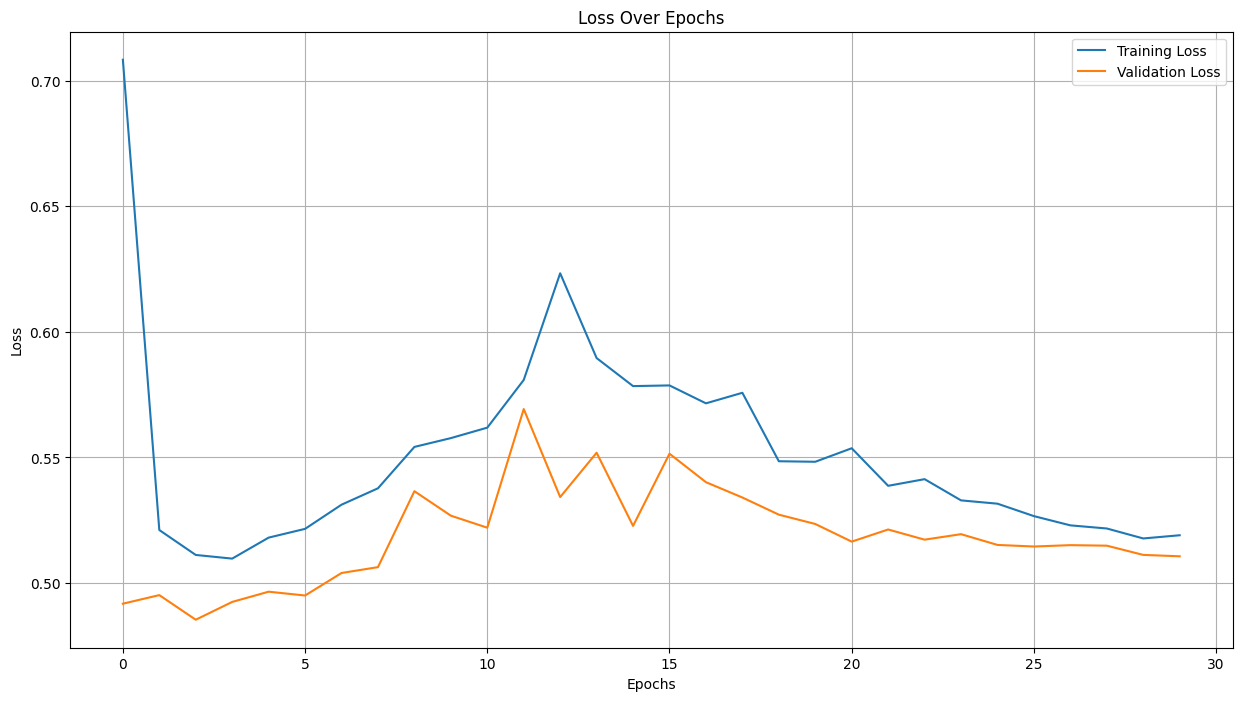

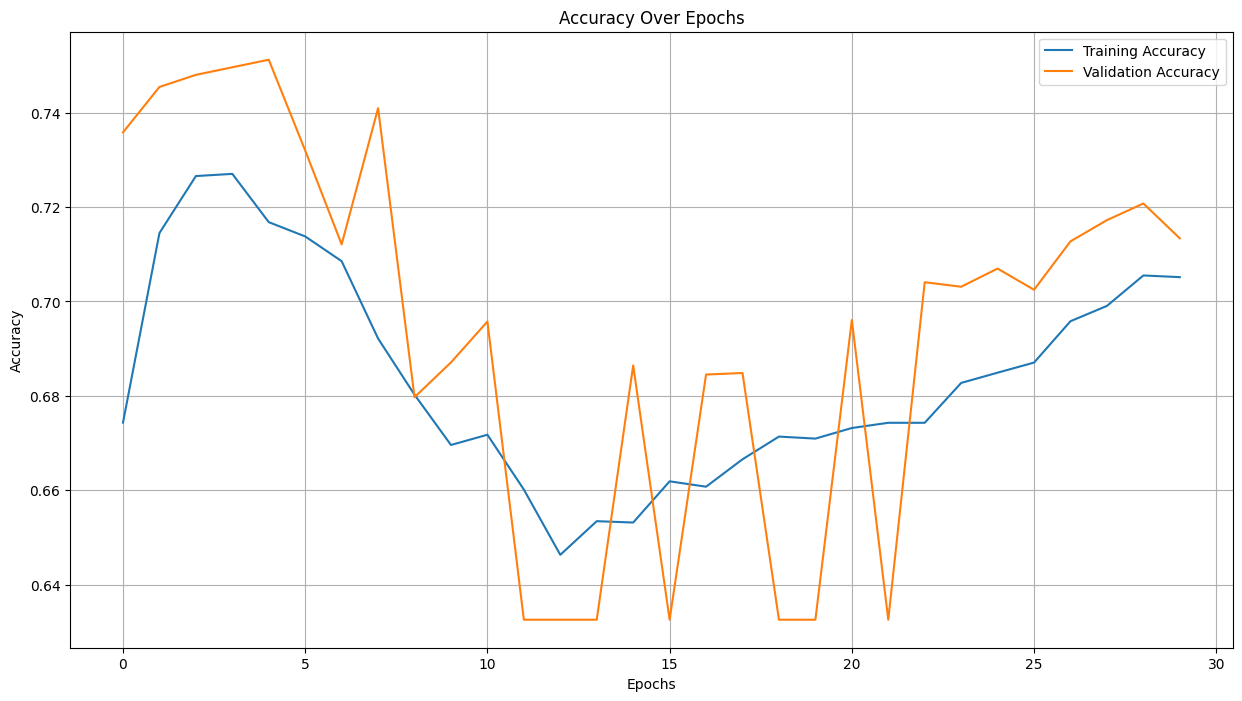

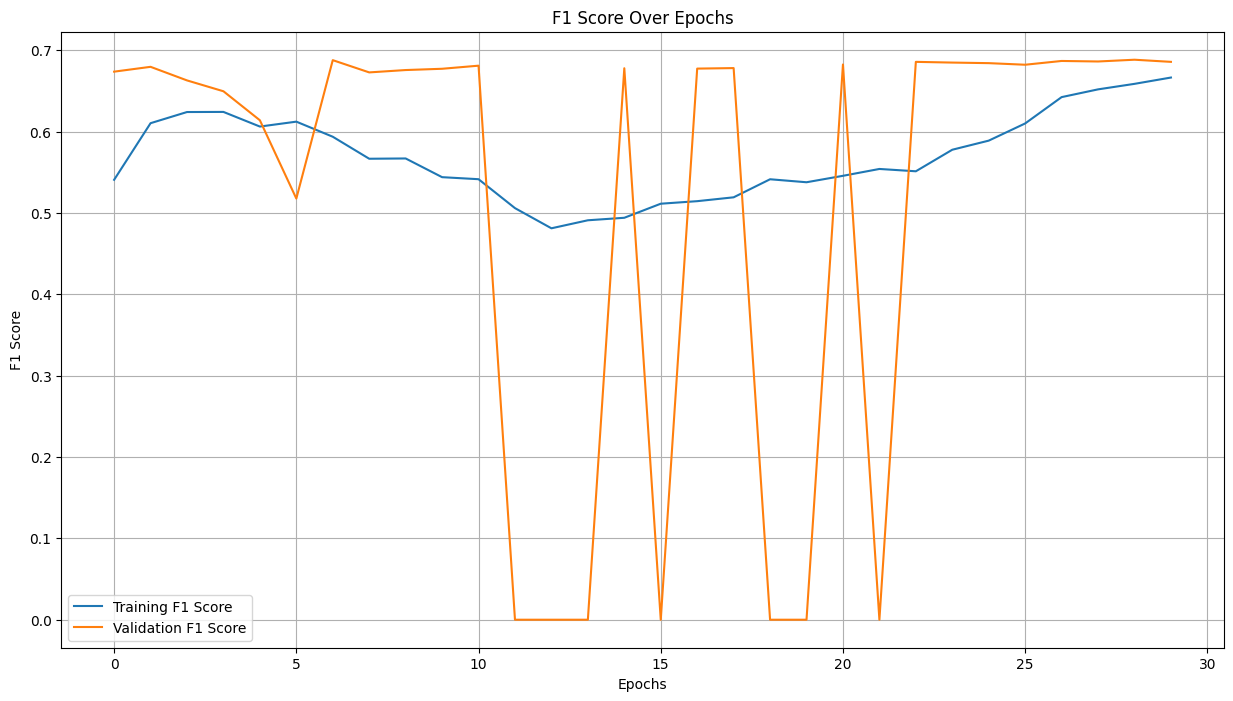

244/244 [==============================] - 0s 1ms/step
Classification Report - Training Set
              precision    recall  f1-score   support

           0       0.91      0.61      0.73     17760
           1       0.57      0.89      0.70     10308

    accuracy                           0.71     28068
   macro avg       0.74      0.75      0.71     28068
weighted avg       0.78      0.71      0.72     28068

Classification Report - Validation Set
              precision    recall  f1-score   support

           0       0.91      0.61      0.73      1973
           1       0.57      0.89      0.70      1146

    accuracy                           0.71      3119
   macro avg       0.74      0.75      0.71      3119
weighted avg       0.78      0.71      0.72      3119

Classification Report - Test Set
              precision    recall  f1-score   support

           0       0.90      0.60      0.72      4933
           1       0.56      0.88      0.68      2864

    accuracy      

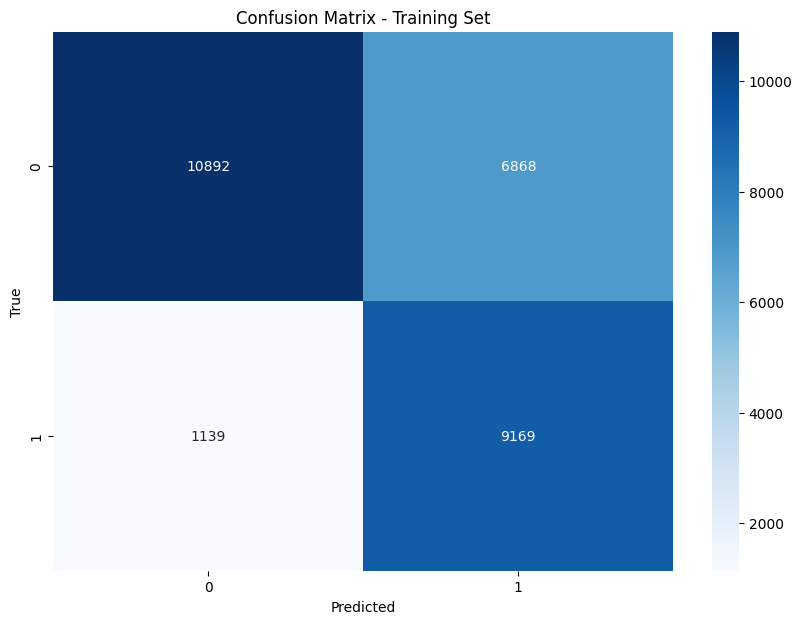

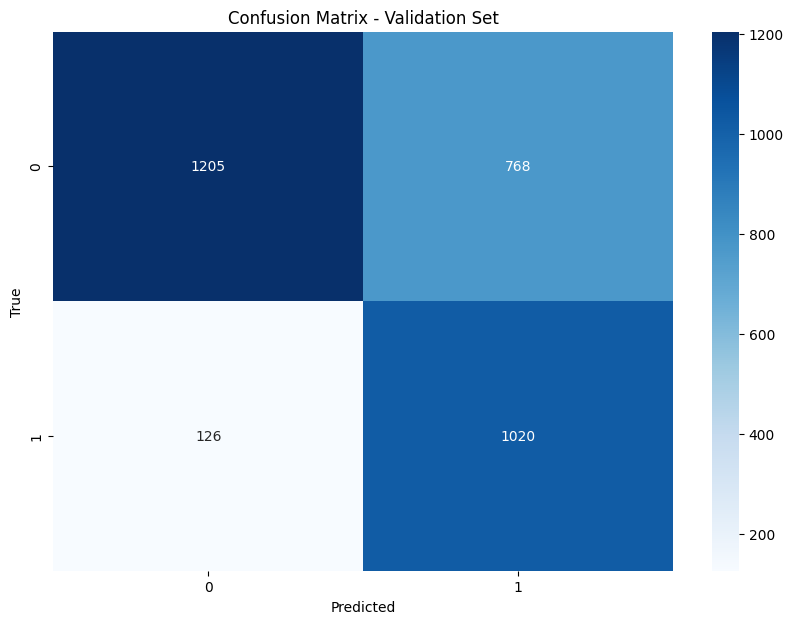

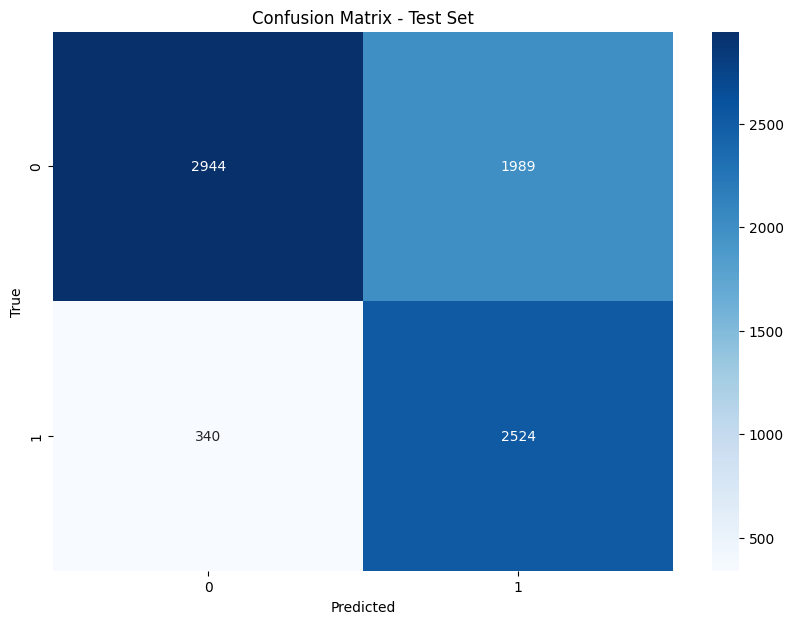

244/244 [==============================] - 0s 1ms/step


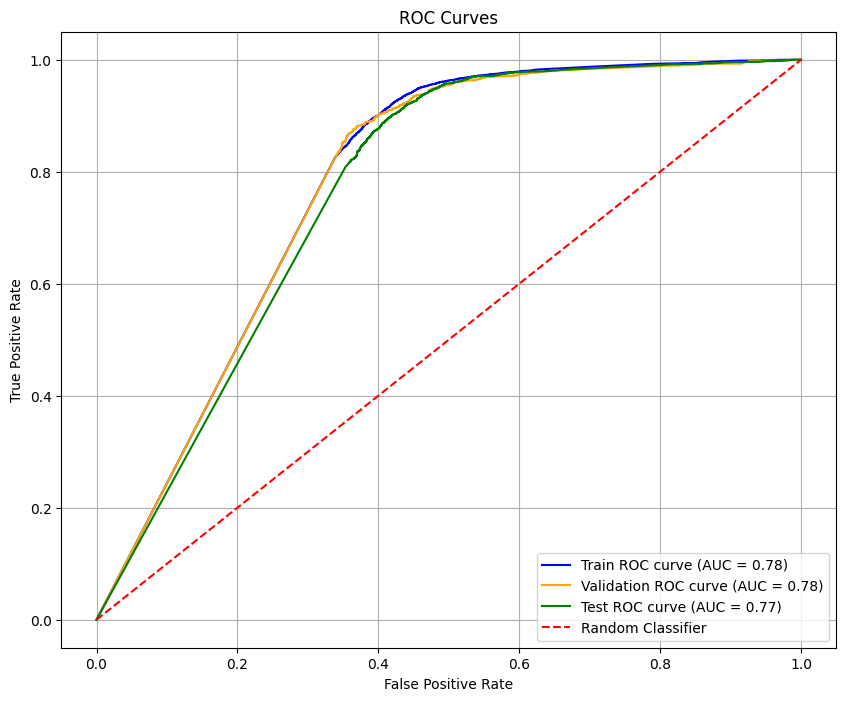

Train AUC: 0.7809
Validation AUC: 0.7783
Test AUC: 0.7675


In [124]:
evaluate_model(history, model, X_train_scaled, X_val_scaled, X_test_scaled, y_train, y_val, y_test)
evaluate_model_withROC(model, X_train_scaled, X_val_scaled, X_test_scaled, y_train, y_val, y_test)

### Use randomSearch CV to tune

In [ ]:
!pip install scikeras

In [127]:
from tensorflow import keras

In [129]:
from sklearn.model_selection import RandomizedSearchCV

In [130]:
from keras.models import Sequential
from keras.layers import Dense

In [ ]:
def create_model(optimizer='adam', activation='relu', neurons=50):
    model = models.Sequential()
    model.add(layers.Dense(50, activation=activation, input_shape=(22,), kernel_initializer='he_normal'))
    model.add(layers.Dropout(dropout_rate))
    model.add(layers.Dense(50, activation=activation, kernel_initializer='he_normal'))
    model.add(layers.Dropout(dropout_rate))
    model.add(layers.Dense(50, activation=activation, kernel_initializer='he_normal'))
    model.add(layers.Dense(1, activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])
    return model


In [ ]:
model = KerasRegressor(build_fn=create_model)


In [ ]:
param_dist = {
    'batch_size': [16, 32, 64, 128],
    'epochs': [10],
    'model__optimizer': ['adam', 'rmsprop', 'sgd'],
    'model__activation': ['relu', 'tanh', 'selu'],
    'model__neurons': [30, 50, 70]
}

# Setup RandomizedSearchCV
random_search = RandomizedSearchCV(model, param_distributions=param_dist,
                                   n_iter=10, cv=3, random_state=42, error_score='raise' ,verbose=1 ,n_jobs=-1 )


In [ ]:
# verbose=0: No output will be displayed. The function runs silently without printing anything to the console.

# verbose=1: Minimal output is shown. You will see messages indicating the progress of the fitting process, such as when a new set of hyperparameters is being tried.

# verbose=2: More detailed output is displayed. This might include messages for each cross-validation fold being evaluated, providing even more insights into the fitting process.

# the defualt is 0

In [ ]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [ ]:
random_search_result = random_search.fit(X_scaled, y)

In [ ]:
best_model = random_search.best_estimator_
best_params = random_search.best_params_
best_score = random_search.best_score_

print("Best Parameters:", best_params)
print("Best Score:", best_score)

In [ ]:
model = keras.models.Sequential([
            keras.layers.Dense(50, kernel_initializer='lecun_normal', activation='relu',input_shape=(20,)),
            keras.layers.Dense(50, kernel_initializer='lecun_normal', activation='relu'),
            keras.layers.Dense(50, kernel_initializer='lecun_normal', activation='relu'),
            keras.layers.Dense(1)
      ])

In [ ]:
model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mean_absolute_error'])

In [ ]:
history = model.fit(X_train_scaled, y_train, epochs=50, validation_data = (X_val_scaled, y_val), batch_size=32)

In [ ]:
history_df = pd.DataFrame(history.history)

# Plot Loss
plt.figure(figsize=(15, 8))
plt.plot(history_df['loss'], label='Training Loss')
plt.plot(history_df['val_loss'], label='Validation Loss')
plt.title('Loss Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

# Plot Mean Absolute Error (MAE)
plt.figure(figsize=(15, 8))
plt.plot(history_df['mean_absolute_error'], label='Training MAE')
plt.plot(history_df['val_mean_absolute_error'], label='Validation MAE')
plt.title('Mean Absolute Error Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Mean Absolute Error')
plt.legend()
plt.grid(True)
plt.show()

y_train_pred = model.predict(X_train_scaled)
y_val_pred = model.predict(X_val_scaled)
y_test_pred = model.predict(X_test_scaled)

r2_train = r2_score(y_train, y_train_pred)
r2_val = r2_score(y_val, y_val_pred)
r2_test = r2_score(y_test, y_test_pred)

print(f'Validation R² score: {r2_val}')
print(f'Validation R² score: {r2_val}')
print(f'Test R² score: {r2_test}')

Even better value with only 50 epochs

### using RandomSearch from keras_tuner

In [ ]:
def create_model(neurons1, neurons2, lr , activation ,initializer):
    model = keras.models.Sequential([
            keras.layers.Dense(neurons1, kernel_initializer=initializer, activation=activation ,input_shape=(20,)),
            keras.layers.Dense(neurons2, kernel_initializer=initializer, activation=activation),
            keras.layers.Dense(neurons2, kernel_initializer=initializer, activation=activation),
            keras.layers.Dense(1)
      ])

    model.compile(optimizer=keras.optimizers.Adam(learning_rate=lr), loss='mean_squared_error')
    return model

def build_model(hp):
    neurons1 = hp.Int("units1", min_value=32, max_value=512, step=32)
    neurons2 = hp.Int("units2", min_value=32, max_value=512, step=32)
    lr = hp.Float("learning_rate", min_value=1e-4, max_value=1e-2, sampling="log")
    activation=hp.Choice('activation', ['relu', 'tanh', 'selu'])
    initializer=hp.Choice('initializer', ['lecun_normal', 'he_normal', 'glorot_normal'])

    model = create_model(
        neurons1=neurons1, neurons2=neurons2, lr=lr , activation=activation , initializer=initializer
    )
    return model


In [ ]:
tuner = kt.RandomSearch(
    build_model,
    objective='val_loss',
    max_trials=10,
    executions_per_trial=1, # only one run for each model -> many runs help to see how model work with diff W's random initialization
    overwrite=True
    )

In [ ]:
tuner.search(X_train_scaled, y_train, epochs=10, validation_data=(X_val_scaled, y_val), batch_size=32)

In [ ]:
best_model = tuner.get_best_models()[0]
best_hps=tuner.get_best_hyperparameters(num_trials=1)[0]


#### try with BayesianOptimization

In [ ]:
tuner = kt.BayesianOptimization(
    build_model,
    objective='val_loss',
    max_trials=10,
    overwrite=True)

In [ ]:
tuner.search(X_train_scaled, y_train, epochs=10, validation_data=(X_val_scaled, y_val), batch_size=32)